# Construct a custom Environment for Pair Trading

Some examples on the market
* [custom env example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb#scrollTo=RqxatIwPOXe_)
* [StockTradingEnv by Adam King](https://github.com/notadamking/Stock-Trading-Environment)
* [FinRL](https://github.com/AI4Finance-Foundation/FinRL)

Target is to construct a custom Env for pair trading

This env restrict the behaviour of RL learner to pair trading only

## 1. Import the Custom Trading Env

In [1]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange
from stable_baselines3 import PPO, A2C, DQN

from params import *
from utils.read2df import read2df, unify_dfs
from utils.clearlogs import clear_logs
from envs.env_rl_restrict_thres import RL_Restrict_TradeEnv

folder_path = f"result/rl-restrict-thres"
os.makedirs(folder_path, exist_ok=True)

## 2. Prepare Trading Data
Load data from `preliminaries.ipynb`

In [2]:
with open('result/cointncorr.pickle', 'rb') as pk:
    cointncorr = pickle.load(pk)

with open('result/gridsearch/best_res.pickle', 'rb') as pk:
    best_profit, best_params = pickle.load(pk)

dfs = read2df(symbols=cointncorr[0], freqs={cointncorr[1]: freqs[cointncorr[1]]})
tics, df = unify_dfs(dfs, symbols=cointncorr[0], period=best_params['period'])

In [3]:
df.tail(20)

time    close0 itvl                datetime    close1  \
175660  1701387659999  0.000530   1m 2023-11-30 23:40:59.999  0.000615   
175661  1701387719999  0.000530   1m 2023-11-30 23:41:59.999  0.000615   
175662  1701387779999  0.000531   1m 2023-11-30 23:42:59.999  0.000615   
175663  1701387839999  0.000531   1m 2023-11-30 23:43:59.999  0.000615   
175664  1701387899999  0.000531   1m 2023-11-30 23:44:59.999  0.000615   
175665  1701387959999  0.000531   1m 2023-11-30 23:45:59.999  0.000615   
175666  1701388019999  0.000531   1m 2023-11-30 23:46:59.999  0.000615   
175667  1701388079999  0.000530   1m 2023-11-30 23:47:59.999  0.000615   
175668  1701388139999  0.000530   1m 2023-11-30 23:48:59.999  0.000615   
175669  1701388199999  0.000530   1m 2023-11-30 23:49:59.999  0.000615   
175670  1701388259999  0.000530   1m 2023-11-30 23:50:59.999  0.000615   
175671  1701388319999  0.000530   1m 2023-11-30 23:51:59.999  0.000615   
175672  1701388379999  0.000530   1m 2023-11-30 23:52:59.999  0.000615   
175673  1701388439999  0.000530   1m 2023-11-30 23:53:59.999  0.000615   
175674  1701388499999  0.000530   1m 2023-11-30 23:54:59.999  0.000615   
175675  1701388559999  0.000530   1m 2023-11-30 23:55:59.999  0.000615   
175676  1701388619999  0.000530   1m 2023-11-30 23:56:59.999  0.000615   
175677  1701388679999  0.000530   1m 2023-11-30 23:57:59.999  0.000615   
175678  1701388739999  0.000530   1m 2023-11-30 23:58:59.999  0.000615   
175679  1701388799999  0.000530   1m 2023-11-30 23:59:59.999  0.000615   

          spread    zscore  
175660 -0.000084 -0.524611  
175661 -0.000084 -0.382367  
175662 -0.000084 -0.150181  
175663 -0.000084 -0.151877  
175664 -0.000084 -0.233467  
175665 -0.000084 -0.238003  
175666 -0.000084 -0.236771  
175667 -0.000084 -0.362875  
175668 -0.000085 -0.866649  
175669 -0.000085 -0.896373  
175670 -0.000085 -0.873001  
175671 -0.000085 -0.749277  
175672 -0.000084 -0.628945  
175673 -0.000084 -0.571026  
175674 -0.000084 -0.574290  
175675 -0.000084 -0.628750  
175676 -0.000084 -0.603341  
175677 -0.000084 -0.623742  
175678 -0.000084 -0.613500  
175679 -0.000084 -0.555104

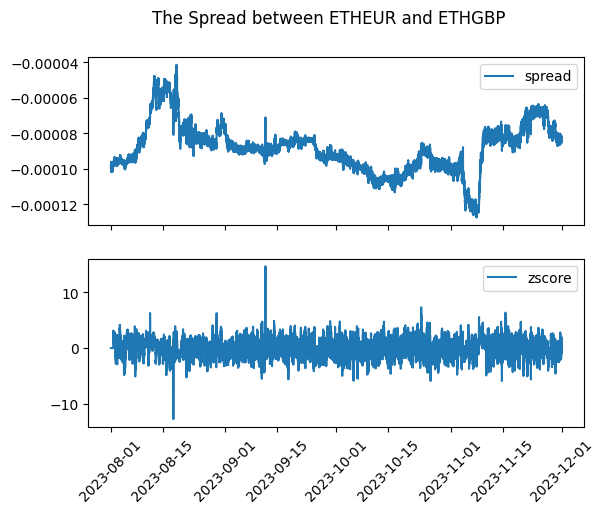

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(df['datetime'], df['spread'], label='spread')
ax2.plot(df['datetime'], df['zscore'], label='zscore')

ax1.legend()
ax2.legend()
plt.suptitle(f'The Spread between {cointncorr[0][0]} and {cointncorr[0][1]}')

plt.xticks(rotation=45)
plt.show()

In [5]:
train = df[(df['datetime'] >= datetime.strptime(start_date, date_format)) & (df['datetime'] < datetime.strptime(trade_date, date_format))]
test = df[(df['datetime'] >= datetime.strptime(trade_date, date_format)) & (df['datetime'] < datetime.strptime(end_date, date_format))]

max_train_len = int((len(train)-best_params['period']) * 0.95)
print(f"The length of our training data: {len(train)}")

The length of our training data: 87840


## 3. Check with baselin3 `env_checker`

Check if the env meets the requirements of `stable_baseline3`

In [6]:
from stable_baselines3.common.env_checker import check_env

env = RL_Restrict_TradeEnv(train)
obs, _ = env.reset()
check_env(env)

Tensorboard

## 4. Train the Model with Trading Env

In [7]:
log_path = f"logs/restrict_thres/"
clear_logs(log_path)

# Read more about tensorboard
# https://github.com/tensorflow/tensorboard/blob/master/README.md
# https://www.tensorflow.org/tensorboard/get_started

In [8]:
'''PPO'''

model_ppo = PPO("MultiInputPolicy", env, verbose=1, gamma=1, batch_size=256)
model_ppo.learn(total_timesteps=max_train_len, progress_bar=True)
model_ppo.save(f"{folder_path}/ppo_pairtrading")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Output()

-----------------------------
| time/              |      |
|    fps             | 446  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 491         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011595733 |
|    clip_fraction        | 0.0986      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.00595     |
|    learning_rate        | 0.0003      |
|    loss                 | 10.5        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0186     |
|    value_loss           | 32.9        |
-----------------------------------------
----------------------------------

-------------------------------------------
| time/                   |               |
|    fps                  | 359           |
|    iterations           | 28            |
|    time_elapsed         | 159           |
|    total_timesteps      | 57344         |
| train/                  |               |
|    approx_kl            | 0.00023004919 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0935       |
|    explained_variance   | 0.000815      |
|    learning_rate        | 0.0003        |
|    loss                 | 143           |
|    n_updates            | 270           |
|    policy_gradient_loss | -0.000699     |
|    value_loss           | 320           |
-------------------------------------------


-------------------------------------------
| time/                   |               |
|    fps                  | 361           |
|    iterations           | 29            |
|    time_elapsed         | 164           |
|    total_timesteps      | 59392         |
| train/                  |               |
|    approx_kl            | 0.00041149367 |
|    clip_fraction        | 0.0042        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0555       |
|    explained_variance   | 0.000646      |
|    learning_rate        | 0.0003        |
|    loss                 | 155           |
|    n_updates            | 280           |
|    policy_gradient_loss | -0.000922     |
|    value_loss           | 339           |
-------------------------------------------


-------------------------------------------
| time/                   |               |
|    fps                  | 362           |
|    iterations           | 30            |
|    time_elapsed         | 169           |
|    total_timesteps      | 61440         |
| train/                  |               |
|    approx_kl            | 0.00037754534 |
|    clip_fraction        | 0.00308       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0623       |
|    explained_variance   | 0.000199      |
|    learning_rate        | 0.0003        |
|    loss                 | 150           |
|    n_updates            | 290           |
|    policy_gradient_loss | -0.000999     |
|    value_loss           | 324           |
-------------------------------------------


-------------------------------------------
| time/                   |               |
|    fps                  | 364           |
|    iterations           | 31            |
|    time_elapsed         | 174           |
|    total_timesteps      | 63488         |
| train/                  |               |
|    approx_kl            | 0.00036344014 |
|    clip_fraction        | 0.00244       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0732       |
|    explained_variance   | 3.53e-05      |
|    learning_rate        | 0.0003        |
|    loss                 | 154           |
|    n_updates            | 300           |
|    policy_gradient_loss | -0.00134      |
|    value_loss           | 339           |
-------------------------------------------


-------------------------------------------
| time/                   |               |
|    fps                  | 365           |
|    iterations           | 32            |
|    time_elapsed         | 179           |
|    total_timesteps      | 65536         |
| train/                  |               |
|    approx_kl            | 0.00029333335 |
|    clip_fraction        | 0.00132       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0656       |
|    explained_variance   | -0.00111      |
|    learning_rate        | 0.0003        |
|    loss                 | 150           |
|    n_updates            | 310           |
|    policy_gradient_loss | -0.00059      |
|    value_loss           | 330           |
-------------------------------------------


-------------------------------------------
| time/                   |               |
|    fps                  | 366           |
|    iterations           | 33            |
|    time_elapsed         | 184           |
|    total_timesteps      | 67584         |
| train/                  |               |
|    approx_kl            | 0.00020467435 |
|    clip_fraction        | 0.00322       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0599       |
|    explained_variance   | -0.000357     |
|    learning_rate        | 0.0003        |
|    loss                 | 156           |
|    n_updates            | 320           |
|    policy_gradient_loss | -0.0005       |
|    value_loss           | 342           |
-------------------------------------------


-------------------------------------------
| time/                   |               |
|    fps                  | 367           |
|    iterations           | 34            |
|    time_elapsed         | 189           |
|    total_timesteps      | 69632         |
| train/                  |               |
|    approx_kl            | 0.00036096576 |
|    clip_fraction        | 0.00278       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0696       |
|    explained_variance   | 0.00048       |
|    learning_rate        | 0.0003        |
|    loss                 | 148           |
|    n_updates            | 330           |
|    policy_gradient_loss | -0.00108      |
|    value_loss           | 323           |
-------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 368          |
|    iterations           | 35           |
|    time_elapsed         | 194          |
|    total_timesteps      | 71680        |
| train/                  |              |
|    approx_kl            | 0.0013443009 |
|    clip_fraction        | 0.00386      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0633      |
|    explained_variance   | -0.000103    |
|    learning_rate        | 0.0003       |
|    loss                 | 156          |
|    n_updates            | 340          |
|    policy_gradient_loss | -0.00219     |
|    value_loss           | 339          |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 367         |
|    iterations           | 36          |
|    time_elapsed         | 200         |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.001375996 |
|    clip_fraction        | 0.0111      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0726     |
|    explained_variance   | -0.000349   |
|    learning_rate        | 0.0003      |
|    loss                 | 156         |
|    n_updates            | 350         |
|    policy_gradient_loss | -0.00194    |
|    value_loss           | 339         |
-----------------------------------------


-------------------------------------------
| time/                   |               |
|    fps                  | 367           |
|    iterations           | 37            |
|    time_elapsed         | 206           |
|    total_timesteps      | 75776         |
| train/                  |               |
|    approx_kl            | 0.00097073324 |
|    clip_fraction        | 0.00884       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0752       |
|    explained_variance   | 0.000305      |
|    learning_rate        | 0.0003        |
|    loss                 | 156           |
|    n_updates            | 360           |
|    policy_gradient_loss | -0.0015       |
|    value_loss           | 344           |
-------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 368          |
|    iterations           | 38           |
|    time_elapsed         | 211          |
|    total_timesteps      | 77824        |
| train/                  |              |
|    approx_kl            | 0.0013730555 |
|    clip_fraction        | 0.0144       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0921      |
|    explained_variance   | 0.000633     |
|    learning_rate        | 0.0003       |
|    loss                 | 151          |
|    n_updates            | 370          |
|    policy_gradient_loss | -0.00236     |
|    value_loss           | 329          |
------------------------------------------


-------------------------------------------
| time/                   |               |
|    fps                  | 369           |
|    iterations           | 39            |
|    time_elapsed         | 216           |
|    total_timesteps      | 79872         |
| train/                  |               |
|    approx_kl            | 0.00025597433 |
|    clip_fraction        | 0.00137       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0737       |
|    explained_variance   | 0.000417      |
|    learning_rate        | 0.0003        |
|    loss                 | 159           |
|    n_updates            | 380           |
|    policy_gradient_loss | -0.000957     |
|    value_loss           | 348           |
-------------------------------------------


## 5. Create the Custom Test Env

In [9]:
test_env = RL_Restrict_TradeEnv(test, verbose=0)

In [10]:
max_test_len = int(len(test) * 0.95)
print(f"The length of our test data: {max_test_len}")

The length of our test data: 82080


## 6. Test Env with Trained Model

In [ ]:
try:
    os.remove(f"{folder_path}/networth_ppo.csv")
except OSError:
    pass

obs, _ = test_env.reset()

for i in trange(max_test_len):
    action, _states = model_ppo.predict(obs)
    obs, rewards, terminated, truncated, info = test_env.step(action)
    test_env.render()

test_env.close()

  0%|                                                                                                                                       | 72/82080 [00:00<01:53, 719.84it/s]

signal: {'position': 1, 'zone': 1, 'zscore': array([1.59266346])}, action: 1, reward:1, networth: 1.0
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.79895314])}, action: 1, reward:1, networth: 1.0
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.31322468])}, action: 1, reward:1, networth: 1.0
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.93334706])}, action: 1, reward:1, networth: 1.0
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.38424742])}, action: 1, reward:1, networth: 1.0
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.85727425])}, action: 1, reward:1, networth: 1.0
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.10618426])}, action: 1, reward:1, networth: 1.0
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.12104804])}, action: 1, reward:1, networth: 1.0
signal: {'position': array(1, dtype=int64), 

  0%|▎                                                                                                                                     | 222/82080 [00:00<01:50, 742.24it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.32978642])}, action: 1, reward:1, networth: 1.0037
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.15562486])}, action: 1, reward:1, networth: 1.0037
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.14928458])}, action: 1, reward:1, networth: 1.0037
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.01286378])}, action: 1, reward:1, networth: 1.0037
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.20731089])}, action: 1, reward:1, networth: 1.0037
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.70826073])}, action: 1, reward:1, networth: 1.0037
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.0032291])}, action: 1, reward:1, networth: 1.0037
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.24490534])}, action: 1, reward:1, networth: 1.00

  0%|▌                                                                                                                                     | 372/82080 [00:00<01:52, 726.83it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.62305664])}, action: 1, reward:1, networth: 1.0105
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.37804843])}, action: 1, reward:1, networth: 1.0105
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.26911466])}, action: 1, reward:1, networth: 1.0105
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.57308916])}, action: 1, reward:1, networth: 1.0105
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.4368247])}, action: 1, reward:1, networth: 1.0105
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.49066482])}, action: 1, reward:1, networth: 1.0105
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.47961152])}, action: 1, reward:1, networth: 1.0105
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.55574265])}, action: 1, reward:1, networth: 

  1%|▊                                                                                                                                     | 522/82080 [00:00<01:50, 740.50it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.89126778])}, action: 2, reward:1, networth: 1.0133
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.88527084])}, action: 2, reward:1, networth: 1.0133
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.14349502])}, action: 2, reward:1, networth: 1.0129
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.13088662])}, action: 2, reward:1, networth: 1.0129
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.72793573])}, action: 2, reward:1, networth: 1.0133
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.60675809])}, action: 2, reward:1, networth: 1.0115
signal: {'position': array(2, dtype=int64), 'zone': 2, 'zscore': array([0.06165082])}, action: 0, reward:0, networth: 1.015
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.77478161])}, action: 0, reward:1, networth: 1.

  1%|█                                                                                                                                     | 673/82080 [00:00<01:51, 731.13it/s]

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.65777215])}, action: 0, reward:1, networth: 1.0466
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.78567002])}, action: 0, reward:1, networth: 1.0463
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.58229887])}, action: 0, reward:1, networth: 1.0466
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.74079001])}, action: 0, reward:1, networth: 1.0463
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.39539201])}, action: 0, reward:1, networth: 1.0471
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.17268502])}, action: 0, reward:1, networth: 1.0475
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.36904438])}, action: 0, reward:1, networth: 1.0471
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.41990991])}, action: 0, reward:1, networth: 1.047
s

  1%|█▍                                                                                                                                    | 897/82080 [00:01<01:49, 740.53it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.75865228])}, action: 1, reward:1, networth: 1.0492
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.16080174])}, action: 1, reward:1, networth: 1.0492
signal: {'position': array(1, dtype=int64), 'zone': 0, 'zscore': array([1.79268722])}, action: 0, reward:1, networth: 1.0492
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.62741742])}, action: 0, reward:1, networth: 1.0496
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.62294915])}, action: 0, reward:1, networth: 1.0496
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.59706173])}, action: 0, reward:1, networth: 1.0496
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.59276254])}, action: 1, reward:0, networth: 1.0496
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.3654419])}, action: 1, reward:1, networth: 1.0496
s

  1%|█▋                                                                                                                                   | 1047/82080 [00:01<01:49, 743.13it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.79037624])}, action: 1, reward:1, networth: 1.0498
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.7894457])}, action: 1, reward:1, networth: 1.0498
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.94614094])}, action: 1, reward:1, networth: 1.0498
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.04546703])}, action: 1, reward:1, networth: 1.0498
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.8890362])}, action: 1, reward:1, networth: 1.0498
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.88739275])}, action: 1, reward:1, networth: 1.0498
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.22630653])}, action: 1, reward:1, networth: 1.0498
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.75436359])}, action: 1, reward:1, networth: 1.0498
si

  1%|█▉                                                                                                                                   | 1199/82080 [00:01<01:47, 750.13it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.45190455])}, action: 1, reward:1, networth: 1.0527
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.60870724])}, action: 1, reward:1, networth: 1.0527
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.38428258])}, action: 1, reward:1, networth: 1.0527
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.66057119])}, action: 1, reward:1, networth: 1.0527
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.60163533])}, action: 1, reward:1, networth: 1.0527
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.15515606])}, action: 1, reward:1, networth: 1.0527
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.55543337])}, action: 1, reward:1, networth: 1.0527
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.63676372])}, action: 1, reward:1, networth: 1.0527


  2%|██                                                                                                                                   | 1275/82080 [00:01<01:47, 748.61it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.45203723])}, action: 1, reward:1, networth: 1.0594
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.32189556])}, action: 1, reward:1, networth: 1.0594
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.0608247])}, action: 1, reward:1, networth: 1.0594
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.32441843])}, action: 1, reward:1, networth: 1.0594
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.42148535])}, action: 1, reward:1, networth: 1.0594
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.45021796])}, action: 1, reward:1, networth: 1.0594
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.75029235])}, action: 1, reward:1, networth: 1.0594
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.6545577])}, action: 1, reward:1, networth: 1.0594
si

  2%|██▎                                                                                                                                  | 1425/82080 [00:01<01:48, 743.09it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.5585295])}, action: 1, reward:1, networth: 1.0611
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.44682603])}, action: 1, reward:1, networth: 1.0611
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.76115539])}, action: 1, reward:1, networth: 1.0611
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.99592704])}, action: 1, reward:1, networth: 1.0611
signal: {'position': array(1, dtype=int64), 'zone': 0, 'zscore': array([2.06176072])}, action: 0, reward:1, networth: 1.0611
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.87165627])}, action: 0, reward:1, networth: 1.0613
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.06938847])}, action: 1, reward:0, networth: 1.0624
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.71331458])}, action: 1, reward:1, networth: 1.0624
s

  2%|██▌                                                                                                                                  | 1574/82080 [00:02<01:49, 734.41it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.79973646])}, action: 2, reward:1, networth: 1.0741
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.05204534])}, action: 2, reward:1, networth: 1.0752
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.30042911])}, action: 2, reward:1, networth: 1.0749
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.11557554])}, action: 2, reward:1, networth: 1.0736
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.73476291])}, action: 2, reward:1, networth: 1.0741
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-0.99160082])}, action: 2, reward:1, networth: 1.0753
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-0.7551601])}, action: 1, reward:0, networth: 1.0757
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.16953494])}, action: 1, reward:1, networth: 

  2%|██▉                                                                                                                                  | 1797/82080 [00:02<01:49, 736.41it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.96288154])}, action: 2, reward:1, networth: 1.0839
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.15692109])}, action: 2, reward:1, networth: 1.0834
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.16155327])}, action: 2, reward:1, networth: 1.0833
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.85119252])}, action: 2, reward:1, networth: 1.0841
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.58440614])}, action: 2, reward:1, networth: 1.0848
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.72853029])}, action: 2, reward:1, networth: 1.0844
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.58831443])}, action: 2, reward:1, networth: 1.0848
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.9357879])}, action: 2, reward:1, networth: 

  2%|███▏                                                                                                                                 | 1945/82080 [00:02<01:49, 732.33it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.01285437])}, action: 1, reward:1, networth: 1.0966
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.89365802])}, action: 1, reward:1, networth: 1.0966
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.02667984])}, action: 1, reward:1, networth: 1.0966
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.73682492])}, action: 1, reward:1, networth: 1.0966
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.85427062])}, action: 1, reward:1, networth: 1.0966
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.05664472])}, action: 1, reward:1, networth: 1.0966
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.95530829])}, action: 1, reward:1, networth: 1.0966
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.10172785])}, action: 1, reward:1, networth:

  3%|███▍                                                                                                                                 | 2092/82080 [00:02<01:49, 728.67it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.90861079])}, action: 1, reward:1, networth: 1.101
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.84210964])}, action: 1, reward:1, networth: 1.101
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.1480165])}, action: 1, reward:1, networth: 1.101
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.97558277])}, action: 1, reward:1, networth: 1.101
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.97343368])}, action: 1, reward:1, networth: 1.101
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.02854446])}, action: 1, reward:1, networth: 1.101
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.21558731])}, action: 1, reward:1, networth: 1.101
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.21278601])}, action: 1, reward:1, networth: 1.101
s

  3%|███▋                                                                                                                                 | 2240/82080 [00:03<01:49, 732.22it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.42641905])}, action: 1, reward:1, networth: 1.101
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.34664878])}, action: 1, reward:1, networth: 1.101
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.33557332])}, action: 1, reward:1, networth: 1.101
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.66070147])}, action: 1, reward:1, networth: 1.101
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.58257965])}, action: 1, reward:1, networth: 1.101
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.61343254])}, action: 1, reward:1, networth: 1.101
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.573484])}, action: 1, reward:1, networth: 1.101
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.20435326])}, action: 1, reward:1, networth: 1.101
si

  3%|███▋                                                                                                                                 | 2314/82080 [00:03<01:48, 732.35it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.12491035])}, action: 1, reward:1, networth: 1.101
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.22021188])}, action: 1, reward:1, networth: 1.101
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.07475369])}, action: 1, reward:1, networth: 1.101
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.09695611])}, action: 1, reward:1, networth: 1.101
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.09473379])}, action: 1, reward:1, networth: 1.101
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.08720495])}, action: 1, reward:1, networth: 1.101
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.30196472])}, action: 1, reward:1, networth: 1.101
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.35437111])}, action: 1, reward:1, networth: 1.101
sig

  3%|███▉                                                                                                                                 | 2459/82080 [00:03<01:56, 685.32it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.01096539])}, action: 1, reward:1, networth: 1.101
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.02737854])}, action: 1, reward:1, networth: 1.101
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.25787557])}, action: 1, reward:1, networth: 1.101
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.2501339])}, action: 1, reward:1, networth: 1.101
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.23843891])}, action: 1, reward:1, networth: 1.101
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.23304673])}, action: 1, reward:1, networth: 1.101
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.21107141])}, action: 1, reward:1, networth: 1.101
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.51401361])}, action: 1, reward:1, networth: 1.101
sig

  3%|████▎                                                                                                                                | 2678/82080 [00:03<01:51, 709.77it/s]

signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.16769406])}, action: 0, reward:1, networth: 1.1051
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([0.93785186])}, action: 0, reward:1, networth: 1.1055
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.09083471])}, action: 0, reward:1, networth: 1.1052
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.15331528])}, action: 0, reward:1, networth: 1.1051
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.20485355])}, action: 0, reward:1, networth: 1.105
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([0.93898116])}, action: 0, reward:1, networth: 1.1055
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([0.75697504])}, action: 1, reward:0, networth: 1.1059
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.84176932])}, action: 1, reward:1, networth: 1.1059
s

  3%|████▌                                                                                                                                | 2825/82080 [00:03<01:49, 720.50it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.22945637])}, action: 1, reward:1, networth: 1.1058
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.36160095])}, action: 1, reward:1, networth: 1.1058
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.50293329])}, action: 1, reward:1, networth: 1.1058
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.0166419])}, action: 1, reward:1, networth: 1.1058
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.25177604])}, action: 1, reward:1, networth: 1.1058
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.1955576])}, action: 1, reward:1, networth: 1.1058
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.13266956])}, action: 1, reward:1, networth: 1.1058
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.18340918])}, action: 1, reward:1, networth: 1.105

  4%|████▊                                                                                                                                | 2973/82080 [00:04<01:48, 727.94it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.18052927])}, action: 2, reward:1, networth: 1.1094
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.7580962])}, action: 2, reward:1, networth: 1.1101
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.30131281])}, action: 2, reward:1, networth: 1.1092
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.09542203])}, action: 2, reward:1, networth: 1.1096
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.23472077])}, action: 2, reward:1, networth: 1.1093
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.94374114])}, action: 2, reward:1, networth: 1.1096
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.91423556])}, action: 2, reward:1, networth: 1.1097
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.15798501])}, action: 2, reward:1, networth: 

  4%|█████                                                                                                                                | 3124/82080 [00:04<01:46, 739.01it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.0567949])}, action: 1, reward:1, networth: 1.1202
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.15472296])}, action: 1, reward:1, networth: 1.1202
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.45353153])}, action: 1, reward:1, networth: 1.1202
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.2102308])}, action: 1, reward:1, networth: 1.1202
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.04567058])}, action: 1, reward:1, networth: 1.1202
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.27807692])}, action: 1, reward:1, networth: 1.1202
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.1773091])}, action: 1, reward:1, networth: 1.1202
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.37111131])}, action: 1, reward:1, networth: 1.1202


  4%|█████▎                                                                                                                               | 3274/82080 [00:04<01:45, 743.93it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.54009002])}, action: 1, reward:1, networth: 1.1221
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.6679589])}, action: 1, reward:1, networth: 1.1221
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.19918223])}, action: 1, reward:1, networth: 1.1221
signal: {'position': array(1, dtype=int64), 'zone': 4, 'zscore': array([-1.66031466])}, action: 2, reward:1, networth: 1.1221
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.72021745])}, action: 2, reward:1, networth: 1.122
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.83925285])}, action: 2, reward:1, networth: 1.1218
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.55256608])}, action: 2, reward:1, networth: 1.1223
signal: {'position': array(2, dtype=int64), 'zone': 2, 'zscore': array([-0.08067064])}, action: 1, reward:1, networth: 1

  4%|█████▌                                                                                                                               | 3424/82080 [00:04<01:46, 740.37it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.73133571])}, action: 1, reward:1, networth: 1.1273
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.69265189])}, action: 1, reward:1, networth: 1.1273
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.00000678])}, action: 1, reward:1, networth: 1.1273
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.00827358])}, action: 1, reward:1, networth: 1.1273
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.78011671])}, action: 1, reward:1, networth: 1.1273
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.86744022])}, action: 1, reward:1, networth: 1.1273
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.14988651])}, action: 1, reward:1, networth: 1.1273
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.06852373])}, action: 1, reward:1, networth: 1.1273


  4%|█████▊                                                                                                                               | 3574/82080 [00:04<01:46, 738.64it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.05072903])}, action: 1, reward:1, networth: 1.1287
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.39921456])}, action: 1, reward:1, networth: 1.1287
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.11253358])}, action: 1, reward:1, networth: 1.1287
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.2316213])}, action: 1, reward:1, networth: 1.1287
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.01178072])}, action: 1, reward:1, networth: 1.1287
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.21949789])}, action: 1, reward:1, networth: 1.1287
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.21929822])}, action: 1, reward:1, networth: 1.1287
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.0033121])}, action: 1, reward:1, networth: 1

  5%|██████                                                                                                                               | 3722/82080 [00:05<01:45, 739.32it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.64990257])}, action: 1, reward:1, networth: 1.1314
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.21619675])}, action: 1, reward:1, networth: 1.1314
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.11784067])}, action: 1, reward:1, networth: 1.1314
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.25341862])}, action: 1, reward:1, networth: 1.1314
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.04136574])}, action: 1, reward:1, networth: 1.1314
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.30756152])}, action: 1, reward:1, networth: 1.1314
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.15211029])}, action: 1, reward:1, networth: 1.1314
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.00889894])}, action: 1, reward:1, networth: 

  5%|██████▏                                                                                                                              | 3797/82080 [00:05<01:45, 742.50it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.10066666])}, action: 1, reward:1, networth: 1.135
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.42044254])}, action: 1, reward:1, networth: 1.135
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.18093554])}, action: 1, reward:1, networth: 1.135
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.06943714])}, action: 1, reward:1, networth: 1.135
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.53638814])}, action: 1, reward:1, networth: 1.135
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.62553536])}, action: 1, reward:1, networth: 1.135
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.51946346])}, action: 1, reward:1, networth: 1.135
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.50918058])}, action: 1, reward:1, networth: 1.135
s

  5%|██████▍                                                                                                                              | 3947/82080 [00:05<01:45, 738.14it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.15914027])}, action: 1, reward:1, networth: 1.1413
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.16364498])}, action: 1, reward:1, networth: 1.1413
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.27176434])}, action: 1, reward:1, networth: 1.1413
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.07689234])}, action: 1, reward:1, networth: 1.1413
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.09710518])}, action: 1, reward:1, networth: 1.1413
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.30120805])}, action: 1, reward:1, networth: 1.1413
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.54368214])}, action: 1, reward:1, networth: 1.1413
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.44757338])}, action: 1, reward:1, networth: 1.1413

  5%|██████▊                                                                                                                              | 4174/82080 [00:05<01:44, 744.07it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.27418039])}, action: 1, reward:1, networth: 1.1451
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.40065973])}, action: 1, reward:1, networth: 1.1451
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.03203669])}, action: 1, reward:1, networth: 1.1451
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.72057027])}, action: 1, reward:1, networth: 1.1451
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.79344225])}, action: 1, reward:1, networth: 1.1451
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.57312508])}, action: 1, reward:1, networth: 1.1451
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.53283143])}, action: 1, reward:1, networth: 1.1451
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.85752403])}, action: 1, reward:1, networth:

  5%|███████                                                                                                                              | 4324/82080 [00:05<01:44, 741.76it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.77581432])}, action: 1, reward:1, networth: 1.1475
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.84812758])}, action: 1, reward:1, networth: 1.1475
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.82822427])}, action: 1, reward:1, networth: 1.1475
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.4054155])}, action: 1, reward:1, networth: 1.1475
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.41418227])}, action: 1, reward:1, networth: 1.1475
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.55238266])}, action: 1, reward:1, networth: 1.1475
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.91677895])}, action: 1, reward:1, networth: 1.1475
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.16010998])}, action: 1, reward:1, networth: 

  5%|███████▏                                                                                                                             | 4473/82080 [00:06<01:44, 739.85it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.61659123])}, action: 2, reward:1, networth: 1.1536
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.14208844])}, action: 1, reward:0, networth: 1.1544
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.13084077])}, action: 1, reward:1, networth: 1.1544
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.00628352])}, action: 1, reward:1, networth: 1.1544
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.21818166])}, action: 1, reward:1, networth: 1.1544
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.2639035])}, action: 1, reward:1, networth: 1.1544
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.57135299])}, action: 1, reward:1, networth: 1.1544
signal: {'position': array(1, dtype=int64), 'zone': 4, 'zscore': array([-2.06924114])}, action: 2, reward:1, networth: 

  6%|███████▍                                                                                                                             | 4626/82080 [00:06<01:43, 748.37it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.6365763])}, action: 2, reward:1, networth: 1.1595
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.65505059])}, action: 2, reward:1, networth: 1.1594
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.86392163])}, action: 2, reward:1, networth: 1.159
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.85467197])}, action: 2, reward:1, networth: 1.159
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.59860227])}, action: 2, reward:1, networth: 1.1595
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.93686327])}, action: 2, reward:1, networth: 1.1588
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.16284546])}, action: 2, reward:1, networth: 1.1584
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.81027025])}, action: 2, reward:1, networth: 1.

  6%|███████▋                                                                                                                             | 4776/82080 [00:06<01:43, 746.08it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.02180709])}, action: 1, reward:1, networth: 1.1666
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.57477127])}, action: 1, reward:1, networth: 1.1666
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.22122279])}, action: 1, reward:1, networth: 1.1666
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.08079695])}, action: 1, reward:1, networth: 1.1666
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.25008023])}, action: 1, reward:1, networth: 1.1666
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.14927115])}, action: 1, reward:1, networth: 1.1666
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.24509937])}, action: 1, reward:1, networth: 1.1666
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.3561112])}, action: 1, reward:1, networth: 1.1

  6%|███████▉                                                                                                                             | 4928/82080 [00:06<01:43, 744.25it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.06786537])}, action: 1, reward:1, networth: 1.1666
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.16546342])}, action: 1, reward:1, networth: 1.1666
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.45119891])}, action: 1, reward:1, networth: 1.1666
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.28706241])}, action: 1, reward:1, networth: 1.1666
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.25311662])}, action: 1, reward:1, networth: 1.1666
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.21907753])}, action: 1, reward:1, networth: 1.1666
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.4252285])}, action: 1, reward:1, networth: 1.1666
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.83461809])}, action: 1, reward:1, networth: 1

  6%|████████▏                                                                                                                            | 5080/82080 [00:06<01:42, 747.77it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.16448766])}, action: 1, reward:1, networth: 1.1699
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.56898482])}, action: 1, reward:1, networth: 1.1699
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.42139502])}, action: 1, reward:1, networth: 1.1699
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.25801608])}, action: 1, reward:1, networth: 1.1699
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.3378945])}, action: 1, reward:1, networth: 1.1699
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.29352771])}, action: 1, reward:1, networth: 1.1699
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.08341892])}, action: 1, reward:1, networth: 1.1699
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.63925644])}, action: 1, reward:1, networth: 1.1699
s

  6%|████████▍                                                                                                                            | 5233/82080 [00:07<01:43, 745.62it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.27127147])}, action: 1, reward:1, networth: 1.17
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.22890313])}, action: 1, reward:1, networth: 1.17
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.25057974])}, action: 1, reward:1, networth: 1.17
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.15246619])}, action: 1, reward:1, networth: 1.17
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.45349005])}, action: 1, reward:1, networth: 1.17
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.33804017])}, action: 1, reward:1, networth: 1.17
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.58857998])}, action: 1, reward:1, networth: 1.17
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.55851229])}, action: 1, reward:1, networth: 1.17
signal: {'positi

  7%|████████▋                                                                                                                            | 5383/82080 [00:07<01:43, 741.23it/s]

signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.45477678])}, action: 2, reward:1, networth: 1.1702
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.39981482])}, action: 2, reward:1, networth: 1.1703
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.09627257])}, action: 1, reward:0, networth: 1.1708
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.00026483])}, action: 1, reward:1, networth: 1.1708
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.28278947])}, action: 1, reward:1, networth: 1.1708
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.51528977])}, action: 1, reward:1, networth: 1.1708
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.25960441])}, action: 1, reward:1, networth: 1.1708
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.83863024])}, action: 1, reward:1, networth:

  7%|████████▉                                                                                                                            | 5534/82080 [00:07<01:42, 748.62it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.57667216])}, action: 1, reward:1, networth: 1.172
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.52316913])}, action: 1, reward:1, networth: 1.172
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.9246564])}, action: 1, reward:1, networth: 1.172
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.87537403])}, action: 1, reward:1, networth: 1.172
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.85924798])}, action: 1, reward:1, networth: 1.172
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.69043294])}, action: 1, reward:1, networth: 1.172
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.27154598])}, action: 1, reward:1, networth: 1.172
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.0388629])}, action: 1, reward:1, networth: 1.172
sign

  7%|█████████▏                                                                                                                           | 5684/82080 [00:07<01:43, 739.60it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.88450343])}, action: 1, reward:1, networth: 1.1728
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.80795088])}, action: 1, reward:1, networth: 1.1728
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.68793923])}, action: 1, reward:1, networth: 1.1728
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.86375444])}, action: 1, reward:1, networth: 1.1728
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.99412033])}, action: 1, reward:1, networth: 1.1728
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.71739443])}, action: 1, reward:1, networth: 1.1728
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.67908393])}, action: 1, reward:1, networth: 1.1728
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.82761474])}, action: 1, reward:1, networth:

  7%|█████████▍                                                                                                                           | 5833/82080 [00:07<01:42, 742.77it/s]

signal: {'position': array(0, dtype=int64), 'zone': 3, 'zscore': array([-0.83554461])}, action: 1, reward:1, networth: 1.1822
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.84077747])}, action: 1, reward:1, networth: 1.1822
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.31081878])}, action: 1, reward:1, networth: 1.1822
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.17387759])}, action: 1, reward:1, networth: 1.1822
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.26155932])}, action: 1, reward:1, networth: 1.1822
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.19588879])}, action: 1, reward:1, networth: 1.1822
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.49325032])}, action: 1, reward:1, networth: 1.1822
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.20278591])}, action: 1, reward:1, networth:

  7%|█████████▋                                                                                                                           | 5983/82080 [00:08<01:43, 737.19it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-3.24856736])}, action: 2, reward:1, networth: 1.197
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-3.774767])}, action: 2, reward:1, networth: 1.1963
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-3.82081321])}, action: 2, reward:1, networth: 1.1962
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-4.92315427])}, action: 2, reward:1, networth: 1.1946
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-4.86348142])}, action: 2, reward:1, networth: 1.1946
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-4.4837926])}, action: 2, reward:1, networth: 1.1951
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-4.3058877])}, action: 2, reward:1, networth: 1.1952
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-4.46527508])}, action: 2, reward:1, networth: 1.19

  7%|█████████▉                                                                                                                           | 6133/82080 [00:08<01:42, 739.26it/s]

signal: {'position': array(1, dtype=int64), 'zone': 4, 'zscore': array([-1.6145926])}, action: 2, reward:1, networth: 1.2006
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.76627349])}, action: 2, reward:1, networth: 1.2002
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.40415511])}, action: 1, reward:0, networth: 1.2011
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.59866377])}, action: 1, reward:1, networth: 1.2011
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.47163494])}, action: 1, reward:1, networth: 1.2011
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.41107657])}, action: 1, reward:1, networth: 1.2011
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.28492304])}, action: 1, reward:1, networth: 1.2011
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.22823084])}, action: 1, reward:1, networth: 

  8%|██████████▏                                                                                                                          | 6285/82080 [00:08<01:41, 748.42it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.79270331])}, action: 2, reward:1, networth: 1.204
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.0552653])}, action: 2, reward:1, networth: 1.2032
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.08580807])}, action: 2, reward:1, networth: 1.2031
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.9948087])}, action: 2, reward:1, networth: 1.2034
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.93690032])}, action: 2, reward:1, networth: 1.2035
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.99756023])}, action: 2, reward:1, networth: 1.2033
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.8865189])}, action: 2, reward:1, networth: 1.2036
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.00332083])}, action: 2, reward:1, networth: 1.2

  8%|██████████▍                                                                                                                          | 6437/82080 [00:08<01:40, 749.83it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.5346697])}, action: 1, reward:1, networth: 1.2051
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.47744019])}, action: 1, reward:1, networth: 1.2051
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.18310503])}, action: 1, reward:1, networth: 1.2051
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.25841224])}, action: 1, reward:1, networth: 1.2051
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.30465862])}, action: 1, reward:1, networth: 1.2051
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.04932518])}, action: 1, reward:1, networth: 1.2051
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.0346525])}, action: 1, reward:1, networth: 1.2051
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.00672014])}, action: 1, reward:1, networth: 1.205

  8%|██████████▋                                                                                                                          | 6587/82080 [00:08<01:40, 749.91it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.24257834])}, action: 1, reward:1, networth: 1.2051
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.01802043])}, action: 1, reward:1, networth: 1.2051
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.02278223])}, action: 1, reward:1, networth: 1.2051
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.02199169])}, action: 1, reward:1, networth: 1.2051
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.04751419])}, action: 1, reward:1, networth: 1.2051
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.22324672])}, action: 1, reward:1, networth: 1.2051
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.59999721])}, action: 1, reward:1, networth: 1.2051
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.41832743])}, action: 1, reward:1, networth: 1.20

  8%|██████████▉                                                                                                                          | 6738/82080 [00:09<01:41, 743.60it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.12087659])}, action: 1, reward:1, networth: 1.2051
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.04031585])}, action: 1, reward:1, networth: 1.2051
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.16375761])}, action: 1, reward:1, networth: 1.2051
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.35881423])}, action: 1, reward:1, networth: 1.2051
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.35263652])}, action: 1, reward:1, networth: 1.2051
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.40490002])}, action: 1, reward:1, networth: 1.2051
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.51592632])}, action: 1, reward:1, networth: 1.2051
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.53399932])}, action: 1, reward:1, networth: 1.2051


  8%|███████████▏                                                                                                                         | 6888/82080 [00:09<01:41, 738.04it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.30775357])}, action: 1, reward:1, networth: 1.2051
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.15254562])}, action: 1, reward:1, networth: 1.2051
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.91431574])}, action: 1, reward:1, networth: 1.2051
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.88283706])}, action: 1, reward:1, networth: 1.2051
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.04029169])}, action: 1, reward:1, networth: 1.2051
signal: {'position': array(1, dtype=int64), 'zone': 0, 'zscore': array([1.96250474])}, action: 0, reward:1, networth: 1.2051
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.59912644])}, action: 0, reward:1, networth: 1.2057
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.96108079])}, action: 0, reward:1, networth: 1.2051


  8%|███████████▎                                                                                                                         | 6962/82080 [00:09<01:43, 723.63it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.51751101])}, action: 1, reward:1, networth: 1.2124
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.7441694])}, action: 1, reward:1, networth: 1.2124
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.64642398])}, action: 1, reward:1, networth: 1.2124
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.67555559])}, action: 1, reward:1, networth: 1.2124
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.63696407])}, action: 1, reward:1, networth: 1.2124
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.27443199])}, action: 1, reward:1, networth: 1.2124
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.11459076])}, action: 1, reward:1, networth: 1.2124
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.96616575])}, action: 1, reward:1, networth: 1.2124
s

  9%|███████████▋                                                                                                                         | 7178/82080 [00:09<01:47, 698.15it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.17052838])}, action: 1, reward:1, networth: 1.218
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.14193347])}, action: 1, reward:1, networth: 1.218
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.05071347])}, action: 1, reward:1, networth: 1.218
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.29232704])}, action: 1, reward:1, networth: 1.218
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.45867017])}, action: 1, reward:1, networth: 1.218
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.59658536])}, action: 1, reward:1, networth: 1.218
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.08885919])}, action: 1, reward:1, networth: 1.218
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.11201784])}, action: 1, reward:1, networth: 1.218
sign

  9%|███████████▊                                                                                                                         | 7318/82080 [00:09<01:49, 684.29it/s]

signal: {'position': array(0, dtype=int64), 'zone': 2, 'zscore': array([0.30840791])}, action: 1, reward:1, networth: 1.2336
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.26638647])}, action: 1, reward:1, networth: 1.2336
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.99103691])}, action: 1, reward:1, networth: 1.2336
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.29387163])}, action: 1, reward:1, networth: 1.2336
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.13388054])}, action: 1, reward:1, networth: 1.2336
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.12048879])}, action: 1, reward:1, networth: 1.2336
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.36307259])}, action: 1, reward:1, networth: 1.2336
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.7783171])}, action: 1, reward:1, networth: 1.2336

  9%|███████████▉                                                                                                                         | 7387/82080 [00:10<01:49, 680.01it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.87028142])}, action: 2, reward:1, networth: 1.2466
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.43699034])}, action: 2, reward:1, networth: 1.2472
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.87367237])}, action: 2, reward:1, networth: 1.2466
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.67639264])}, action: 2, reward:1, networth: 1.2469
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.093763])}, action: 2, reward:1, networth: 1.2463
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.81824216])}, action: 2, reward:1, networth: 1.2467
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.20891587])}, action: 2, reward:1, networth: 1.2475
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.14088006])}, action: 2, reward:1, networth: 1

  9%|████████████▏                                                                                                                        | 7524/82080 [00:10<01:50, 673.93it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.09410951])}, action: 1, reward:1, networth: 1.2524
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.12622908])}, action: 1, reward:1, networth: 1.2524
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.03599833])}, action: 1, reward:1, networth: 1.2524
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.58154259])}, action: 1, reward:1, networth: 1.2524
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.70852659])}, action: 1, reward:1, networth: 1.2524
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.87745505])}, action: 1, reward:1, networth: 1.2524
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.76502785])}, action: 1, reward:1, networth: 1.2524
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.6990902])}, action: 1, reward:1, networth: 1.2524

  9%|████████████▌                                                                                                                        | 7729/82080 [00:10<01:50, 674.20it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.27451006])}, action: 1, reward:1, networth: 1.2551
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.50010401])}, action: 1, reward:1, networth: 1.2551
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.49948693])}, action: 1, reward:1, networth: 1.2551
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.51308601])}, action: 1, reward:1, networth: 1.2551
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.45732485])}, action: 1, reward:1, networth: 1.2551
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.35975671])}, action: 1, reward:1, networth: 1.2551
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.20237508])}, action: 1, reward:1, networth: 1.2551
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.30305789])}, action: 1, reward:1, networth:

 10%|████████████▋                                                                                                                        | 7865/82080 [00:10<01:50, 671.70it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.22620757])}, action: 1, reward:1, networth: 1.2619
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.0774182])}, action: 1, reward:1, networth: 1.2619
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.13267422])}, action: 1, reward:1, networth: 1.2619
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.0874279])}, action: 1, reward:1, networth: 1.2619
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.11607086])}, action: 1, reward:1, networth: 1.2619
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.11482836])}, action: 1, reward:1, networth: 1.2619
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.09647016])}, action: 1, reward:1, networth: 1.2619
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.14770503])}, action: 1, reward:1, networth: 1.

 10%|████████████▉                                                                                                                        | 8001/82080 [00:11<01:50, 669.69it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.86615226])}, action: 1, reward:1, networth: 1.2632
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.86427506])}, action: 1, reward:1, networth: 1.2632
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.82776588])}, action: 1, reward:1, networth: 1.2632
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.76958988])}, action: 1, reward:1, networth: 1.2632
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.76790692])}, action: 1, reward:1, networth: 1.2632
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.93094466])}, action: 1, reward:1, networth: 1.2632
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.28880203])}, action: 1, reward:1, networth: 1.2632
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.49405518])}, action: 1, reward:1, networth: 1.2632


 10%|█████████████▏                                                                                                                       | 8137/82080 [00:11<01:49, 673.77it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.84242446])}, action: 1, reward:1, networth: 1.2674
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.84172319])}, action: 1, reward:1, networth: 1.2674
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.56429048])}, action: 1, reward:1, networth: 1.2674
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.75992745])}, action: 1, reward:1, networth: 1.2674
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.62778286])}, action: 1, reward:1, networth: 1.2674
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.67061147])}, action: 1, reward:1, networth: 1.2674
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.64116628])}, action: 1, reward:1, networth: 1.2674
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.64173303])}, action: 1, reward:1, networth:

 10%|█████████████▍                                                                                                                       | 8274/82080 [00:11<01:49, 673.69it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.23162543])}, action: 1, reward:1, networth: 1.2674
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.12561965])}, action: 1, reward:1, networth: 1.2674
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.03121392])}, action: 1, reward:1, networth: 1.2674
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.02342161])}, action: 1, reward:1, networth: 1.2674
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.03354557])}, action: 1, reward:1, networth: 1.2674
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.0321171])}, action: 1, reward:1, networth: 1.2674
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.05826257])}, action: 1, reward:1, networth: 1.2674
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.09708922])}, action: 1, reward:1, networth: 1.

 10%|█████████████▋                                                                                                                       | 8411/82080 [00:11<01:48, 675.88it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.85004535])}, action: 1, reward:1, networth: 1.2691
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.590968])}, action: 1, reward:1, networth: 1.2691
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.45235965])}, action: 1, reward:1, networth: 1.2691
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.53784771])}, action: 1, reward:1, networth: 1.2691
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.55384372])}, action: 1, reward:1, networth: 1.2691
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.59271262])}, action: 1, reward:1, networth: 1.2691
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.93409233])}, action: 1, reward:1, networth: 1.2691
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.85135972])}, action: 1, reward:1, networth: 1

 10%|█████████████▋                                                                                                                       | 8479/82080 [00:11<01:48, 677.04it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.75243308])}, action: 2, reward:1, networth: 1.2701
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.03069608])}, action: 2, reward:1, networth: 1.2697
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.15625385])}, action: 2, reward:1, networth: 1.2695
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.20004003])}, action: 2, reward:1, networth: 1.2694
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.21459709])}, action: 2, reward:1, networth: 1.2694
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.01244891])}, action: 2, reward:1, networth: 1.2697
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-0.79703151])}, action: 1, reward:0, networth: 1.2711
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.97328734])}, action: 1, reward:1, networth:

 10%|█████████████▉                                                                                                                       | 8615/82080 [00:11<01:49, 671.80it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.86546143])}, action: 1, reward:1, networth: 1.2741
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.86959718])}, action: 1, reward:1, networth: 1.2741
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.94653425])}, action: 1, reward:1, networth: 1.2741
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.8473209])}, action: 1, reward:1, networth: 1.2741
signal: {'position': array(1, dtype=int64), 'zone': 4, 'zscore': array([-1.74618811])}, action: 2, reward:1, networth: 1.2741
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.75496629])}, action: 2, reward:1, networth: 1.2741
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.48477433])}, action: 2, reward:1, networth: 1.2744
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.64229278])}, action: 2, reward:1, networth: 

 11%|██████████████▏                                                                                                                      | 8751/82080 [00:12<01:53, 648.08it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.59900278])}, action: 1, reward:1, networth: 1.2767
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.68856593])}, action: 1, reward:1, networth: 1.2767
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.929701])}, action: 1, reward:1, networth: 1.2767
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.26678992])}, action: 1, reward:1, networth: 1.2767
signal: {'position': array(1, dtype=int64), 'zone': 4, 'zscore': array([-1.66733341])}, action: 2, reward:1, networth: 1.2767
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.29772278])}, action: 2, reward:1, networth: 1.277
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.24320926])}, action: 2, reward:1, networth: 1.277
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-0.99339799])}, action: 2, reward:1, networth: 1.2

 11%|██████████████▍                                                                                                                      | 8879/82080 [00:12<01:57, 622.40it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.27150078])}, action: 1, reward:1, networth: 1.2789
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.00897498])}, action: 1, reward:1, networth: 1.2789
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.1089713])}, action: 1, reward:1, networth: 1.2789
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.39368371])}, action: 1, reward:1, networth: 1.2789
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.22083132])}, action: 1, reward:1, networth: 1.2789
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.43302874])}, action: 1, reward:1, networth: 1.2789
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.36979406])}, action: 1, reward:1, networth: 1.2789
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.47875297])}, action: 1, reward:1, networth: 1.

 11%|██████████████▌                                                                                                                      | 9004/82080 [00:12<01:58, 616.42it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.21824797])}, action: 1, reward:1, networth: 1.2789
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.44285009])}, action: 1, reward:1, networth: 1.2789
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.64214698])}, action: 1, reward:1, networth: 1.2789
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.88054109])}, action: 1, reward:1, networth: 1.2789
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.05868313])}, action: 1, reward:1, networth: 1.2789
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.30662844])}, action: 1, reward:1, networth: 1.2789
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.98843233])}, action: 1, reward:1, networth: 1.2789
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.01842599])}, action: 1, reward:1, networth: 1.

 11%|██████████████▉                                                                                                                      | 9189/82080 [00:12<01:59, 607.93it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.41994128])}, action: 2, reward:1, networth: 1.2795
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.37895355])}, action: 2, reward:1, networth: 1.2796
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.47259072])}, action: 2, reward:1, networth: 1.2794
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.45541295])}, action: 2, reward:1, networth: 1.2794
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.40812167])}, action: 2, reward:1, networth: 1.2795
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.47633912])}, action: 2, reward:1, networth: 1.2794
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.53746687])}, action: 2, reward:1, networth: 1.2793
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.52574628])}, action: 2, reward:1, networth:

 11%|███████████████                                                                                                                      | 9311/82080 [00:13<02:00, 604.68it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.95166345])}, action: 1, reward:1, networth: 1.2808
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.95013556])}, action: 1, reward:1, networth: 1.2808
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.94256396])}, action: 1, reward:1, networth: 1.2808
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.89892906])}, action: 1, reward:1, networth: 1.2808
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.98006787])}, action: 1, reward:1, networth: 1.2808
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.15599454])}, action: 1, reward:1, networth: 1.2808
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.01094987])}, action: 1, reward:1, networth: 1.2808
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.99089657])}, action: 1, reward:1, networth:

 11%|███████████████▎                                                                                                                     | 9433/82080 [00:13<02:00, 604.11it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.8469832])}, action: 2, reward:1, networth: 1.2799
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.79285238])}, action: 2, reward:1, networth: 1.2799
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.75612432])}, action: 2, reward:1, networth: 1.2799
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.97905907])}, action: 2, reward:1, networth: 1.2796
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.95612839])}, action: 2, reward:1, networth: 1.2796
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-3.13114967])}, action: 2, reward:1, networth: 1.2793
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-3.11082674])}, action: 2, reward:1, networth: 1.2793
signal: {'position': array(2, dtype=int64), 'zone': 2, 'zscore': array([0.0751459])}, action: 1, reward:1, networth: 1.

 12%|███████████████▍                                                                                                                     | 9556/82080 [00:13<02:00, 604.30it/s]

signal: {'position': array(1, dtype=int64), 'zone': 0, 'zscore': array([1.83513259])}, action: 0, reward:1, networth: 1.2868
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.44557682])}, action: 0, reward:1, networth: 1.286
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.15082626])}, action: 0, reward:1, networth: 1.2864
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.14325701])}, action: 0, reward:1, networth: 1.2864
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.81946355])}, action: 0, reward:1, networth: 1.2868
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.81476601])}, action: 0, reward:1, networth: 1.2868
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.68384213])}, action: 0, reward:1, networth: 1.287
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.49040367])}, action: 0, reward:1, networth: 1.2858
si

 12%|███████████████▌                                                                                                                     | 9617/82080 [00:13<02:00, 600.70it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.73032762])}, action: 2, reward:1, networth: 1.2896
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.72574933])}, action: 2, reward:1, networth: 1.2896
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.87404186])}, action: 2, reward:1, networth: 1.2893
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.96112947])}, action: 2, reward:1, networth: 1.2891
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.9513494])}, action: 2, reward:1, networth: 1.2891
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.01971722])}, action: 2, reward:1, networth: 1.289
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.01370339])}, action: 2, reward:1, networth: 1.289
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.04918704])}, action: 2, reward:1, networth: 1.

 12%|███████████████▊                                                                                                                     | 9741/82080 [00:13<01:59, 606.09it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.18236076])}, action: 1, reward:1, networth: 1.2921
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.41902741])}, action: 1, reward:1, networth: 1.2921
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.38892532])}, action: 1, reward:1, networth: 1.2921
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.47837262])}, action: 1, reward:1, networth: 1.2921
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.41715648])}, action: 1, reward:1, networth: 1.2921
signal: {'position': array(1, dtype=int64), 'zone': 4, 'zscore': array([-1.6739224])}, action: 2, reward:1, networth: 1.2921
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.60748118])}, action: 2, reward:1, networth: 1.2922
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.61197906])}, action: 2, reward:1, networth: 

 12%|████████████████                                                                                                                     | 9927/82080 [00:14<01:58, 609.39it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.97137492])}, action: 1, reward:1, networth: 1.2922
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.06776195])}, action: 1, reward:1, networth: 1.2922
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.16839796])}, action: 1, reward:1, networth: 1.2922
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.33142964])}, action: 1, reward:1, networth: 1.2922
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.26128441])}, action: 1, reward:1, networth: 1.2922
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.12418981])}, action: 1, reward:1, networth: 1.2922
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.22462928])}, action: 1, reward:1, networth: 1.2922
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.19947836])}, action: 1, reward:1, networth:

 12%|████████████████▏                                                                                                                   | 10049/82080 [00:14<01:58, 605.37it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.27751079])}, action: 1, reward:1, networth: 1.2997
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.35578849])}, action: 1, reward:1, networth: 1.2997
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.91608473])}, action: 1, reward:1, networth: 1.2997
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.05409491])}, action: 1, reward:1, networth: 1.2997
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.51187746])}, action: 1, reward:1, networth: 1.2997
signal: {'position': array(1, dtype=int64), 'zone': 4, 'zscore': array([-1.61284006])}, action: 2, reward:1, networth: 1.2997
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.8038302])}, action: 2, reward:1, networth: 1.2994
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.51543426])}, action: 1, reward:0, networth: 

 12%|████████████████▎                                                                                                                   | 10171/82080 [00:14<01:58, 607.71it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.37305079])}, action: 1, reward:1, networth: 1.3062
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.16408072])}, action: 1, reward:1, networth: 1.3062
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.2567556])}, action: 1, reward:1, networth: 1.3062
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.40634789])}, action: 1, reward:1, networth: 1.3062
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.16711552])}, action: 1, reward:1, networth: 1.3062
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.01510758])}, action: 1, reward:1, networth: 1.3062
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.39383988])}, action: 1, reward:1, networth: 1.3062
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.51749675])}, action: 1, reward:1, networth: 1.3

 13%|████████████████▌                                                                                                                   | 10294/82080 [00:14<01:57, 610.59it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.07560877])}, action: 1, reward:1, networth: 1.3062
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.31514201])}, action: 1, reward:1, networth: 1.3062
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.79368714])}, action: 1, reward:1, networth: 1.3062
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.75526325])}, action: 1, reward:1, networth: 1.3062
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.62654012])}, action: 1, reward:1, networth: 1.3062
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.4565446])}, action: 1, reward:1, networth: 1.3062
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.39820057])}, action: 1, reward:1, networth: 1.3062
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.42664808])}, action: 1, reward:1, networth: 

 13%|████████████████▊                                                                                                                   | 10417/82080 [00:14<01:58, 605.56it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.8349807])}, action: 1, reward:1, networth: 1.3114
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.05493796])}, action: 1, reward:1, networth: 1.3114
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.38590826])}, action: 1, reward:1, networth: 1.3114
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.34039267])}, action: 1, reward:1, networth: 1.3114
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.33062962])}, action: 1, reward:1, networth: 1.3114
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.335173])}, action: 1, reward:1, networth: 1.3114
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.16255274])}, action: 1, reward:1, networth: 1.3114
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.24201871])}, action: 1, reward:1, networth: 1.3114
sig

 13%|████████████████▉                                                                                                                   | 10540/82080 [00:15<01:57, 608.93it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.43075922])}, action: 1, reward:1, networth: 1.3127
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.36371865])}, action: 1, reward:1, networth: 1.3127
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.45718181])}, action: 1, reward:1, networth: 1.3127
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.39011179])}, action: 0, reward:0, networth: 1.3127
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.44348038])}, action: 0, reward:1, networth: 1.3126
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.47328254])}, action: 0, reward:1, networth: 1.3125
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.32702525])}, action: 0, reward:1, networth: 1.3129
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.46021821])}, action: 0, reward:1, networth: 1.3125


 13%|█████████████████▏                                                                                                                  | 10662/82080 [00:15<01:57, 606.38it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.29271571])}, action: 1, reward:1, networth: 1.3186
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.27757118])}, action: 1, reward:1, networth: 1.3186
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.02930456])}, action: 1, reward:1, networth: 1.3186
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.07297493])}, action: 1, reward:1, networth: 1.3186
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.02676003])}, action: 1, reward:1, networth: 1.3186
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.08466664])}, action: 1, reward:1, networth: 1.3186
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.18669524])}, action: 1, reward:1, networth: 1.3186
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.11796381])}, action: 1, reward:1, networth: 1.31

 13%|█████████████████▎                                                                                                                  | 10785/82080 [00:15<01:57, 609.03it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.07898958])}, action: 1, reward:1, networth: 1.3216
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.15711396])}, action: 1, reward:1, networth: 1.3216
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.02860114])}, action: 1, reward:1, networth: 1.3216
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.02755266])}, action: 1, reward:1, networth: 1.3216
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.00708861])}, action: 1, reward:1, networth: 1.3216
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.09320964])}, action: 1, reward:1, networth: 1.3216
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.25562117])}, action: 1, reward:1, networth: 1.3216
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.21770127])}, action: 1, reward:1, networth: 1.3

 13%|█████████████████▍                                                                                                                  | 10846/82080 [00:15<01:57, 603.91it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.25615713])}, action: 1, reward:1, networth: 1.3253
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.25511223])}, action: 1, reward:1, networth: 1.3253
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.25387335])}, action: 1, reward:1, networth: 1.3253
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.05432866])}, action: 1, reward:1, networth: 1.3253
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.02564794])}, action: 1, reward:1, networth: 1.3253
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.07916107])}, action: 1, reward:1, networth: 1.3253
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.07803688])}, action: 1, reward:1, networth: 1.3253
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.28806575])}, action: 1, reward:1, networth: 1.3253

 13%|█████████████████▋                                                                                                                  | 11030/82080 [00:15<01:58, 601.53it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.09960365])}, action: 1, reward:1, networth: 1.3253
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.1583443])}, action: 1, reward:1, networth: 1.3253
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.10252431])}, action: 1, reward:1, networth: 1.3253
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.07795723])}, action: 1, reward:1, networth: 1.3253
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.0809333])}, action: 1, reward:1, networth: 1.3253
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.00193341])}, action: 1, reward:1, networth: 1.3253
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.05539286])}, action: 1, reward:1, networth: 1.3253
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.04816311])}, action: 1, reward:1, networth: 1.

 14%|█████████████████▉                                                                                                                  | 11152/82080 [00:16<01:57, 605.80it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.42541766])}, action: 1, reward:1, networth: 1.3253
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.59447723])}, action: 1, reward:1, networth: 1.3253
signal: {'position': array(1, dtype=int64), 'zone': 4, 'zscore': array([-1.77977464])}, action: 2, reward:1, networth: 1.3253
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.59625557])}, action: 2, reward:1, networth: 1.3256
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.65130492])}, action: 2, reward:1, networth: 1.3255
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.60266249])}, action: 2, reward:1, networth: 1.3256
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.3879343])}, action: 2, reward:1, networth: 1.326
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.43226175])}, action: 2, reward:1, networth: 1

 14%|██████████████████                                                                                                                  | 11213/82080 [00:16<01:58, 599.94it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.18957805])}, action: 1, reward:1, networth: 1.3324
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.16607375])}, action: 1, reward:1, networth: 1.3324
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.01435173])}, action: 1, reward:1, networth: 1.3324
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.18595187])}, action: 1, reward:1, networth: 1.3324
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.01139556])}, action: 1, reward:1, networth: 1.3324
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.28476943])}, action: 1, reward:1, networth: 1.3324
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.29487541])}, action: 1, reward:1, networth: 1.3324
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.55277443])}, action: 1, reward:1, networth: 1.3

 14%|██████████████████▎                                                                                                                 | 11399/82080 [00:16<01:56, 606.04it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.77868472])}, action: 2, reward:1, networth: 1.3378
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.55861359])}, action: 2, reward:1, networth: 1.3382
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.90257101])}, action: 2, reward:1, networth: 1.3396
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.75175007])}, action: 2, reward:1, networth: 1.3399
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.53764926])}, action: 2, reward:1, networth: 1.3403
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.33267293])}, action: 2, reward:1, networth: 1.3408
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.30144946])}, action: 1, reward:0, networth: 1.3408
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.25018582])}, action: 1, reward:1, networth:

 14%|██████████████████▌                                                                                                                 | 11521/82080 [00:16<01:57, 602.81it/s]

signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-0.92690731])}, action: 2, reward:1, networth: 1.3442
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.34207459])}, action: 1, reward:0, networth: 1.3434
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.83843862])}, action: 1, reward:1, networth: 1.3434
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.52328697])}, action: 1, reward:1, networth: 1.3434
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.73995271])}, action: 1, reward:1, networth: 1.3434
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.6718976])}, action: 1, reward:1, networth: 1.3434
signal: {'position': array(1, dtype=int64), 'zone': 4, 'zscore': array([-1.71912442])}, action: 2, reward:1, networth: 1.3434
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.36874993])}, action: 2, reward:1, networth: 

 14%|██████████████████▋                                                                                                                 | 11642/82080 [00:16<01:57, 598.47it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.00662805])}, action: 2, reward:1, networth: 1.348
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.7203035])}, action: 2, reward:1, networth: 1.3488
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.75967595])}, action: 2, reward:1, networth: 1.3487
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.96655523])}, action: 2, reward:1, networth: 1.3481
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.59640009])}, action: 2, reward:1, networth: 1.3491
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.61419334])}, action: 2, reward:1, networth: 1.349
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.61295392])}, action: 2, reward:1, networth: 1.349
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.43501619])}, action: 2, reward:1, networth: 1.3

 14%|██████████████████▉                                                                                                                 | 11766/82080 [00:17<01:55, 606.83it/s]

signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.50940652])}, action: 1, reward:0, networth: 1.3585
signal: {'position': array(1, dtype=int64), 'zone': 4, 'zscore': array([-1.60506619])}, action: 1, reward:0, networth: 1.3585
signal: {'position': array(1, dtype=int64), 'zone': 4, 'zscore': array([-1.6545631])}, action: 2, reward:1, networth: 1.3585
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.15045318])}, action: 2, reward:1, networth: 1.357
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.33044438])}, action: 2, reward:1, networth: 1.3564
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.34723807])}, action: 2, reward:1, networth: 1.356
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.10096197])}, action: 2, reward:1, networth: 1.3568
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.83425479])}, action: 2, reward:1, networth: 1.

 14%|███████████████████                                                                                                                 | 11827/82080 [00:17<01:57, 595.39it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.89837598])}, action: 1, reward:1, networth: 1.3588
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.80320603])}, action: 1, reward:1, networth: 1.3588
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.8495441])}, action: 1, reward:1, networth: 1.3588
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.86714514])}, action: 1, reward:1, networth: 1.3588
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.89901003])}, action: 1, reward:1, networth: 1.3588
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.0267732])}, action: 1, reward:1, networth: 1.3588
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.7728408])}, action: 1, reward:1, networth: 1.3588
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.68733032])}, action: 1, reward:1, networth: 1.3588
sig

 15%|███████████████████▏                                                                                                                | 11948/82080 [00:17<01:59, 585.49it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.46321941])}, action: 1, reward:1, networth: 1.3588
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.4883813])}, action: 1, reward:1, networth: 1.3588
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.61661871])}, action: 1, reward:1, networth: 1.3588
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.77932531])}, action: 1, reward:1, networth: 1.3588
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.78113652])}, action: 1, reward:1, networth: 1.3588
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.91805112])}, action: 1, reward:1, networth: 1.3588
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.33819703])}, action: 1, reward:1, networth: 1.3588
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.06671716])}, action: 1, reward:1, networth: 1.3588
s

 15%|███████████████████▍                                                                                                                | 12068/82080 [00:17<02:01, 574.20it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.72898352])}, action: 1, reward:1, networth: 1.3591
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.92345272])}, action: 1, reward:1, networth: 1.3591
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.92915284])}, action: 1, reward:1, networth: 1.3591
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.92710322])}, action: 1, reward:1, networth: 1.3591
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.9869361])}, action: 1, reward:1, networth: 1.3591
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.92547721])}, action: 1, reward:1, networth: 1.3591
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.96725946])}, action: 1, reward:1, networth: 1.3591
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.08621109])}, action: 1, reward:1, networth: 

 15%|███████████████████▋                                                                                                                | 12253/82080 [00:17<01:56, 598.98it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.3473634])}, action: 1, reward:1, networth: 1.3599
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.39137119])}, action: 1, reward:1, networth: 1.3599
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.32842001])}, action: 1, reward:1, networth: 1.3599
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.6114364])}, action: 1, reward:1, networth: 1.3599
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.57295717])}, action: 1, reward:1, networth: 1.3599
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.44232021])}, action: 1, reward:1, networth: 1.3599
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.49294053])}, action: 1, reward:1, networth: 1.3599
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.43591623])}, action: 1, reward:1, networth: 1

 15%|███████████████████▊                                                                                                                | 12315/82080 [00:18<01:55, 605.17it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.19405022])}, action: 1, reward:1, networth: 1.3654
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.04174157])}, action: 1, reward:1, networth: 1.3654
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.0737932])}, action: 1, reward:1, networth: 1.3654
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.07355253])}, action: 1, reward:1, networth: 1.3654
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.05257111])}, action: 1, reward:1, networth: 1.3654
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.05350392])}, action: 1, reward:1, networth: 1.3654
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.21680499])}, action: 1, reward:1, networth: 1.3654
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.19308975])}, action: 1, reward:1, networth: 1.

 15%|████████████████████                                                                                                                | 12499/82080 [00:18<01:55, 603.08it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.32931989])}, action: 1, reward:1, networth: 1.3653
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.32885114])}, action: 1, reward:1, networth: 1.3653
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.31883658])}, action: 1, reward:1, networth: 1.3653
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.31867244])}, action: 1, reward:1, networth: 1.3653
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.26442513])}, action: 1, reward:1, networth: 1.3653
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.29933153])}, action: 1, reward:1, networth: 1.3653
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.47003382])}, action: 1, reward:1, networth: 1.3653
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.64058948])}, action: 1, reward:1, networth:

 15%|████████████████████▎                                                                                                               | 12622/82080 [00:18<01:54, 606.85it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.30575632])}, action: 1, reward:1, networth: 1.3686
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.6094484])}, action: 1, reward:1, networth: 1.3686
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.00071541])}, action: 1, reward:1, networth: 1.3686
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.34737208])}, action: 1, reward:1, networth: 1.3686
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.25548604])}, action: 1, reward:1, networth: 1.3686
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.237177])}, action: 1, reward:1, networth: 1.3686
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.50354889])}, action: 1, reward:1, networth: 1.3686
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.71483507])}, action: 1, reward:1, networth: 1.3686


 16%|████████████████████▍                                                                                                               | 12746/82080 [00:18<01:53, 611.69it/s]

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.22668825])}, action: 0, reward:1, networth: 1.3658
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.33975284])}, action: 0, reward:1, networth: 1.3654
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.33434783])}, action: 0, reward:1, networth: 1.3654
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.28881858])}, action: 0, reward:1, networth: 1.3655
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.26387384])}, action: 0, reward:1, networth: 1.3656
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.40900564])}, action: 0, reward:1, networth: 1.3651
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.49540283])}, action: 0, reward:1, networth: 1.3648
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.55775])}, action: 0, reward:1, networth: 1.3645
sig

 16%|████████████████████▋                                                                                                               | 12870/82080 [00:18<01:53, 612.06it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.28201128])}, action: 1, reward:1, networth: 1.3689
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.11444547])}, action: 1, reward:1, networth: 1.3689
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.13339595])}, action: 1, reward:1, networth: 1.3689
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.33284692])}, action: 1, reward:1, networth: 1.3689
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.15026724])}, action: 1, reward:1, networth: 1.3689
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.48539491])}, action: 1, reward:1, networth: 1.3689
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.53125659])}, action: 1, reward:1, networth: 1.3689
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.50824358])}, action: 1, reward:1, networth: 1.3689


 16%|████████████████████▉                                                                                                               | 12994/82080 [00:19<01:52, 614.25it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.18192999])}, action: 1, reward:1, networth: 1.3689
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.28292378])}, action: 1, reward:1, networth: 1.3689
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.10900101])}, action: 1, reward:1, networth: 1.3689
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.04307662])}, action: 1, reward:1, networth: 1.3689
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.20485678])}, action: 1, reward:1, networth: 1.3689
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.2518182])}, action: 1, reward:1, networth: 1.3689
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.18471289])}, action: 1, reward:1, networth: 1.3689
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.17716365])}, action: 1, reward:1, networth: 1.

 16%|█████████████████████                                                                                                               | 13118/82080 [00:19<01:53, 609.70it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.16343502])}, action: 1, reward:1, networth: 1.3689
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.02528613])}, action: 1, reward:1, networth: 1.3689
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.55370147])}, action: 1, reward:1, networth: 1.3689
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.90479975])}, action: 1, reward:1, networth: 1.3689
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.26528707])}, action: 1, reward:1, networth: 1.3689
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.12874414])}, action: 1, reward:1, networth: 1.3689
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.51714628])}, action: 1, reward:1, networth: 1.3689
signal: {'position': array(1, dtype=int64), 'zone': 4, 'zscore': array([-1.65278601])}, action: 2, reward:1, networth: 1.3

 16%|█████████████████████▎                                                                                                              | 13241/82080 [00:19<01:53, 607.75it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.38059103])}, action: 2, reward:1, networth: 1.3795
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.48998701])}, action: 2, reward:1, networth: 1.3791
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.59216237])}, action: 2, reward:1, networth: 1.3788
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-3.06298594])}, action: 2, reward:1, networth: 1.3772
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.14464014])}, action: 2, reward:1, networth: 1.3795
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.12920849])}, action: 2, reward:1, networth: 1.3796
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.24831334])}, action: 2, reward:1, networth: 1.3792
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.07255583])}, action: 2, reward:1, networth:

 16%|█████████████████████▍                                                                                                              | 13304/82080 [00:19<01:52, 610.73it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.82015759])}, action: 2, reward:1, networth: 1.3886
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.71228271])}, action: 2, reward:1, networth: 1.389
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.74685885])}, action: 2, reward:1, networth: 1.3888
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.73726978])}, action: 2, reward:1, networth: 1.3889
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.66196045])}, action: 2, reward:1, networth: 1.3891
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.59435373])}, action: 2, reward:1, networth: 1.3894
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.73590187])}, action: 2, reward:1, networth: 1.3888
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.83529466])}, action: 2, reward:1, networth: 

 16%|█████████████████████▌                                                                                                              | 13429/82080 [00:19<01:52, 611.50it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.24080311])}, action: 1, reward:1, networth: 1.3959
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.03073656])}, action: 1, reward:1, networth: 1.3959
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.01826771])}, action: 1, reward:1, networth: 1.3959
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.01434789])}, action: 1, reward:1, networth: 1.3959
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.01249565])}, action: 1, reward:1, networth: 1.3959
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.0107909])}, action: 1, reward:1, networth: 1.3959
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.9897537])}, action: 1, reward:1, networth: 1.3959
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.98831395])}, action: 1, reward:1, networth: 1

 17%|█████████████████████▊                                                                                                              | 13553/82080 [00:20<01:51, 612.64it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.54209553])}, action: 1, reward:1, networth: 1.396
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.27374426])}, action: 1, reward:1, networth: 1.396
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.27174704])}, action: 1, reward:1, networth: 1.396
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.21347497])}, action: 1, reward:1, networth: 1.396
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.21134467])}, action: 1, reward:1, networth: 1.396
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.2091971])}, action: 1, reward:1, networth: 1.396
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.2004571])}, action: 1, reward:1, networth: 1.396
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.2245193])}, action: 1, reward:1, networth: 1.396
sig

 17%|██████████████████████                                                                                                              | 13737/82080 [00:20<01:53, 601.11it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.88487835])}, action: 1, reward:1, networth: 1.396
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.8832111])}, action: 1, reward:1, networth: 1.396
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.04448153])}, action: 1, reward:1, networth: 1.396
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.00568118])}, action: 1, reward:1, networth: 1.396
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.07563816])}, action: 1, reward:1, networth: 1.396
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.06235952])}, action: 1, reward:1, networth: 1.396
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.06058871])}, action: 1, reward:1, networth: 1.396
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.30917884])}, action: 1, reward:1, networth: 1.396
s

 17%|██████████████████████▏                                                                                                             | 13798/82080 [00:20<01:54, 594.95it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.91059218])}, action: 1, reward:1, networth: 1.4068
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.04974367])}, action: 1, reward:1, networth: 1.4068
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.7681103])}, action: 1, reward:1, networth: 1.4068
signal: {'position': array(1, dtype=int64), 'zone': 4, 'zscore': array([-1.95663047])}, action: 2, reward:1, networth: 1.4068
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.02674578])}, action: 2, reward:1, networth: 1.4066
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.75720142])}, action: 2, reward:1, networth: 1.4074
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.03922331])}, action: 2, reward:1, networth: 1.4065
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.91358471])}, action: 2, reward:1, networth: 

 17%|██████████████████████▍                                                                                                             | 13985/82080 [00:20<01:52, 604.57it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.88873465])}, action: 1, reward:1, networth: 1.4132
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.09277609])}, action: 1, reward:1, networth: 1.4132
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.16171524])}, action: 1, reward:1, networth: 1.4132
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.36311939])}, action: 1, reward:1, networth: 1.4132
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.0022517])}, action: 1, reward:1, networth: 1.4132
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.12582373])}, action: 1, reward:1, networth: 1.4132
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.16630522])}, action: 1, reward:1, networth: 1.4132
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.03342677])}, action: 1, reward:1, networth: 1

 17%|██████████████████████▋                                                                                                             | 14110/82080 [00:21<01:51, 612.17it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.76563438])}, action: 2, reward:1, networth: 1.411
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.1046352])}, action: 2, reward:1, networth: 1.4123
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.06762256])}, action: 2, reward:1, networth: 1.4124
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.39031282])}, action: 2, reward:1, networth: 1.4117
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.57263305])}, action: 2, reward:1, networth: 1.4113
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.58471129])}, action: 2, reward:1, networth: 1.4113
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.50917377])}, action: 2, reward:1, networth: 1.4114
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.66731813])}, action: 2, reward:1, networth: 1

 17%|██████████████████████▉                                                                                                             | 14235/82080 [00:21<01:50, 613.44it/s]

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.83155144])}, action: 0, reward:1, networth: 1.4234
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.75545597])}, action: 0, reward:1, networth: 1.4235
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.23444622])}, action: 0, reward:1, networth: 1.4225
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.07492417])}, action: 0, reward:1, networth: 1.4228
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.24436618])}, action: 0, reward:1, networth: 1.4224
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.39012233])}, action: 0, reward:1, networth: 1.4221
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.86608087])}, action: 0, reward:1, networth: 1.4232
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.55824637])}, action: 0, reward:1, networth: 1.4238


 17%|███████████████████████                                                                                                             | 14359/82080 [00:21<01:50, 612.33it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.46126532])}, action: 1, reward:1, networth: 1.4288
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.71371887])}, action: 1, reward:1, networth: 1.4288
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.71659727])}, action: 1, reward:1, networth: 1.4288
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.36259203])}, action: 1, reward:1, networth: 1.4288
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.76751734])}, action: 1, reward:1, networth: 1.4288
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.59560347])}, action: 1, reward:1, networth: 1.4288
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.70907751])}, action: 1, reward:1, networth: 1.4288
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.85043834])}, action: 1, reward:1, networth: 1.4288


 18%|███████████████████████▎                                                                                                            | 14483/82080 [00:21<01:50, 610.61it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.2756483])}, action: 1, reward:1, networth: 1.4289
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.0342993])}, action: 1, reward:1, networth: 1.4289
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.1965913])}, action: 1, reward:1, networth: 1.4289
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.2551952])}, action: 1, reward:1, networth: 1.4289
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.26601336])}, action: 1, reward:1, networth: 1.4289
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.02178058])}, action: 1, reward:1, networth: 1.4289
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.31010847])}, action: 1, reward:1, networth: 1.4289
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.37061091])}, action: 1, reward:1, networth: 1.4289


 18%|███████████████████████▍                                                                                                            | 14607/82080 [00:21<01:50, 610.45it/s]

signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.56924623])}, action: 2, reward:1, networth: 1.4387
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.47871609])}, action: 2, reward:1, networth: 1.4389
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.38868356])}, action: 2, reward:1, networth: 1.4392
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.47144265])}, action: 2, reward:1, networth: 1.4389
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.30266958])}, action: 2, reward:1, networth: 1.4394
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.59347278])}, action: 2, reward:1, networth: 1.4386
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.93230578])}, action: 2, reward:1, networth: 1.4376
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.91522914])}, action: 2, reward:1, networth:

 18%|███████████████████████▋                                                                                                            | 14732/82080 [00:22<01:49, 613.87it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.94293865])}, action: 1, reward:1, networth: 1.4487
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.01022621])}, action: 1, reward:1, networth: 1.4487
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.09863151])}, action: 1, reward:1, networth: 1.4487
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.27279872])}, action: 1, reward:1, networth: 1.4487
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.44234538])}, action: 1, reward:1, networth: 1.4487
signal: {'position': array(1, dtype=int64), 'zone': 4, 'zscore': array([-1.63089641])}, action: 2, reward:1, networth: 1.4487
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.12208842])}, action: 1, reward:0, networth: 1.4501
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.18362914])}, action: 1, reward:1, networth:

 18%|███████████████████████▉                                                                                                            | 14857/82080 [00:22<01:49, 613.74it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.75628236])}, action: 1, reward:1, networth: 1.4518
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.69332883])}, action: 1, reward:1, networth: 1.4518
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.85951713])}, action: 1, reward:1, networth: 1.4518
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.01493108])}, action: 1, reward:1, networth: 1.4518
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.01293969])}, action: 1, reward:1, networth: 1.4518
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.77906395])}, action: 1, reward:1, networth: 1.4518
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.96973674])}, action: 1, reward:1, networth: 1.4518
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.96469215])}, action: 1, reward:1, networth:

 18%|███████████████████████▉                                                                                                            | 14919/82080 [00:22<01:50, 606.60it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.19146198])}, action: 1, reward:1, networth: 1.4522
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.29574783])}, action: 1, reward:1, networth: 1.4522
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.2051159])}, action: 1, reward:1, networth: 1.4522
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.14134571])}, action: 1, reward:1, networth: 1.4522
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.00511552])}, action: 1, reward:1, networth: 1.4522
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.6514066])}, action: 1, reward:1, networth: 1.4522
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.59204439])}, action: 1, reward:1, networth: 1.4522
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.61068127])}, action: 1, reward:1, networth: 1

 18%|████████████████████████▏                                                                                                           | 15042/82080 [00:22<01:50, 608.68it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.72997324])}, action: 1, reward:1, networth: 1.4522
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.71124297])}, action: 1, reward:1, networth: 1.4522
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.66786765])}, action: 1, reward:1, networth: 1.4522
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.4523179])}, action: 1, reward:1, networth: 1.4522
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.16810096])}, action: 1, reward:1, networth: 1.4522
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.36912248])}, action: 1, reward:1, networth: 1.4522
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.83582925])}, action: 1, reward:1, networth: 1.4522
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.76986261])}, action: 1, reward:1, networth: 

 18%|████████████████████████▍                                                                                                           | 15164/82080 [00:22<01:50, 605.01it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.50503665])}, action: 1, reward:1, networth: 1.4522
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.48089529])}, action: 1, reward:1, networth: 1.4522
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.14562499])}, action: 1, reward:1, networth: 1.4522
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.12854367])}, action: 1, reward:1, networth: 1.4522
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.3345242])}, action: 1, reward:1, networth: 1.4522
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.29938015])}, action: 1, reward:1, networth: 1.4522
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.55989922])}, action: 1, reward:1, networth: 1.4522
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.82426121])}, action: 1, reward:1, networth: 

 19%|████████████████████████▌                                                                                                           | 15288/82080 [00:22<01:49, 610.41it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.07019144])}, action: 1, reward:1, networth: 1.4587
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.07053847])}, action: 1, reward:1, networth: 1.4587
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.1960577])}, action: 1, reward:1, networth: 1.4587
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.04661054])}, action: 1, reward:1, networth: 1.4587
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.03246509])}, action: 1, reward:1, networth: 1.4587
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.01334694])}, action: 1, reward:1, networth: 1.4587
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.08586118])}, action: 1, reward:1, networth: 1.4587
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.08598723])}, action: 1, reward:1, networth: 

 19%|████████████████████████▊                                                                                                           | 15412/82080 [00:23<01:49, 610.90it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.11439754])}, action: 1, reward:1, networth: 1.4587
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.03462563])}, action: 1, reward:1, networth: 1.4587
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.12115632])}, action: 1, reward:1, networth: 1.4587
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.37579316])}, action: 1, reward:1, networth: 1.4587
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.14148721])}, action: 1, reward:1, networth: 1.4587
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.34273951])}, action: 1, reward:1, networth: 1.4587
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.36665117])}, action: 1, reward:1, networth: 1.4587
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.36538855])}, action: 1, reward:1, networth: 1.4

 19%|█████████████████████████                                                                                                           | 15596/82080 [00:23<01:49, 606.85it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.5245256])}, action: 1, reward:1, networth: 1.4662
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.15255793])}, action: 1, reward:1, networth: 1.4662
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.10940315])}, action: 1, reward:1, networth: 1.4662
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.07188235])}, action: 1, reward:1, networth: 1.4662
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.25069358])}, action: 1, reward:1, networth: 1.4662
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.55649913])}, action: 1, reward:1, networth: 1.4662
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.48076239])}, action: 1, reward:1, networth: 1.4662
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.29397929])}, action: 1, reward:1, networth: 1.4662
s

 19%|█████████████████████████▎                                                                                                          | 15719/82080 [00:23<01:48, 609.26it/s]

signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.51757846])}, action: 2, reward:1, networth: 1.4766
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.70459336])}, action: 2, reward:1, networth: 1.4762
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.60486195])}, action: 2, reward:1, networth: 1.4764
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.73357963])}, action: 2, reward:1, networth: 1.4761
signal: {'position': array(2, dtype=int64), 'zone': 2, 'zscore': array([-0.37545071])}, action: 1, reward:1, networth: 1.4785
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.48393072])}, action: 1, reward:1, networth: 1.4785
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.4408929])}, action: 1, reward:1, networth: 1.4785
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.79039058])}, action: 1, reward:1, networth: 

 19%|█████████████████████████▍                                                                                                          | 15843/82080 [00:23<01:48, 609.43it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.65497202])}, action: 1, reward:1, networth: 1.4878
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.87742606])}, action: 1, reward:1, networth: 1.4878
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.38841716])}, action: 1, reward:1, networth: 1.4878
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.09004306])}, action: 1, reward:1, networth: 1.4878
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.00956156])}, action: 1, reward:1, networth: 1.4878
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.4146603])}, action: 1, reward:1, networth: 1.4878
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.24005653])}, action: 1, reward:1, networth: 1.4878
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.27571436])}, action: 1, reward:1, networth: 1.4878

 19%|█████████████████████████▋                                                                                                          | 15967/82080 [00:24<01:48, 608.00it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.32579397])}, action: 1, reward:1, networth: 1.4952
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.16970273])}, action: 1, reward:1, networth: 1.4952
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.27053328])}, action: 1, reward:1, networth: 1.4952
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.3209069])}, action: 1, reward:1, networth: 1.4952
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.13794981])}, action: 1, reward:1, networth: 1.4952
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.21221829])}, action: 1, reward:1, networth: 1.4952
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.7298044])}, action: 1, reward:1, networth: 1.4952
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.64132838])}, action: 1, reward:1, networth: 1.4

 20%|█████████████████████████▉                                                                                                          | 16092/82080 [00:24<01:48, 610.87it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.39995116])}, action: 1, reward:1, networth: 1.5095
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.32536034])}, action: 1, reward:1, networth: 1.5095
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.69190655])}, action: 1, reward:1, networth: 1.5095
signal: {'position': array(1, dtype=int64), 'zone': 4, 'zscore': array([-1.73573106])}, action: 2, reward:1, networth: 1.5095
signal: {'position': array(2, dtype=int64), 'zone': 1, 'zscore': array([0.63036886])}, action: 1, reward:1, networth: 1.515
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.53762296])}, action: 1, reward:1, networth: 1.515
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.58705518])}, action: 1, reward:1, networth: 1.515
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.49036396])}, action: 1, reward:1, networth: 1.515


 20%|██████████████████████████                                                                                                          | 16216/82080 [00:24<01:48, 607.53it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.50155141])}, action: 1, reward:1, networth: 1.5199
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.01661105])}, action: 1, reward:1, networth: 1.5199
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.79989307])}, action: 1, reward:1, networth: 1.5199
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.61571231])}, action: 1, reward:1, networth: 1.5199
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.06183663])}, action: 1, reward:1, networth: 1.5199
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.17416952])}, action: 1, reward:1, networth: 1.5199
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.66291304])}, action: 1, reward:1, networth: 1.5199
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.05607111])}, action: 1, reward:1, networth: 

 20%|██████████████████████████▎                                                                                                         | 16341/82080 [00:24<01:47, 611.13it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.08303667])}, action: 1, reward:1, networth: 1.5199
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.07787963])}, action: 1, reward:1, networth: 1.5199
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.04706479])}, action: 1, reward:1, networth: 1.5199
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.15898757])}, action: 1, reward:1, networth: 1.5199
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.24084449])}, action: 1, reward:1, networth: 1.5199
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.99312031])}, action: 1, reward:1, networth: 1.5199
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.97531506])}, action: 1, reward:1, networth: 1.5199
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.95260466])}, action: 1, reward:1, networth: 1.51

 20%|██████████████████████████▍                                                                                                         | 16465/82080 [00:24<01:47, 609.28it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.06548843])}, action: 1, reward:1, networth: 1.5199
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.37019596])}, action: 1, reward:1, networth: 1.5199
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.53180281])}, action: 1, reward:1, networth: 1.5199
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.37418545])}, action: 1, reward:1, networth: 1.5199
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.39254081])}, action: 1, reward:1, networth: 1.5199
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.40173012])}, action: 1, reward:1, networth: 1.5199
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.328025])}, action: 1, reward:1, networth: 1.5199
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.0186993])}, action: 1, reward:1, networth: 1.5199
sig

 20%|██████████████████████████▋                                                                                                         | 16589/82080 [00:25<01:47, 609.65it/s]

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([3.01731096])}, action: 0, reward:1, networth: 1.5192
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([3.14969563])}, action: 0, reward:1, networth: 1.5188
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([3.10522759])}, action: 0, reward:1, networth: 1.5189
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([3.09700805])}, action: 0, reward:1, networth: 1.5189
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([3.27970907])}, action: 0, reward:1, networth: 1.5183
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([3.21013007])}, action: 0, reward:1, networth: 1.5185
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([3.18836235])}, action: 0, reward:1, networth: 1.5185
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.08936993])}, action: 0, reward:1, networth: 1.5235


 20%|██████████████████████████▉                                                                                                         | 16714/82080 [00:25<01:46, 614.74it/s]

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.81192703])}, action: 0, reward:1, networth: 1.525
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.74725895])}, action: 0, reward:1, networth: 1.5252
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.89898])}, action: 0, reward:1, networth: 1.5247
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.95997107])}, action: 0, reward:1, networth: 1.5245
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.01695718])}, action: 0, reward:1, networth: 1.5244
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.01008189])}, action: 0, reward:1, networth: 1.5244
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.15560039])}, action: 0, reward:1, networth: 1.5262
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([0.8907578])}, action: 1, reward:0, networth: 1.527
signal

 21%|███████████████████████████                                                                                                         | 16838/82080 [00:25<01:46, 610.49it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.26799899])}, action: 1, reward:1, networth: 1.527
signal: {'position': array(1, dtype=int64), 'zone': 0, 'zscore': array([1.62357082])}, action: 0, reward:1, networth: 1.527
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([0.85073555])}, action: 1, reward:0, networth: 1.5287
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.60614224])}, action: 1, reward:1, networth: 1.5287
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.95097482])}, action: 1, reward:1, networth: 1.5287
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.08845228])}, action: 1, reward:1, networth: 1.5287
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.99455612])}, action: 1, reward:1, networth: 1.5287
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.06127331])}, action: 1, reward:1, networth: 1.5287
si

 21%|███████████████████████████▎                                                                                                        | 16963/82080 [00:25<01:45, 615.78it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.29508372])}, action: 1, reward:1, networth: 1.5287
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.60119679])}, action: 1, reward:1, networth: 1.5287
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.22136145])}, action: 1, reward:1, networth: 1.5287
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.01313781])}, action: 1, reward:1, networth: 1.5287
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.24021044])}, action: 1, reward:1, networth: 1.5287
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.05376817])}, action: 1, reward:1, networth: 1.5287
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.44486576])}, action: 1, reward:1, networth: 1.5287
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.17621021])}, action: 1, reward:1, networth: 1.52

 21%|███████████████████████████▍                                                                                                        | 17088/82080 [00:25<01:45, 613.94it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.32404113])}, action: 1, reward:1, networth: 1.5287
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.42936719])}, action: 1, reward:1, networth: 1.5287
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.30149477])}, action: 1, reward:1, networth: 1.5287
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.2611093])}, action: 1, reward:1, networth: 1.5287
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.35740923])}, action: 1, reward:1, networth: 1.5287
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.44613893])}, action: 1, reward:1, networth: 1.5287
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.4659392])}, action: 1, reward:1, networth: 1.5287
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.62783373])}, action: 1, reward:1, networth: 1

 21%|███████████████████████████▋                                                                                                        | 17212/82080 [00:26<01:45, 613.35it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.4530578])}, action: 1, reward:1, networth: 1.5322
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.57954907])}, action: 1, reward:1, networth: 1.5322
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.38376048])}, action: 1, reward:1, networth: 1.5322
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.47033367])}, action: 1, reward:1, networth: 1.5322
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.02142549])}, action: 1, reward:1, networth: 1.5322
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.46055569])}, action: 1, reward:1, networth: 1.5322
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.31763866])}, action: 1, reward:1, networth: 1.5322
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.1644154])}, action: 1, reward:1, networth: 1.53

 21%|███████████████████████████▉                                                                                                        | 17336/82080 [00:26<01:45, 612.34it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.77436433])}, action: 1, reward:1, networth: 1.5384
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.57158714])}, action: 1, reward:1, networth: 1.5384
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.78142758])}, action: 1, reward:1, networth: 1.5384
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.08883166])}, action: 1, reward:1, networth: 1.5384
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.55674084])}, action: 1, reward:1, networth: 1.5384
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.4261501])}, action: 1, reward:1, networth: 1.5384
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.23350249])}, action: 1, reward:1, networth: 1.5384
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.97127622])}, action: 1, reward:1, networth: 1.5384
s

 21%|████████████████████████████                                                                                                        | 17461/82080 [00:26<01:45, 613.53it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.02171641])}, action: 1, reward:1, networth: 1.5392
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.87439578])}, action: 1, reward:1, networth: 1.5392
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.11403956])}, action: 1, reward:1, networth: 1.5392
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.0971544])}, action: 1, reward:1, networth: 1.5392
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.11014283])}, action: 1, reward:1, networth: 1.5392
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.25648874])}, action: 1, reward:1, networth: 1.5392
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.18345242])}, action: 1, reward:1, networth: 1.5392
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.4833243])}, action: 1, reward:1, networth: 1.539

 21%|████████████████████████████▎                                                                                                       | 17585/82080 [00:26<01:45, 613.14it/s]

signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.43481319])}, action: 0, reward:1, networth: 1.5442
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.39898122])}, action: 0, reward:1, networth: 1.5443
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.68809745])}, action: 0, reward:1, networth: 1.5437
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.6698495])}, action: 0, reward:1, networth: 1.5437
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.56136863])}, action: 0, reward:1, networth: 1.5439
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.82038999])}, action: 0, reward:1, networth: 1.5433
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.87847371])}, action: 0, reward:1, networth: 1.5432
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.62734945])}, action: 0, reward:1, networth: 1.5438
s

 22%|████████████████████████████▍                                                                                                       | 17710/82080 [00:26<01:44, 617.02it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.35163483])}, action: 1, reward:1, networth: 1.5479
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.30855975])}, action: 1, reward:1, networth: 1.5479
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.34338672])}, action: 1, reward:1, networth: 1.5479
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.38305931])}, action: 1, reward:1, networth: 1.5479
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.38571255])}, action: 1, reward:1, networth: 1.5479
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.49376895])}, action: 1, reward:1, networth: 1.5479
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.36840501])}, action: 1, reward:1, networth: 1.5479
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.44881468])}, action: 1, reward:1, networth: 1.5479


 22%|████████████████████████████▋                                                                                                       | 17834/82080 [00:27<01:44, 614.86it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.0028859])}, action: 1, reward:1, networth: 1.5618
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.24851921])}, action: 1, reward:1, networth: 1.5618
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.15140105])}, action: 1, reward:1, networth: 1.5618
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.2639651])}, action: 1, reward:1, networth: 1.5618
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.22278235])}, action: 1, reward:1, networth: 1.5618
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.33493613])}, action: 1, reward:1, networth: 1.5618
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.41531664])}, action: 1, reward:1, networth: 1.5618
signal: {'position': array(1, dtype=int64), 'zone': 0, 'zscore': array([1.62759451])}, action: 0, reward:1, networth: 1.5618
si

 22%|████████████████████████████▉                                                                                                       | 17959/82080 [00:27<01:43, 618.60it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.57714755])}, action: 1, reward:1, networth: 1.5707
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.63635874])}, action: 1, reward:1, networth: 1.5707
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.21814347])}, action: 1, reward:1, networth: 1.5707
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.60859654])}, action: 1, reward:1, networth: 1.5707
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.36776272])}, action: 1, reward:1, networth: 1.5707
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.51951405])}, action: 1, reward:1, networth: 1.5707
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.52812043])}, action: 1, reward:1, networth: 1.5707
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.44065183])}, action: 1, reward:1, networth:

 22%|█████████████████████████████                                                                                                       | 18083/82080 [00:27<01:44, 614.17it/s]

signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.44206397])}, action: 1, reward:0, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.28290189])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.28000995])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.41760987])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.90238762])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.90800855])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.87579377])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.00660651])}, action: 1, reward:1, networth: 1.5717


 22%|█████████████████████████████▎                                                                                                      | 18206/82080 [00:27<01:45, 606.01it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.135006])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.24400603])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.24234842])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.14333902])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.06106808])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.10181353])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.30858627])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.29427627])}, action: 1, reward:1, networth: 1.5717
si

 22%|█████████████████████████████▍                                                                                                      | 18329/82080 [00:27<01:44, 609.72it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.19700429])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.13279679])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.17653945])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.3411552])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.11462753])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.36959595])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.36801613])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.27303381])}, action: 1, reward:1, networth: 1.5717


 22%|█████████████████████████████▋                                                                                                      | 18453/82080 [00:28<01:44, 611.73it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.5411505])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.3409893])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.63736126])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.8748286])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.77365792])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.90790688])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.04082318])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.89566175])}, action: 1, reward:1, networth: 1.

 23%|█████████████████████████████▉                                                                                                      | 18577/82080 [00:28<01:43, 614.09it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.71372891])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.96292812])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.02412791])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.27658954])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.1411983])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.0261228])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.2037459])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.16405255])}, action: 1, reward:1, networth: 1.

 23%|██████████████████████████████                                                                                                      | 18701/82080 [00:28<01:44, 606.04it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.82923989])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.89327526])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.90284489])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.70622385])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.64108186])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.84586507])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.84448135])}, action: 1, reward:1, networth: 1.5717
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.69589254])}, action: 1, reward:1, networth:

 23%|██████████████████████████████▏                                                                                                     | 18763/82080 [00:28<01:44, 608.36it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.43112929])}, action: 1, reward:1, networth: 1.575
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.42991833])}, action: 1, reward:1, networth: 1.575
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.13720924])}, action: 1, reward:1, networth: 1.575
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.26733816])}, action: 1, reward:1, networth: 1.575
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.00851294])}, action: 1, reward:1, networth: 1.575
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.0849017])}, action: 1, reward:1, networth: 1.575
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.16725289])}, action: 1, reward:1, networth: 1.575
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.21951167])}, action: 1, reward:1, networth: 1.575
signal

 23%|██████████████████████████████▍                                                                                                     | 18948/82080 [00:28<01:43, 612.67it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.79551322])}, action: 1, reward:1, networth: 1.5829
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.57415135])}, action: 1, reward:1, networth: 1.5829
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.4004398])}, action: 1, reward:1, networth: 1.5829
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.67412024])}, action: 1, reward:1, networth: 1.5829
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.85334909])}, action: 1, reward:1, networth: 1.5829
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.98493381])}, action: 1, reward:1, networth: 1.5829
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.21798368])}, action: 1, reward:1, networth: 1.5829
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.92605444])}, action: 1, reward:1, networth: 

 23%|██████████████████████████████▋                                                                                                     | 19073/82080 [00:29<01:42, 614.96it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.84473781])}, action: 1, reward:1, networth: 1.5866
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.86403142])}, action: 1, reward:1, networth: 1.5866
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.66960474])}, action: 1, reward:1, networth: 1.5866
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.45784499])}, action: 1, reward:1, networth: 1.5866
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.46897343])}, action: 1, reward:1, networth: 1.5866
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.49826272])}, action: 1, reward:1, networth: 1.5866
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.37518061])}, action: 1, reward:1, networth: 1.5866
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.03641997])}, action: 1, reward:1, networth: 1.5866


 23%|██████████████████████████████▊                                                                                                     | 19198/82080 [00:29<01:42, 615.19it/s]

signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.35433237])}, action: 2, reward:1, networth: 1.5875
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.83679016])}, action: 2, reward:1, networth: 1.587
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.84384768])}, action: 2, reward:1, networth: 1.587
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.17414382])}, action: 2, reward:1, networth: 1.5866
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.05653315])}, action: 2, reward:1, networth: 1.5868
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.11459784])}, action: 2, reward:1, networth: 1.5867
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.15825693])}, action: 2, reward:1, networth: 1.5867
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-0.93659529])}, action: 2, reward:1, networth: 1

 24%|███████████████████████████████                                                                                                     | 19323/82080 [00:29<01:41, 616.20it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.22381607])}, action: 2, reward:1, networth: 1.5903
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.50675052])}, action: 2, reward:1, networth: 1.59
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.49661372])}, action: 2, reward:1, networth: 1.59
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.70269233])}, action: 2, reward:1, networth: 1.5898
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.89396438])}, action: 2, reward:1, networth: 1.5896
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-3.2204459])}, action: 2, reward:1, networth: 1.5893
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-3.06467204])}, action: 2, reward:1, networth: 1.5894
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-3.04888387])}, action: 2, reward:1, networth: 1.58

 24%|███████████████████████████████▎                                                                                                    | 19447/82080 [00:29<01:42, 613.19it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.17519267])}, action: 1, reward:1, networth: 1.596
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.3495783])}, action: 1, reward:1, networth: 1.596
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.51321031])}, action: 1, reward:1, networth: 1.596
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.14671791])}, action: 1, reward:1, networth: 1.596
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.35974747])}, action: 1, reward:1, networth: 1.596
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.62280611])}, action: 1, reward:1, networth: 1.596
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.0946766])}, action: 1, reward:1, networth: 1.596
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.26717033])}, action: 1, reward:1, networth: 1.596
sign

 24%|███████████████████████████████▍                                                                                                    | 19572/82080 [00:29<01:41, 617.04it/s]

signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.52351327])}, action: 0, reward:1, networth: 1.6045
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.450682])}, action: 0, reward:1, networth: 1.6045
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.44709625])}, action: 1, reward:0, networth: 1.6045
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.38343622])}, action: 1, reward:1, networth: 1.6045
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.36303421])}, action: 1, reward:1, networth: 1.6045
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.35995784])}, action: 1, reward:1, networth: 1.6045
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.1684919])}, action: 1, reward:1, networth: 1.6045
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.17461334])}, action: 1, reward:1, networth: 1.6045
sig

 24%|███████████████████████████████▋                                                                                                    | 19696/82080 [00:30<01:41, 612.80it/s]

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.32977831])}, action: 0, reward:1, networth: 1.6031
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.32000022])}, action: 0, reward:1, networth: 1.6031
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.31029049])}, action: 0, reward:1, networth: 1.6031
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.00105367])}, action: 0, reward:1, networth: 1.6036
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.82649445])}, action: 0, reward:1, networth: 1.6038
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.78440609])}, action: 0, reward:1, networth: 1.6039
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.88849111])}, action: 0, reward:1, networth: 1.6037
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.01353712])}, action: 0, reward:1, networth: 1.6035


 24%|███████████████████████████████▊                                                                                                    | 19758/82080 [00:30<01:43, 604.18it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.22131331])}, action: 1, reward:1, networth: 1.6043
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.21423141])}, action: 1, reward:1, networth: 1.6043
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.20683399])}, action: 1, reward:1, networth: 1.6043
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.19863998])}, action: 1, reward:1, networth: 1.6043
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.19750786])}, action: 1, reward:1, networth: 1.6043
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.15404533])}, action: 1, reward:1, networth: 1.6043
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.15662257])}, action: 1, reward:1, networth: 1.6043
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.02411205])}, action: 1, reward:1, networth: 1

 24%|███████████████████████████████▉                                                                                                    | 19881/82080 [00:30<01:43, 602.81it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.07107102])}, action: 1, reward:1, networth: 1.6087
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.05523542])}, action: 1, reward:1, networth: 1.6087
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.23392463])}, action: 1, reward:1, networth: 1.6087
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.3406829])}, action: 1, reward:1, networth: 1.6087
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.446084])}, action: 1, reward:1, networth: 1.6087
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.03167557])}, action: 1, reward:1, networth: 1.6087
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.5170615])}, action: 1, reward:1, networth: 1.6087
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.58176151])}, action: 1, reward:1, networth: 1.6087
si

 24%|████████████████████████████████▏                                                                                                   | 20003/82080 [00:30<01:43, 602.10it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.00913402])}, action: 1, reward:1, networth: 1.6087
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.07850477])}, action: 1, reward:1, networth: 1.6087
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.30729584])}, action: 1, reward:1, networth: 1.6087
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.63291357])}, action: 1, reward:1, networth: 1.6087
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.6877086])}, action: 1, reward:1, networth: 1.6087
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.84624933])}, action: 1, reward:1, networth: 1.6087
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.38135764])}, action: 1, reward:1, networth: 1.6087
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.80351276])}, action: 1, reward:1, networth: 

 25%|████████████████████████████████▎                                                                                                   | 20126/82080 [00:30<01:42, 604.76it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.46842516])}, action: 2, reward:1, networth: 1.6102
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.88292226])}, action: 2, reward:1, networth: 1.6096
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.52429939])}, action: 2, reward:1, networth: 1.6101
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-3.1937335])}, action: 2, reward:1, networth: 1.6091
signal: {'position': array(2, dtype=int64), 'zone': 1, 'zscore': array([0.97178428])}, action: 1, reward:1, networth: 1.6144
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.19283441])}, action: 1, reward:1, networth: 1.6144
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.54172561])}, action: 1, reward:1, networth: 1.6144
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.54328046])}, action: 1, reward:1, networth: 1.61

 25%|████████████████████████████████▌                                                                                                   | 20248/82080 [00:31<01:42, 604.03it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.78455916])}, action: 2, reward:1, networth: 1.6246
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.21384108])}, action: 2, reward:1, networth: 1.624
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.18489808])}, action: 2, reward:1, networth: 1.6241
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.1766024])}, action: 2, reward:1, networth: 1.6241
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.0046781])}, action: 2, reward:1, networth: 1.6243
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.95027879])}, action: 2, reward:1, networth: 1.6244
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.31719566])}, action: 2, reward:1, networth: 1.6238
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.29406197])}, action: 2, reward:1, networth: 1.

 25%|████████████████████████████████▊                                                                                                   | 20371/82080 [00:31<01:41, 606.06it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.56164964])}, action: 1, reward:1, networth: 1.6276
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.88980503])}, action: 1, reward:1, networth: 1.6276
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.016805])}, action: 1, reward:1, networth: 1.6276
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.25884385])}, action: 1, reward:1, networth: 1.6276
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.06598014])}, action: 1, reward:1, networth: 1.6276
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.09847574])}, action: 1, reward:1, networth: 1.6276
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.47614314])}, action: 1, reward:1, networth: 1.6276
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.33583728])}, action: 1, reward:1, networth: 1

 25%|█████████████████████████████████                                                                                                   | 20555/82080 [00:31<01:41, 606.27it/s]

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.86312228])}, action: 0, reward:1, networth: 1.6317
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.77390186])}, action: 0, reward:1, networth: 1.6319
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.3608281])}, action: 0, reward:1, networth: 1.6305
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.34585454])}, action: 0, reward:1, networth: 1.6305
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.9365578])}, action: 0, reward:1, networth: 1.6315
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.61360593])}, action: 0, reward:1, networth: 1.6323
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.9385052])}, action: 0, reward:1, networth: 1.6315
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.01461155])}, action: 0, reward:1, networth: 1.6313
sig

 25%|█████████████████████████████████▎                                                                                                  | 20677/82080 [00:31<01:41, 602.54it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.24238404])}, action: 2, reward:1, networth: 1.6329
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.14636159])}, action: 2, reward:1, networth: 1.6331
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.2130576])}, action: 2, reward:1, networth: 1.6329
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.96857732])}, action: 2, reward:1, networth: 1.6335
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.53606056])}, action: 2, reward:1, networth: 1.6347
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.54853177])}, action: 2, reward:1, networth: 1.6346
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.54439767])}, action: 2, reward:1, networth: 1.6346
signal: {'position': array(2, dtype=int64), 'zone': 2, 'zscore': array([-0.38325122])}, action: 1, reward:1, networth: 

 25%|█████████████████████████████████▎                                                                                                  | 20738/82080 [00:31<01:42, 600.91it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.67419335])}, action: 2, reward:1, networth: 1.6395
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.68882381])}, action: 2, reward:1, networth: 1.6394
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.54072094])}, action: 2, reward:1, networth: 1.6398
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.66368472])}, action: 2, reward:1, networth: 1.6393
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.61895486])}, action: 2, reward:1, networth: 1.6394
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.49775237])}, action: 2, reward:1, networth: 1.6397
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.51398532])}, action: 2, reward:1, networth: 1.6396
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.37046502])}, action: 2, reward:1, networth:

 25%|█████████████████████████████████▋                                                                                                  | 20922/82080 [00:32<01:41, 604.12it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.83613147])}, action: 1, reward:1, networth: 1.6418
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.02811557])}, action: 1, reward:1, networth: 1.6418
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.02591325])}, action: 1, reward:1, networth: 1.6418
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.11238092])}, action: 1, reward:1, networth: 1.6418
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.90572143])}, action: 1, reward:1, networth: 1.6418
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.97100992])}, action: 1, reward:1, networth: 1.6418
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.94477583])}, action: 1, reward:1, networth: 1.6418
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.97230848])}, action: 1, reward:1, networth:

 26%|█████████████████████████████████▊                                                                                                  | 21045/82080 [00:32<01:41, 604.04it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.16541733])}, action: 1, reward:1, networth: 1.6394
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.29949053])}, action: 1, reward:1, networth: 1.6394
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.29641891])}, action: 1, reward:1, networth: 1.6394
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.29334766])}, action: 1, reward:1, networth: 1.6394
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.27592683])}, action: 1, reward:1, networth: 1.6394
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.29924259])}, action: 1, reward:1, networth: 1.6394
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.29616079])}, action: 1, reward:1, networth: 1.6394
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.29310113])}, action: 1, reward:1, networth:

 26%|██████████████████████████████████                                                                                                  | 21166/82080 [00:32<01:43, 589.75it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.04007098])}, action: 1, reward:1, networth: 1.6394
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.57912126])}, action: 1, reward:1, networth: 1.6394
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.2973468])}, action: 1, reward:1, networth: 1.6394
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.43809927])}, action: 1, reward:1, networth: 1.6394
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.34090408])}, action: 1, reward:1, networth: 1.6394
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.32456844])}, action: 1, reward:1, networth: 1.6394
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.28612441])}, action: 1, reward:1, networth: 1.6394
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.48497173])}, action: 1, reward:1, networth: 1.639

 26%|██████████████████████████████████▏                                                                                                 | 21287/82080 [00:32<01:42, 593.93it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.03783018])}, action: 1, reward:1, networth: 1.6502
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.06671611])}, action: 1, reward:1, networth: 1.6502
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.0954524])}, action: 1, reward:1, networth: 1.6502
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.08029492])}, action: 1, reward:1, networth: 1.6502
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.01018306])}, action: 1, reward:1, networth: 1.6502
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.03466724])}, action: 1, reward:1, networth: 1.6502
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.10530578])}, action: 1, reward:1, networth: 1.6502
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.07907402])}, action: 1, reward:1, networth: 1.6502
s

 26%|██████████████████████████████████▍                                                                                                 | 21408/82080 [00:33<01:41, 599.06it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.34243555])}, action: 1, reward:1, networth: 1.6502
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.53537975])}, action: 1, reward:1, networth: 1.6502
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.53194479])}, action: 1, reward:1, networth: 1.6502
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.53526129])}, action: 1, reward:1, networth: 1.6502
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.56751024])}, action: 1, reward:1, networth: 1.6502
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.69106855])}, action: 1, reward:1, networth: 1.6502
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.70069654])}, action: 1, reward:1, networth: 1.6502
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.55653375])}, action: 1, reward:1, networth:

 26%|██████████████████████████████████▋                                                                                                 | 21531/82080 [00:33<01:39, 606.31it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.08766719])}, action: 1, reward:1, networth: 1.6588
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.09785241])}, action: 1, reward:1, networth: 1.6588
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.1585609])}, action: 1, reward:1, networth: 1.6588
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.28926292])}, action: 1, reward:1, networth: 1.6588
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.24269182])}, action: 1, reward:1, networth: 1.6588
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.2805278])}, action: 1, reward:1, networth: 1.6588
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.31853785])}, action: 1, reward:1, networth: 1.6588
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.13910917])}, action: 1, reward:1, networth: 1

 26%|██████████████████████████████████▊                                                                                                 | 21655/82080 [00:33<01:39, 607.96it/s]

signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([0.41703318])}, action: 0, reward:1, networth: 1.6747
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.98762749])}, action: 0, reward:1, networth: 1.6692
signal: {'position': array(0, dtype=int64), 'zone': 2, 'zscore': array([0.34374912])}, action: 1, reward:1, networth: 1.6755
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.54787409])}, action: 1, reward:1, networth: 1.6755
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.34010348])}, action: 1, reward:1, networth: 1.6755
signal: {'position': array(1, dtype=int64), 'zone': 0, 'zscore': array([1.99349165])}, action: 0, reward:1, networth: 1.6755
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.74515538])}, action: 0, reward:1, networth: 1.6765
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.82444084])}, action: 0, reward:1, networth: 1.6761


 26%|██████████████████████████████████▉                                                                                                 | 21717/82080 [00:33<01:38, 609.80it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.93353725])}, action: 1, reward:1, networth: 1.691
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.84457293])}, action: 1, reward:1, networth: 1.691
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.29240857])}, action: 1, reward:1, networth: 1.691
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.16572557])}, action: 1, reward:1, networth: 1.691
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.22270153])}, action: 1, reward:1, networth: 1.691
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.22219578])}, action: 1, reward:1, networth: 1.691
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.87400394])}, action: 1, reward:1, networth: 1.691
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.0298106])}, action: 1, reward:1, networth: 1.691
signal: {

 27%|███████████████████████████████████                                                                                                 | 21839/82080 [00:33<01:39, 604.80it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.32334323])}, action: 1, reward:1, networth: 1.6947
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.3220317])}, action: 1, reward:1, networth: 1.6947
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.36771043])}, action: 1, reward:1, networth: 1.6947
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.49560292])}, action: 1, reward:1, networth: 1.6947
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.46824513])}, action: 1, reward:1, networth: 1.6947
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.59853928])}, action: 1, reward:1, networth: 1.6947
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.52168731])}, action: 1, reward:1, networth: 1.6947
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.57433862])}, action: 1, reward:1, networth: 

 27%|███████████████████████████████████▎                                                                                                | 21961/82080 [00:33<01:40, 598.00it/s]

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.065276])}, action: 0, reward:1, networth: 1.7111
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.1403094])}, action: 0, reward:1, networth: 1.7107
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.98111916])}, action: 0, reward:1, networth: 1.7115
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.79402304])}, action: 0, reward:1, networth: 1.7124
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.65356158])}, action: 0, reward:1, networth: 1.7131
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.86143695])}, action: 0, reward:1, networth: 1.712
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.91718646])}, action: 0, reward:1, networth: 1.7117
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.83035739])}, action: 0, reward:1, networth: 1.7121
sign

 27%|███████████████████████████████████▌                                                                                                | 22084/82080 [00:34<01:38, 607.01it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.10647584])}, action: 1, reward:1, networth: 1.7216
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.05962308])}, action: 1, reward:1, networth: 1.7216
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.02884414])}, action: 1, reward:1, networth: 1.7216
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.08720567])}, action: 1, reward:1, networth: 1.7216
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.1852447])}, action: 1, reward:1, networth: 1.7216
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.11662875])}, action: 1, reward:1, networth: 1.7216
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.16423155])}, action: 1, reward:1, networth: 1.7216
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.19759552])}, action: 1, reward:1, networth: 1.7

 27%|███████████████████████████████████▊                                                                                                | 22268/82080 [00:34<01:38, 608.86it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.13736939])}, action: 1, reward:1, networth: 1.7323
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.01041885])}, action: 1, reward:1, networth: 1.7323
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.00504937])}, action: 1, reward:1, networth: 1.7323
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.47004241])}, action: 1, reward:1, networth: 1.7323
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.5187876])}, action: 1, reward:1, networth: 1.7323
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.42883636])}, action: 1, reward:1, networth: 1.7323
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.31192048])}, action: 1, reward:1, networth: 1.7323
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.21580599])}, action: 1, reward:1, networth: 1.7323


 27%|████████████████████████████████████                                                                                                | 22392/82080 [00:34<01:38, 604.28it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.72012746])}, action: 1, reward:1, networth: 1.7323
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.73322394])}, action: 1, reward:1, networth: 1.7323
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.67652713])}, action: 1, reward:1, networth: 1.7323
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.67490692])}, action: 1, reward:1, networth: 1.7323
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.67965623])}, action: 1, reward:1, networth: 1.7323
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.67804106])}, action: 1, reward:1, networth: 1.7323
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.67639554])}, action: 1, reward:1, networth: 1.7323
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.67477678])}, action: 1, reward:1, networth: 1.7323


 27%|████████████████████████████████████▏                                                                                               | 22514/82080 [00:34<01:38, 605.86it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.06782264])}, action: 1, reward:1, networth: 1.7392
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.09365815])}, action: 1, reward:1, networth: 1.7392
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.0006096])}, action: 1, reward:1, networth: 1.7392
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.1646791])}, action: 1, reward:1, networth: 1.7392
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.35940826])}, action: 1, reward:1, networth: 1.7392
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.33113768])}, action: 1, reward:1, networth: 1.7392
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.32711391])}, action: 1, reward:1, networth: 1.7392
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.35532361])}, action: 1, reward:1, networth: 1.73

 28%|████████████████████████████████████▎                                                                                               | 22575/82080 [00:34<01:38, 603.50it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.52522308])}, action: 1, reward:1, networth: 1.7392
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.57395886])}, action: 1, reward:1, networth: 1.7392
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.34114412])}, action: 1, reward:1, networth: 1.7392
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.32396964])}, action: 1, reward:1, networth: 1.7392
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.24107051])}, action: 1, reward:1, networth: 1.7392
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.29542148])}, action: 1, reward:1, networth: 1.7392
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.266244])}, action: 1, reward:1, networth: 1.7392
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.31875421])}, action: 1, reward:1, networth: 1.7392
si

 28%|████████████████████████████████████▌                                                                                               | 22759/82080 [00:35<01:37, 608.56it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.6430628])}, action: 1, reward:1, networth: 1.7392
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.70262531])}, action: 1, reward:1, networth: 1.7392
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.27380972])}, action: 1, reward:1, networth: 1.7392
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.33397309])}, action: 1, reward:1, networth: 1.7392
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.73191674])}, action: 1, reward:1, networth: 1.7392
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.82306443])}, action: 1, reward:1, networth: 1.7392
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.60385112])}, action: 1, reward:1, networth: 1.7392
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.54158721])}, action: 1, reward:1, networth: 1.7392
s

 28%|████████████████████████████████████▊                                                                                               | 22883/82080 [00:35<01:36, 610.37it/s]

signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.23001326])}, action: 0, reward:1, networth: 1.7433
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.22021665])}, action: 0, reward:1, networth: 1.7433
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.92838603])}, action: 0, reward:1, networth: 1.7411
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.2624163])}, action: 0, reward:1, networth: 1.7397
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.67626687])}, action: 0, reward:1, networth: 1.738
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.55964403])}, action: 0, reward:1, networth: 1.7418
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.67804136])}, action: 0, reward:1, networth: 1.7413
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.75280545])}, action: 0, reward:1, networth: 1.741
sig

 28%|████████████████████████████████████▉                                                                                               | 23006/82080 [00:35<01:37, 607.98it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.49109548])}, action: 1, reward:1, networth: 1.7462
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.41769025])}, action: 1, reward:1, networth: 1.7462
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.41766774])}, action: 1, reward:1, networth: 1.7462
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.5741067])}, action: 1, reward:1, networth: 1.7462
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.793697])}, action: 1, reward:1, networth: 1.7462
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.6928191])}, action: 1, reward:1, networth: 1.7462
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.73867403])}, action: 1, reward:1, networth: 1.7462
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.20445258])}, action: 1, reward:1, networth: 1.7462
sign

 28%|█████████████████████████████████████▏                                                                                              | 23128/82080 [00:35<01:37, 607.15it/s]

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.77762128])}, action: 0, reward:1, networth: 1.7559
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.84830429])}, action: 0, reward:1, networth: 1.7556
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.89411132])}, action: 0, reward:1, networth: 1.7554
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.0270841])}, action: 0, reward:1, networth: 1.7548
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.05357314])}, action: 0, reward:1, networth: 1.7547
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.95950881])}, action: 0, reward:1, networth: 1.755
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.80059774])}, action: 0, reward:1, networth: 1.7556
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.04453405])}, action: 0, reward:1, networth: 1.7547
si

 28%|█████████████████████████████████████▍                                                                                              | 23251/82080 [00:36<01:37, 606.34it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.45319016])}, action: 1, reward:1, networth: 1.7635
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.53704816])}, action: 1, reward:1, networth: 1.7635
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.31530624])}, action: 1, reward:1, networth: 1.7635
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.3285118])}, action: 1, reward:1, networth: 1.7635
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.4068064])}, action: 1, reward:1, networth: 1.7635
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.3803241])}, action: 1, reward:1, networth: 1.7635
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.54348711])}, action: 1, reward:1, networth: 1.7635
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.64144842])}, action: 1, reward:1, networth: 1.7635
sig

 28%|█████████████████████████████████████▌                                                                                              | 23374/82080 [00:36<01:36, 607.20it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.23723024])}, action: 1, reward:1, networth: 1.7723
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.29960578])}, action: 1, reward:1, networth: 1.7723
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.2681398])}, action: 1, reward:1, networth: 1.7723
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.40360381])}, action: 1, reward:1, networth: 1.7723
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.68230395])}, action: 1, reward:1, networth: 1.7723
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.61500851])}, action: 1, reward:1, networth: 1.7723
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.57113065])}, action: 1, reward:1, networth: 1.7723
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.57132655])}, action: 1, reward:1, networth: 

 29%|█████████████████████████████████████▊                                                                                              | 23498/82080 [00:36<01:35, 611.09it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.64818864])}, action: 1, reward:1, networth: 1.776
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.51976862])}, action: 1, reward:1, networth: 1.776
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.65357325])}, action: 1, reward:1, networth: 1.776
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.59070084])}, action: 1, reward:1, networth: 1.776
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.4302313])}, action: 1, reward:1, networth: 1.776
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.43147139])}, action: 1, reward:1, networth: 1.776
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.46980853])}, action: 1, reward:1, networth: 1.776
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.5373327])}, action: 1, reward:1, networth: 1.776
si

 29%|█████████████████████████████████████▉                                                                                              | 23621/82080 [00:36<01:36, 604.52it/s]

signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.5401317])}, action: 2, reward:1, networth: 1.779
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.53497128])}, action: 2, reward:1, networth: 1.779
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.49218858])}, action: 2, reward:1, networth: 1.7791
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.43683324])}, action: 2, reward:1, networth: 1.7794
signal: {'position': array(2, dtype=int64), 'zone': 2, 'zscore': array([-0.37477327])}, action: 1, reward:1, networth: 1.7832
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.39290839])}, action: 1, reward:1, networth: 1.7832
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.43610958])}, action: 1, reward:1, networth: 1.7832
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.43834914])}, action: 1, reward:1, networth: 1.

 29%|██████████████████████████████████████▏                                                                                             | 23744/82080 [00:36<01:36, 607.21it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.4229425])}, action: 1, reward:1, networth: 1.7827
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.42177831])}, action: 1, reward:1, networth: 1.7827
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.04735335])}, action: 1, reward:1, networth: 1.7827
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.17008628])}, action: 1, reward:1, networth: 1.7827
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.90602952])}, action: 1, reward:1, networth: 1.7827
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.86145341])}, action: 1, reward:1, networth: 1.7827
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.09824891])}, action: 1, reward:1, networth: 1.7827
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.45665536])}, action: 1, reward:1, networth: 

 29%|██████████████████████████████████████▍                                                                                             | 23867/82080 [00:37<01:35, 607.25it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.34443721])}, action: 1, reward:1, networth: 1.7874
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.42829878])}, action: 1, reward:1, networth: 1.7874
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.62821192])}, action: 1, reward:1, networth: 1.7874
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.8873547])}, action: 1, reward:1, networth: 1.7874
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.94602036])}, action: 1, reward:1, networth: 1.7874
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.93434781])}, action: 1, reward:1, networth: 1.7874
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.75827561])}, action: 1, reward:1, networth: 1.7874
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.27573489])}, action: 1, reward:1, networth: 1.7874


 29%|██████████████████████████████████████▌                                                                                             | 23990/82080 [00:37<01:35, 608.22it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.07076416])}, action: 1, reward:1, networth: 1.7917
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.16926573])}, action: 1, reward:1, networth: 1.7917
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.01860621])}, action: 1, reward:1, networth: 1.7917
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.0562629])}, action: 1, reward:1, networth: 1.7917
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.11661564])}, action: 1, reward:1, networth: 1.7917
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.98306282])}, action: 1, reward:1, networth: 1.7917
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.98090736])}, action: 1, reward:1, networth: 1.7917
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.74477166])}, action: 1, reward:1, networth: 

 29%|██████████████████████████████████████▊                                                                                             | 24114/82080 [00:37<01:34, 612.92it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.04470955])}, action: 1, reward:1, networth: 1.7917
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.07348804])}, action: 1, reward:1, networth: 1.7917
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.03515488])}, action: 1, reward:1, networth: 1.7917
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.0371934])}, action: 1, reward:1, networth: 1.7917
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.00749654])}, action: 1, reward:1, networth: 1.7917
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.00155172])}, action: 1, reward:1, networth: 1.7917
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.13443705])}, action: 1, reward:1, networth: 1.7917
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.07486744])}, action: 1, reward:1, networth: 1.79

 30%|██████████████████████████████████████▉                                                                                             | 24237/82080 [00:37<01:35, 608.43it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.48202385])}, action: 1, reward:1, networth: 1.7965
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.18984499])}, action: 1, reward:1, networth: 1.7965
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.24047063])}, action: 1, reward:1, networth: 1.7965
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.09396367])}, action: 1, reward:1, networth: 1.7965
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.04594597])}, action: 1, reward:1, networth: 1.7965
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.06177518])}, action: 1, reward:1, networth: 1.7965
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.18098672])}, action: 1, reward:1, networth: 1.7965
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.30889098])}, action: 1, reward:1, networth: 1.79

 30%|███████████████████████████████████████▏                                                                                            | 24359/82080 [00:37<01:35, 606.67it/s]

signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.41789839])}, action: 2, reward:1, networth: 1.8055
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.16281339])}, action: 2, reward:1, networth: 1.8063
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.33187758])}, action: 2, reward:1, networth: 1.8058
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.27943189])}, action: 2, reward:1, networth: 1.8059
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.26504848])}, action: 2, reward:1, networth: 1.806
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.18995217])}, action: 1, reward:0, networth: 1.8062
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.2556338])}, action: 1, reward:1, networth: 1.8062
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.22632998])}, action: 1, reward:1, networth: 1

 30%|███████████████████████████████████████▎                                                                                            | 24483/82080 [00:38<01:33, 613.43it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.59105293])}, action: 1, reward:1, networth: 1.8062
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.21482782])}, action: 1, reward:1, networth: 1.8062
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.24689947])}, action: 1, reward:1, networth: 1.8062
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.29048786])}, action: 1, reward:1, networth: 1.8062
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.40803459])}, action: 1, reward:1, networth: 1.8062
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.1335926])}, action: 1, reward:1, networth: 1.8062
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.95324818])}, action: 1, reward:1, networth: 1.8062
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.28445434])}, action: 1, reward:1, networth: 

 30%|███████████████████████████████████████▌                                                                                            | 24607/82080 [00:38<01:34, 607.41it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.10556894])}, action: 2, reward:1, networth: 1.8042
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.64595507])}, action: 2, reward:1, networth: 1.8056
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.56520649])}, action: 2, reward:1, networth: 1.8058
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.53819517])}, action: 1, reward:0, networth: 1.8059
signal: {'position': array(1, dtype=int64), 'zone': 4, 'zscore': array([-1.67193311])}, action: 2, reward:1, networth: 1.8059
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.82812926])}, action: 2, reward:1, networth: 1.8054
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.84223967])}, action: 2, reward:1, networth: 1.8054
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.65102516])}, action: 2, reward:1, networth:

 30%|███████████████████████████████████████▊                                                                                            | 24733/82080 [00:38<01:33, 616.32it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.10569555])}, action: 1, reward:1, networth: 1.8094
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.7250453])}, action: 1, reward:1, networth: 1.8094
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.75909862])}, action: 1, reward:1, networth: 1.8094
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.96156014])}, action: 1, reward:1, networth: 1.8094
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.28597942])}, action: 1, reward:1, networth: 1.8094
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.64138164])}, action: 1, reward:1, networth: 1.8094
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.59826183])}, action: 1, reward:1, networth: 1.8094
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.76111709])}, action: 1, reward:1, networth: 1.8094
s

 30%|███████████████████████████████████████▉                                                                                            | 24857/82080 [00:38<01:33, 611.98it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.32606786])}, action: 1, reward:1, networth: 1.8105
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.36545114])}, action: 1, reward:1, networth: 1.8105
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.45881042])}, action: 1, reward:1, networth: 1.8105
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.88042573])}, action: 1, reward:1, networth: 1.8105
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.87906153])}, action: 1, reward:1, networth: 1.8105
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.85998898])}, action: 1, reward:1, networth: 1.8105
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.7186402])}, action: 1, reward:1, networth: 1.8105
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.86179122])}, action: 1, reward:1, networth: 1.8105
s

 30%|████████████████████████████████████████▏                                                                                           | 24981/82080 [00:38<01:33, 609.33it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.99877787])}, action: 1, reward:1, networth: 1.8218
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.16701334])}, action: 1, reward:1, networth: 1.8218
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.51994544])}, action: 1, reward:1, networth: 1.8218
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.90499499])}, action: 1, reward:1, networth: 1.8218
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.79100807])}, action: 1, reward:1, networth: 1.8218
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.49493034])}, action: 1, reward:1, networth: 1.8218
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.5110702])}, action: 1, reward:1, networth: 1.8218
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.50745194])}, action: 1, reward:1, networth: 1.8218
s

 31%|████████████████████████████████████████▎                                                                                           | 25105/82080 [00:39<01:33, 609.47it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.0862471])}, action: 1, reward:1, networth: 1.8262
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.08090628])}, action: 1, reward:1, networth: 1.8262
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.0880891])}, action: 1, reward:1, networth: 1.8262
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.00084689])}, action: 1, reward:1, networth: 1.8262
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.93268586])}, action: 1, reward:1, networth: 1.8262
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.89959145])}, action: 1, reward:1, networth: 1.8262
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.91199897])}, action: 1, reward:1, networth: 1.8262
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.94685913])}, action: 1, reward:1, networth: 1.8262
si

 31%|████████████████████████████████████████▌                                                                                           | 25229/82080 [00:39<01:32, 613.20it/s]

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.63973147])}, action: 0, reward:1, networth: 1.8269
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.63532715])}, action: 0, reward:1, networth: 1.8269
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.63408465])}, action: 0, reward:1, networth: 1.8269
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.57874845])}, action: 0, reward:1, networth: 1.8271
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.57502189])}, action: 0, reward:1, networth: 1.8271
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.70525985])}, action: 0, reward:1, networth: 1.8266
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.70056372])}, action: 0, reward:1, networth: 1.8266
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.64472501])}, action: 0, reward:1, networth: 1.8268


 31%|████████████████████████████████████████▊                                                                                           | 25353/82080 [00:39<01:32, 612.26it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.1728649])}, action: 1, reward:1, networth: 1.8303
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.17155473])}, action: 1, reward:1, networth: 1.8303
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.17982322])}, action: 1, reward:1, networth: 1.8303
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.15642904])}, action: 1, reward:1, networth: 1.8303
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.14165038])}, action: 1, reward:1, networth: 1.8303
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.13996561])}, action: 1, reward:1, networth: 1.8303
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.1383751])}, action: 1, reward:1, networth: 1.8303
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.07014559])}, action: 1, reward:1, networth: 1.8303
s

 31%|████████████████████████████████████████▉                                                                                           | 25477/82080 [00:39<01:32, 611.80it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.14475449])}, action: 1, reward:1, networth: 1.8303
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.17954583])}, action: 1, reward:1, networth: 1.8303
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.15146795])}, action: 1, reward:1, networth: 1.8303
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.20751416])}, action: 1, reward:1, networth: 1.8303
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.11709288])}, action: 1, reward:1, networth: 1.8303
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.18147104])}, action: 1, reward:1, networth: 1.8303
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.09853739])}, action: 1, reward:1, networth: 1.8303
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.2084738])}, action: 1, reward:1, networth: 1.8303

 31%|█████████████████████████████████████████▏                                                                                          | 25601/82080 [00:39<01:33, 606.19it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.04010982])}, action: 1, reward:1, networth: 1.8303
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.3467383])}, action: 1, reward:1, networth: 1.8303
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.43717858])}, action: 1, reward:1, networth: 1.8303
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.43590338])}, action: 1, reward:1, networth: 1.8303
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.72200798])}, action: 1, reward:1, networth: 1.8303
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.89491962])}, action: 1, reward:1, networth: 1.8303
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.80675154])}, action: 1, reward:1, networth: 1.8303
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.62278027])}, action: 1, reward:1, networth: 1.83

 31%|█████████████████████████████████████████▎                                                                                          | 25726/82080 [00:40<01:31, 613.03it/s]

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.86017963])}, action: 0, reward:1, networth: 1.8383
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.68492045])}, action: 0, reward:1, networth: 1.8387
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.71140737])}, action: 0, reward:1, networth: 1.8386
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.42779583])}, action: 0, reward:1, networth: 1.8392
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.85576288])}, action: 0, reward:1, networth: 1.8383
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.72543462])}, action: 0, reward:1, networth: 1.8385
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([3.08701501])}, action: 0, reward:1, networth: 1.8376
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([3.08848021])}, action: 0, reward:1, networth: 1.8376


 31%|█████████████████████████████████████████▌                                                                                          | 25850/82080 [00:40<01:31, 613.99it/s]

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.34904638])}, action: 0, reward:1, networth: 1.8494
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.5100799])}, action: 0, reward:1, networth: 1.8489
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.41568347])}, action: 0, reward:1, networth: 1.8491
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.40113822])}, action: 0, reward:1, networth: 1.8491
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.21371487])}, action: 0, reward:1, networth: 1.8496
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.20655234])}, action: 0, reward:1, networth: 1.8496
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.00938975])}, action: 0, reward:1, networth: 1.8502
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.9993982])}, action: 0, reward:1, networth: 1.8502
si

 32%|█████████████████████████████████████████▊                                                                                          | 25974/82080 [00:40<01:31, 615.20it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.38774748])}, action: 1, reward:1, networth: 1.8595
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.65332997])}, action: 1, reward:1, networth: 1.8595
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.45184063])}, action: 1, reward:1, networth: 1.8595
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.51663558])}, action: 1, reward:1, networth: 1.8595
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.64304673])}, action: 1, reward:1, networth: 1.8595
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.08980948])}, action: 1, reward:1, networth: 1.8595
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.83345951])}, action: 1, reward:1, networth: 1.8595
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.09063147])}, action: 1, reward:1, networth: 1.8595


 32%|█████████████████████████████████████████▉                                                                                          | 26098/82080 [00:40<01:30, 617.63it/s]

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.15627924])}, action: 0, reward:1, networth: 1.8563
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.08671666])}, action: 0, reward:1, networth: 1.8566
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.29045887])}, action: 0, reward:1, networth: 1.8557
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.28397544])}, action: 0, reward:1, networth: 1.8557
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.1636895])}, action: 0, reward:1, networth: 1.8562
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.01576374])}, action: 0, reward:1, networth: 1.8568
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([0.91145551])}, action: 1, reward:0, networth: 1.8609
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.03536597])}, action: 1, reward:1, networth: 1.8609
s

 32%|██████████████████████████████████████████▏                                                                                         | 26222/82080 [00:40<01:31, 612.60it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.41873514])}, action: 1, reward:1, networth: 1.8701
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.53188473])}, action: 1, reward:1, networth: 1.8701
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.49988258])}, action: 1, reward:1, networth: 1.8701
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.65563549])}, action: 1, reward:1, networth: 1.8701
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.55176887])}, action: 1, reward:1, networth: 1.8701
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.66698486])}, action: 1, reward:1, networth: 1.8701
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.61690225])}, action: 1, reward:1, networth: 1.8701
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.61241241])}, action: 1, reward:1, networth: 1.8701


 32%|██████████████████████████████████████████▎                                                                                         | 26284/82080 [00:41<01:31, 612.81it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.02836099])}, action: 1, reward:1, networth: 1.8764
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.14196751])}, action: 1, reward:1, networth: 1.8764
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.04042886])}, action: 1, reward:1, networth: 1.8764
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.1117872])}, action: 1, reward:1, networth: 1.8764
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.04646058])}, action: 1, reward:1, networth: 1.8764
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.2670635])}, action: 1, reward:1, networth: 1.8764
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.536236])}, action: 1, reward:1, networth: 1.8764
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.79886823])}, action: 1, reward:1, networth: 1.8

 32%|██████████████████████████████████████████▌                                                                                         | 26471/82080 [00:41<01:30, 617.40it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.00931533])}, action: 1, reward:1, networth: 1.8811
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.00390028])}, action: 1, reward:1, networth: 1.8811
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.07992417])}, action: 1, reward:1, networth: 1.8811
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.1623851])}, action: 1, reward:1, networth: 1.8811
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.02296374])}, action: 1, reward:1, networth: 1.8811
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.31741084])}, action: 1, reward:1, networth: 1.8811
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.40232643])}, action: 1, reward:1, networth: 1.8811
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.39885637])}, action: 1, reward:1, networth: 1.8811
s

 32%|██████████████████████████████████████████▊                                                                                         | 26595/82080 [00:41<01:30, 614.32it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.57855472])}, action: 1, reward:1, networth: 1.8822
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.49064304])}, action: 1, reward:1, networth: 1.8822
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.65833039])}, action: 1, reward:1, networth: 1.8822
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.81969271])}, action: 1, reward:1, networth: 1.8822
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.88109912])}, action: 1, reward:1, networth: 1.8822
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.20667659])}, action: 1, reward:1, networth: 1.8822
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.24537467])}, action: 1, reward:1, networth: 1.8822
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.27471388])}, action: 1, reward:1, networth: 1.8822


 32%|██████████████████████████████████████████▊                                                                                         | 26657/82080 [00:41<01:30, 614.16it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.16909168])}, action: 1, reward:1, networth: 1.8822
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.11159955])}, action: 1, reward:1, networth: 1.8822
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.46420186])}, action: 1, reward:1, networth: 1.8822
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.43325036])}, action: 1, reward:1, networth: 1.8822
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.15026548])}, action: 1, reward:1, networth: 1.8822
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.35888988])}, action: 1, reward:1, networth: 1.8822
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.22587494])}, action: 1, reward:1, networth: 1.8822
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.15300935])}, action: 1, reward:1, networth: 1.8822

 33%|███████████████████████████████████████████                                                                                         | 26781/82080 [00:41<01:30, 609.13it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.42491063])}, action: 1, reward:1, networth: 1.8989
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.42312414])}, action: 1, reward:1, networth: 1.8989
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.06797322])}, action: 1, reward:1, networth: 1.8989
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.05248164])}, action: 1, reward:1, networth: 1.8989
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.56238121])}, action: 1, reward:1, networth: 1.8989
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.50999391])}, action: 1, reward:1, networth: 1.8989
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.60709147])}, action: 1, reward:1, networth: 1.8989
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.50667416])}, action: 1, reward:1, networth: 1.898

 33%|███████████████████████████████████████████▎                                                                                        | 26904/82080 [00:42<01:30, 610.73it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.47055685])}, action: 1, reward:1, networth: 1.9039
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.2937467])}, action: 1, reward:1, networth: 1.9039
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.22501423])}, action: 1, reward:1, networth: 1.9039
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.27257546])}, action: 1, reward:1, networth: 1.9039
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.79189573])}, action: 1, reward:1, networth: 1.9039
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.81075104])}, action: 1, reward:1, networth: 1.9039
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.81109918])}, action: 1, reward:1, networth: 1.9039
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.6704337])}, action: 1, reward:1, networth: 1.9039
si

 33%|███████████████████████████████████████████▍                                                                                        | 27028/82080 [00:42<01:29, 612.32it/s]

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.63154104])}, action: 0, reward:1, networth: 1.9106
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.23681183])}, action: 0, reward:1, networth: 1.9122
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([0.63077438])}, action: 0, reward:1, networth: 1.9146
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.60654356])}, action: 0, reward:1, networth: 1.9115
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.70451382])}, action: 0, reward:1, networth: 1.9115
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.96783007])}, action: 0, reward:1, networth: 1.9104
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.75282634])}, action: 0, reward:1, networth: 1.9113
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.85969196])}, action: 0, reward:1, networth: 1.9108


 33%|███████████████████████████████████████████▋                                                                                        | 27154/82080 [00:42<01:28, 618.15it/s]

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([3.11592181])}, action: 0, reward:1, networth: 1.9101
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([3.07855053])}, action: 0, reward:1, networth: 1.9102
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.22582333])}, action: 0, reward:1, networth: 1.9138
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.32970489])}, action: 0, reward:1, networth: 1.9133
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.82351423])}, action: 0, reward:1, networth: 1.9156
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.01714318])}, action: 0, reward:1, networth: 1.9151
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.04636639])}, action: 0, reward:1, networth: 1.915
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.93921912])}, action: 0, reward:1, networth: 1.9154
s

 33%|███████████████████████████████████████████▊                                                                                        | 27278/82080 [00:42<01:31, 601.50it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.4884855])}, action: 1, reward:1, networth: 1.9221
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.10625087])}, action: 1, reward:1, networth: 1.9221
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.43477489])}, action: 1, reward:1, networth: 1.9221
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.38185574])}, action: 1, reward:1, networth: 1.9221
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.34539047])}, action: 1, reward:1, networth: 1.9221
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.2778072])}, action: 1, reward:1, networth: 1.9221
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.36860427])}, action: 1, reward:1, networth: 1.9221
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.58053334])}, action: 1, reward:1, networth: 1

 33%|████████████████████████████████████████████▏                                                                                       | 27461/82080 [00:42<01:31, 598.78it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.70906068])}, action: 1, reward:1, networth: 1.9261
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.1179873])}, action: 1, reward:1, networth: 1.9261
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.98350368])}, action: 1, reward:1, networth: 1.9261
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.92291011])}, action: 1, reward:1, networth: 1.9261
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.8850354])}, action: 1, reward:1, networth: 1.9261
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.1475639])}, action: 1, reward:1, networth: 1.9261
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.33837427])}, action: 1, reward:1, networth: 1.9261
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.39401232])}, action: 1, reward:1, networth: 1.

 34%|████████████████████████████████████████████▎                                                                                       | 27584/82080 [00:43<01:30, 601.63it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.14606517])}, action: 1, reward:1, networth: 1.9276
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.32199252])}, action: 1, reward:1, networth: 1.9276
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.32388519])}, action: 1, reward:1, networth: 1.9276
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.24329178])}, action: 1, reward:1, networth: 1.9276
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.23005537])}, action: 1, reward:1, networth: 1.9276
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.17286112])}, action: 1, reward:1, networth: 1.9276
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.01030396])}, action: 1, reward:1, networth: 1.9276
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.24062667])}, action: 1, reward:1, networth:

 34%|████████████████████████████████████████████▌                                                                                       | 27708/82080 [00:43<01:29, 610.90it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.18929667])}, action: 1, reward:1, networth: 1.928
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.15462942])}, action: 1, reward:1, networth: 1.928
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.02249448])}, action: 1, reward:1, networth: 1.928
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.1486603])}, action: 1, reward:1, networth: 1.928
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.13453558])}, action: 1, reward:1, networth: 1.928
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.2242292])}, action: 1, reward:1, networth: 1.928
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.23463939])}, action: 1, reward:1, networth: 1.928
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.23278861])}, action: 1, reward:1, networth: 1.928
si

 34%|████████████████████████████████████████████▊                                                                                       | 27832/82080 [00:43<01:29, 609.27it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.30154648])}, action: 1, reward:1, networth: 1.928
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.29998702])}, action: 1, reward:1, networth: 1.928
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.26739302])}, action: 1, reward:1, networth: 1.928
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.21906647])}, action: 1, reward:1, networth: 1.928
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.26475041])}, action: 1, reward:1, networth: 1.928
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.41929439])}, action: 1, reward:1, networth: 1.928
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.26208535])}, action: 1, reward:1, networth: 1.928
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.09291418])}, action: 1, reward:1, networth: 1.928


 34%|████████████████████████████████████████████▉                                                                                       | 27955/82080 [00:43<01:28, 609.22it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.20203988])}, action: 1, reward:1, networth: 1.928
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.08511142])}, action: 1, reward:1, networth: 1.928
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.27040685])}, action: 1, reward:1, networth: 1.928
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.48796724])}, action: 1, reward:1, networth: 1.928
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.35059519])}, action: 1, reward:1, networth: 1.928
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.32334601])}, action: 1, reward:1, networth: 1.928
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.09044064])}, action: 1, reward:1, networth: 1.928
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.03290108])}, action: 1, reward:1, networth: 1.928
sign

 34%|█████████████████████████████████████████████▏                                                                                      | 28077/82080 [00:43<01:28, 608.28it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.65128217])}, action: 1, reward:1, networth: 1.928
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.62180978])}, action: 1, reward:1, networth: 1.928
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.62320973])}, action: 1, reward:1, networth: 1.928
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.48369165])}, action: 1, reward:1, networth: 1.928
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.42907637])}, action: 1, reward:1, networth: 1.928
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.46214799])}, action: 1, reward:1, networth: 1.928
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.60977789])}, action: 1, reward:1, networth: 1.928
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.36330982])}, action: 1, reward:1, networth: 1.928
signal: 

 34%|█████████████████████████████████████████████▎                                                                                      | 28199/82080 [00:44<01:29, 603.68it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.15292885])}, action: 1, reward:1, networth: 1.9375
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.78418383])}, action: 1, reward:1, networth: 1.9375
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.78233793])}, action: 1, reward:1, networth: 1.9375
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.50074649])}, action: 1, reward:1, networth: 1.9375
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.84804765])}, action: 1, reward:1, networth: 1.9375
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.84623609])}, action: 1, reward:1, networth: 1.9375
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.84454344])}, action: 1, reward:1, networth: 1.9375
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.63192369])}, action: 1, reward:1, networth:

 35%|█████████████████████████████████████████████▌                                                                                      | 28322/82080 [00:44<01:28, 606.78it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.22809372])}, action: 1, reward:1, networth: 1.9397
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.35304206])}, action: 1, reward:1, networth: 1.9397
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.37913902])}, action: 1, reward:1, networth: 1.9397
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.37789156])}, action: 1, reward:1, networth: 1.9397
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.2861876])}, action: 1, reward:1, networth: 1.9397
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.28969633])}, action: 1, reward:1, networth: 1.9397
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.27038894])}, action: 1, reward:1, networth: 1.9397
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.09781049])}, action: 1, reward:1, networth: 1.9397


 35%|█████████████████████████████████████████████▋                                                                                      | 28445/82080 [00:44<01:28, 608.82it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.8317311])}, action: 1, reward:1, networth: 1.9397
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.93507477])}, action: 1, reward:1, networth: 1.9397
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.73408167])}, action: 1, reward:1, networth: 1.9397
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.6105379])}, action: 1, reward:1, networth: 1.9397
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.82836205])}, action: 1, reward:1, networth: 1.9397
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.77776142])}, action: 1, reward:1, networth: 1.9397
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.76399498])}, action: 1, reward:1, networth: 1.9397
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.81918352])}, action: 1, reward:1, networth: 1.9397
si

 35%|█████████████████████████████████████████████▊                                                                                      | 28506/82080 [00:44<01:28, 607.15it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.98855557])}, action: 1, reward:1, networth: 1.9397
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.72815414])}, action: 1, reward:1, networth: 1.9397
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.68401928])}, action: 1, reward:1, networth: 1.9397
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.58384234])}, action: 1, reward:1, networth: 1.9397
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.61744263])}, action: 1, reward:1, networth: 1.9397
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.51343208])}, action: 1, reward:1, networth: 1.9397
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.57746331])}, action: 1, reward:1, networth: 1.9397
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.52040222])}, action: 1, reward:1, networth: 1.9397


 35%|██████████████████████████████████████████████                                                                                      | 28628/82080 [00:44<01:28, 604.78it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.11401101])}, action: 1, reward:1, networth: 1.9397
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.17997828])}, action: 1, reward:1, networth: 1.9397
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.10171971])}, action: 1, reward:1, networth: 1.9397
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.18969827])}, action: 1, reward:1, networth: 1.9397
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.33009657])}, action: 1, reward:1, networth: 1.9397
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.17275483])}, action: 1, reward:1, networth: 1.9397
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.25659387])}, action: 1, reward:1, networth: 1.9397
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.26605405])}, action: 1, reward:1, networth: 1.9397


 35%|██████████████████████████████████████████████▎                                                                                     | 28812/82080 [00:45<01:28, 604.81it/s]

signal: {'position': array(0, dtype=int64), 'zone': 2, 'zscore': array([0.37084195])}, action: 1, reward:1, networth: 1.9428
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.53951594])}, action: 1, reward:1, networth: 1.9428
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.56859716])}, action: 1, reward:1, networth: 1.9428
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.60225316])}, action: 1, reward:1, networth: 1.9428
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.73198066])}, action: 1, reward:1, networth: 1.9428
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.89229803])}, action: 1, reward:1, networth: 1.9428
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.74649679])}, action: 1, reward:1, networth: 1.9428
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.67052094])}, action: 1, reward:1, networth: 1.9428


 35%|██████████████████████████████████████████████▌                                                                                     | 28936/82080 [00:45<01:27, 609.97it/s]

signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.58433473])}, action: 0, reward:1, networth: 1.9555
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.66424782])}, action: 0, reward:1, networth: 1.9552
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.67642357])}, action: 0, reward:1, networth: 1.9551
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.11574878])}, action: 0, reward:1, networth: 1.9567
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([0.9657296])}, action: 0, reward:1, networth: 1.9573
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([0.63487601])}, action: 0, reward:1, networth: 1.9585
signal: {'position': array(0, dtype=int64), 'zone': 2, 'zscore': array([0.22672339])}, action: 0, reward:0, networth: 1.9599
signal: {'position': array(0, dtype=int64), 'zone': 2, 'zscore': array([0.27698537])}, action: 1, reward:1, networth: 1.9597
s

 35%|██████████████████████████████████████████████▋                                                                                     | 29061/82080 [00:45<01:27, 609.31it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.46027969])}, action: 1, reward:1, networth: 1.9749
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.39425708])}, action: 1, reward:1, networth: 1.9749
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.08602718])}, action: 1, reward:1, networth: 1.9749
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.45186934])}, action: 1, reward:1, networth: 1.9749
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.38308519])}, action: 1, reward:1, networth: 1.9749
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.2806154])}, action: 1, reward:1, networth: 1.9749
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.20025491])}, action: 1, reward:1, networth: 1.9749
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.22225828])}, action: 1, reward:1, networth: 1.9749
s

 36%|██████████████████████████████████████████████▉                                                                                     | 29183/82080 [00:45<01:27, 601.17it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.1353276])}, action: 1, reward:1, networth: 1.9824
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.16162237])}, action: 1, reward:1, networth: 1.9824
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.51967179])}, action: 1, reward:1, networth: 1.9824
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.29636446])}, action: 1, reward:1, networth: 1.9824
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.43434195])}, action: 1, reward:1, networth: 1.9824
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.29913141])}, action: 1, reward:1, networth: 1.9824
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.2528365])}, action: 1, reward:1, networth: 1.9824
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.25868333])}, action: 1, reward:1, networth: 1.9824
si

 36%|███████████████████████████████████████████████▏                                                                                    | 29306/82080 [00:45<01:27, 603.95it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.05430442])}, action: 1, reward:1, networth: 1.9852
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.05198678])}, action: 1, reward:1, networth: 1.9852
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.00378219])}, action: 1, reward:1, networth: 1.9852
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.0015815])}, action: 1, reward:1, networth: 1.9852
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.76250065])}, action: 1, reward:1, networth: 1.9852
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.7964768])}, action: 1, reward:1, networth: 1.9852
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.80740408])}, action: 1, reward:1, networth: 1.9852
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.6655473])}, action: 1, reward:1, networth: 1.9852
sig

 36%|███████████████████████████████████████████████▎                                                                                    | 29428/82080 [00:46<01:27, 603.28it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.05658894])}, action: 1, reward:1, networth: 1.9946
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.10240829])}, action: 1, reward:1, networth: 1.9946
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.10580581])}, action: 1, reward:1, networth: 1.9946
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.0649844])}, action: 1, reward:1, networth: 1.9946
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.02227079])}, action: 1, reward:1, networth: 1.9946
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.15110632])}, action: 1, reward:1, networth: 1.9946
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.19190643])}, action: 1, reward:1, networth: 1.9946
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.35629942])}, action: 1, reward:1, networth: 1.9946

 36%|███████████████████████████████████████████████▌                                                                                    | 29551/82080 [00:46<01:26, 609.60it/s]

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.92187863])}, action: 0, reward:1, networth: 1.9978
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.1466778])}, action: 0, reward:1, networth: 1.9965
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.01769114])}, action: 0, reward:1, networth: 1.9972
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.85144118])}, action: 0, reward:1, networth: 1.9981
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.96824723])}, action: 0, reward:1, networth: 1.9974
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.96161997])}, action: 0, reward:1, networth: 1.9974
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.2561776])}, action: 0, reward:1, networth: 1.9956
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([0.41510943])}, action: 1, reward:0, networth: 2.0046
si

 36%|███████████████████████████████████████████████▋                                                                                    | 29674/82080 [00:46<01:26, 608.97it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.51461418])}, action: 1, reward:1, networth: 2.0046
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.44095884])}, action: 1, reward:1, networth: 2.0046
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.36268667])}, action: 1, reward:1, networth: 2.0046
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.28669634])}, action: 1, reward:1, networth: 2.0046
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.34844979])}, action: 1, reward:1, networth: 2.0046
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.37048136])}, action: 1, reward:1, networth: 2.0046
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.36915416])}, action: 1, reward:1, networth: 2.0046
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.3304599])}, action: 1, reward:1, networth: 2.0046


 36%|███████████████████████████████████████████████▉                                                                                    | 29796/82080 [00:46<01:26, 604.06it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.28981462])}, action: 1, reward:1, networth: 2.0046
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.28938247])}, action: 1, reward:1, networth: 2.0046
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.25107379])}, action: 1, reward:1, networth: 2.0046
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.17226878])}, action: 1, reward:1, networth: 2.0046
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.19042285])}, action: 1, reward:1, networth: 2.0046
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.05255881])}, action: 1, reward:1, networth: 2.0046
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.05455469])}, action: 1, reward:1, networth: 2.0046
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.05383143])}, action: 1, reward:1, networth: 2.0046


 36%|████████████████████████████████████████████████                                                                                    | 29919/82080 [00:46<01:25, 606.97it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.73552047])}, action: 1, reward:1, networth: 2.009
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.60911648])}, action: 1, reward:1, networth: 2.009
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.63969911])}, action: 1, reward:1, networth: 2.009
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.30542383])}, action: 1, reward:1, networth: 2.009
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.11470023])}, action: 1, reward:1, networth: 2.009
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.32965037])}, action: 1, reward:1, networth: 2.009
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.7157444])}, action: 1, reward:1, networth: 2.009
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.92460668])}, action: 1, reward:1, networth: 2.009
signal: 

 37%|████████████████████████████████████████████████▎                                                                                   | 30042/82080 [00:47<01:25, 607.13it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.21290166])}, action: 1, reward:1, networth: 2.0136
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.22914436])}, action: 1, reward:1, networth: 2.0136
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.23125058])}, action: 1, reward:1, networth: 2.0136
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.12124629])}, action: 1, reward:1, networth: 2.0136
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.3921248])}, action: 1, reward:1, networth: 2.0136
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.48383223])}, action: 1, reward:1, networth: 2.0136
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.33594033])}, action: 1, reward:1, networth: 2.0136
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.02578542])}, action: 1, reward:1, networth: 2.0

 37%|████████████████████████████████████████████████▌                                                                                   | 30165/82080 [00:47<01:25, 607.83it/s]

signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.54293639])}, action: 2, reward:1, networth: 2.0217
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.68914652])}, action: 2, reward:1, networth: 2.0212
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.74109001])}, action: 2, reward:1, networth: 2.021
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.85330093])}, action: 2, reward:1, networth: 2.0206
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.84753998])}, action: 2, reward:1, networth: 2.0206
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.2974176])}, action: 1, reward:0, networth: 2.0224
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.90726419])}, action: 1, reward:1, networth: 2.0224
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.76085304])}, action: 1, reward:1, networth: 2

 37%|████████████████████████████████████████████████▋                                                                                   | 30287/82080 [00:47<01:25, 605.31it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.40026338])}, action: 1, reward:1, networth: 2.0265
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.39000405])}, action: 1, reward:1, networth: 2.0265
signal: {'position': array(1, dtype=int64), 'zone': 0, 'zscore': array([1.62210172])}, action: 0, reward:1, networth: 2.0265
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.16795918])}, action: 0, reward:1, networth: 2.028
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.28414056])}, action: 0, reward:1, networth: 2.0276
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.2831268])}, action: 0, reward:1, networth: 2.0276
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.28651708])}, action: 0, reward:1, networth: 2.0276
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.10883958])}, action: 0, reward:1, networth: 2.0282
si

 37%|████████████████████████████████████████████████▉                                                                                   | 30409/82080 [00:47<01:26, 597.53it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.35672574])}, action: 1, reward:1, networth: 2.0376
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.51634757])}, action: 1, reward:1, networth: 2.0376
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.39001227])}, action: 1, reward:1, networth: 2.0376
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.27511879])}, action: 1, reward:1, networth: 2.0376
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.4323288])}, action: 1, reward:1, networth: 2.0376
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.43507186])}, action: 1, reward:1, networth: 2.0376
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.77165696])}, action: 1, reward:1, networth: 2.0376
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.91509947])}, action: 1, reward:1, networth: 

 37%|█████████████████████████████████████████████████                                                                                   | 30531/82080 [00:48<01:25, 601.68it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.52003372])}, action: 1, reward:1, networth: 2.0376
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.35789236])}, action: 1, reward:1, networth: 2.0376
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.99935395])}, action: 1, reward:1, networth: 2.0376
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.37969599])}, action: 1, reward:1, networth: 2.0376
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.35068332])}, action: 1, reward:1, networth: 2.0376
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.64165284])}, action: 1, reward:1, networth: 2.0376
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.51779646])}, action: 1, reward:1, networth: 2.0376
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.03214289])}, action: 1, reward:1, networth: 2.0376


 37%|█████████████████████████████████████████████████▎                                                                                  | 30654/82080 [00:48<01:25, 603.31it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.32154172])}, action: 1, reward:1, networth: 2.0376
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.63863451])}, action: 1, reward:1, networth: 2.0376
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.72103885])}, action: 1, reward:1, networth: 2.0376
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.65189951])}, action: 1, reward:1, networth: 2.0376
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.62494674])}, action: 1, reward:1, networth: 2.0376
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.50525609])}, action: 1, reward:1, networth: 2.0376
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.24641176])}, action: 1, reward:1, networth: 2.0376
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.29981469])}, action: 1, reward:1, networth: 2.0376


 37%|█████████████████████████████████████████████████▍                                                                                  | 30777/82080 [00:48<01:24, 607.85it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.02920234])}, action: 1, reward:1, networth: 2.0476
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.8977591])}, action: 1, reward:1, networth: 2.0476
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.60499084])}, action: 1, reward:1, networth: 2.0476
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.3838209])}, action: 1, reward:1, networth: 2.0476
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.31279273])}, action: 1, reward:1, networth: 2.0476
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.44189817])}, action: 1, reward:1, networth: 2.0476
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.45782103])}, action: 1, reward:1, networth: 2.0476
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.7573223])}, action: 1, reward:1, networth: 2.0476
sig

 38%|█████████████████████████████████████████████████▋                                                                                  | 30901/82080 [00:48<01:23, 613.07it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.49651356])}, action: 1, reward:1, networth: 2.0649
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.24847882])}, action: 1, reward:1, networth: 2.0649
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.02787058])}, action: 1, reward:1, networth: 2.0649
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.36026858])}, action: 1, reward:1, networth: 2.0649
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.33373631])}, action: 1, reward:1, networth: 2.0649
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.03779639])}, action: 1, reward:1, networth: 2.0649
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.81168173])}, action: 1, reward:1, networth: 2.0649
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.76728708])}, action: 1, reward:1, networth: 2.0649


 38%|█████████████████████████████████████████████████▉                                                                                  | 31024/82080 [00:48<01:24, 604.85it/s]

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.94980288])}, action: 0, reward:1, networth: 2.0719
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.28600523])}, action: 0, reward:1, networth: 2.0703
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.54283936])}, action: 0, reward:1, networth: 2.069
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.5334319])}, action: 0, reward:1, networth: 2.069
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.42750346])}, action: 0, reward:1, networth: 2.069
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.45178365])}, action: 0, reward:1, networth: 2.0689
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.37055177])}, action: 0, reward:1, networth: 2.0731
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.09026705])}, action: 0, reward:1, networth: 2.0745
sign

 38%|█████████████████████████████████████████████████▉                                                                                  | 31085/82080 [00:48<01:24, 604.59it/s]

signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([0.97442751])}, action: 0, reward:1, networth: 2.0964
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.02217471])}, action: 0, reward:1, networth: 2.0961
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.47977334])}, action: 0, reward:1, networth: 2.0879
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.8650443])}, action: 0, reward:1, networth: 2.0855
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.8955351])}, action: 0, reward:1, networth: 2.0906
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.98305274])}, action: 0, reward:1, networth: 2.09
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.12438751])}, action: 0, reward:1, networth: 2.0893
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.82976429])}, action: 0, reward:1, networth: 2.091
signa

 38%|██████████████████████████████████████████████████▎                                                                                 | 31270/82080 [00:49<01:23, 608.32it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.47784914])}, action: 1, reward:1, networth: 2.0965
signal: {'position': array(1, dtype=int64), 'zone': 0, 'zscore': array([1.64046703])}, action: 0, reward:1, networth: 2.0965
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.35653735])}, action: 0, reward:1, networth: 2.0985
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.5302675])}, action: 0, reward:1, networth: 2.0972
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.33106319])}, action: 0, reward:1, networth: 2.0986
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.16673927])}, action: 0, reward:1, networth: 2.0997
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.02143674])}, action: 0, reward:1, networth: 2.1007
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.08591144])}, action: 1, reward:0, networth: 2.1003
s

 38%|██████████████████████████████████████████████████▍                                                                                 | 31392/82080 [00:49<01:23, 605.56it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.20595728])}, action: 1, reward:1, networth: 2.1237
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.54421316])}, action: 1, reward:1, networth: 2.1237
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.51106975])}, action: 1, reward:1, networth: 2.1237
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.41100511])}, action: 1, reward:1, networth: 2.1237
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.30944057])}, action: 1, reward:1, networth: 2.1237
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.38891921])}, action: 1, reward:1, networth: 2.1237
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.39730963])}, action: 1, reward:1, networth: 2.1237
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.43332575])}, action: 1, reward:1, networth: 2.1237


 38%|██████████████████████████████████████████████████▋                                                                                 | 31515/82080 [00:49<01:23, 608.98it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.31821548])}, action: 1, reward:1, networth: 2.1333
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.0871931])}, action: 1, reward:1, networth: 2.1333
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.62167199])}, action: 1, reward:1, networth: 2.1333
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.46953592])}, action: 1, reward:1, networth: 2.1333
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.6272397])}, action: 1, reward:1, networth: 2.1333
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.56212214])}, action: 1, reward:1, networth: 2.1333
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.3385967])}, action: 1, reward:1, networth: 2.1333
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.23613435])}, action: 1, reward:1, networth: 2.1333
s

 39%|██████████████████████████████████████████████████▉                                                                                 | 31637/82080 [00:49<01:23, 606.95it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.28641491])}, action: 1, reward:1, networth: 2.1333
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.02251191])}, action: 1, reward:1, networth: 2.1333
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.15089377])}, action: 1, reward:1, networth: 2.1333
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.36265086])}, action: 1, reward:1, networth: 2.1333
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.13174317])}, action: 1, reward:1, networth: 2.1333
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.02481574])}, action: 1, reward:1, networth: 2.1333
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.14241877])}, action: 1, reward:1, networth: 2.1333
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.09239409])}, action: 1, reward:1, networth: 

 39%|███████████████████████████████████████████████████                                                                                 | 31759/82080 [00:50<01:23, 602.78it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.30570358])}, action: 2, reward:1, networth: 2.1484
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-0.73668615])}, action: 2, reward:1, networth: 2.1543
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.03332177])}, action: 1, reward:0, networth: 2.153
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.56057305])}, action: 1, reward:1, networth: 2.153
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.15927952])}, action: 1, reward:1, networth: 2.153
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.90653381])}, action: 1, reward:1, networth: 2.153
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.0873557])}, action: 1, reward:1, networth: 2.153
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.14983064])}, action: 1, reward:1, networth: 2.153

 39%|███████████████████████████████████████████████████▎                                                                                | 31882/82080 [00:50<01:22, 608.14it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.81728671])}, action: 1, reward:1, networth: 2.1756
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.93529125])}, action: 1, reward:1, networth: 2.1756
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.70694826])}, action: 1, reward:1, networth: 2.1756
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.10722853])}, action: 1, reward:1, networth: 2.1756
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.06739608])}, action: 1, reward:1, networth: 2.1756
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.17119137])}, action: 1, reward:1, networth: 2.1756
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.05324161])}, action: 1, reward:1, networth: 2.1756
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.07866397])}, action: 1, reward:1, networth: 

 39%|███████████████████████████████████████████████████▍                                                                                | 32005/82080 [00:50<01:22, 606.99it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.70415001])}, action: 1, reward:1, networth: 2.2016
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.43373225])}, action: 1, reward:1, networth: 2.2016
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.6695587])}, action: 1, reward:1, networth: 2.2016
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.67415972])}, action: 1, reward:1, networth: 2.2016
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.60272982])}, action: 1, reward:1, networth: 2.2016
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.33469453])}, action: 1, reward:1, networth: 2.2016
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.42266046])}, action: 1, reward:1, networth: 2.2016
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.2832051])}, action: 1, reward:1, networth: 2

 39%|███████████████████████████████████████████████████▋                                                                                | 32130/82080 [00:50<01:21, 614.73it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.85634039])}, action: 1, reward:1, networth: 2.2135
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.20575377])}, action: 1, reward:1, networth: 2.2135
signal: {'position': array(1, dtype=int64), 'zone': 0, 'zscore': array([2.0685248])}, action: 0, reward:1, networth: 2.2135
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.9464963])}, action: 0, reward:1, networth: 2.214
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.09777543])}, action: 0, reward:1, networth: 2.2133
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.52230136])}, action: 0, reward:1, networth: 2.2157
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.55817025])}, action: 0, reward:1, networth: 2.2156
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.69631354])}, action: 0, reward:1, networth: 2.215
sign

 39%|███████████████████████████████████████████████████▊                                                                                | 32255/82080 [00:50<01:21, 613.43it/s]

signal: {'position': array(1, dtype=int64), 'zone': 0, 'zscore': array([1.90875389])}, action: 0, reward:1, networth: 2.2541
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.20554521])}, action: 0, reward:1, networth: 2.2571
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.49901148])}, action: 1, reward:0, networth: 2.2558
signal: {'position': array(1, dtype=int64), 'zone': 0, 'zscore': array([2.04905055])}, action: 0, reward:1, networth: 2.2558
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.4525988])}, action: 0, reward:1, networth: 2.254
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([0.41479169])}, action: 1, reward:0, networth: 2.2622
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.42732783])}, action: 1, reward:1, networth: 2.2622
signal: {'position': array(1, dtype=int64), 'zone': 0, 'zscore': array([1.63552146])}, action: 0, reward:1, networth: 2.2622
si

 39%|████████████████████████████████████████████████████                                                                                | 32379/82080 [00:51<01:21, 608.71it/s]

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.81899619])}, action: 0, reward:1, networth: 2.3105
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.37620122])}, action: 0, reward:1, networth: 2.3143
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([3.02595826])}, action: 0, reward:1, networth: 2.3083
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.92362492])}, action: 0, reward:1, networth: 2.309
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.74515253])}, action: 0, reward:1, networth: 2.3103
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.47883706])}, action: 0, reward:1, networth: 2.3127
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.10092369])}, action: 0, reward:1, networth: 2.3161
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([3.00504583])}, action: 0, reward:1, networth: 2.3081
s

 40%|████████████████████████████████████████████████████▎                                                                               | 32503/82080 [00:51<01:21, 610.04it/s]

signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.35305776])}, action: 0, reward:1, networth: 2.3321
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.62001864])}, action: 0, reward:1, networth: 2.3291
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.05419173])}, action: 0, reward:1, networth: 2.336
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.7214058])}, action: 0, reward:1, networth: 2.3298
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.77456317])}, action: 0, reward:1, networth: 2.33
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.89535868])}, action: 0, reward:1, networth: 2.3293
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.05734604])}, action: 0, reward:1, networth: 2.3279
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.8242466])}, action: 0, reward:1, networth: 2.3313
signa

 40%|████████████████████████████████████████████████████▍                                                                               | 32627/82080 [00:51<01:20, 611.25it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.31509958])}, action: 1, reward:1, networth: 2.3654
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.46866554])}, action: 1, reward:1, networth: 2.3654
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.03232584])}, action: 1, reward:1, networth: 2.3654
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.29891662])}, action: 1, reward:1, networth: 2.3654
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.35061139])}, action: 1, reward:1, networth: 2.3654
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.3159458])}, action: 1, reward:1, networth: 2.3654
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.40384678])}, action: 1, reward:1, networth: 2.3654
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.26372319])}, action: 1, reward:1, networth: 2.3654
s

 40%|████████████████████████████████████████████████████▋                                                                               | 32751/82080 [00:51<01:21, 608.96it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.81521061])}, action: 1, reward:1, networth: 2.379
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.79868582])}, action: 1, reward:1, networth: 2.379
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.83198883])}, action: 1, reward:1, networth: 2.379
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.79555842])}, action: 1, reward:1, networth: 2.379
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.73123302])}, action: 1, reward:1, networth: 2.379
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.70114012])}, action: 1, reward:1, networth: 2.379
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.93713629])}, action: 1, reward:1, networth: 2.379
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.81207417])}, action: 1, reward:1, networth: 2.379
signal: 

 40%|████████████████████████████████████████████████████▊                                                                               | 32874/82080 [00:51<01:20, 611.19it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.56914918])}, action: 1, reward:1, networth: 2.379
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.54787211])}, action: 1, reward:1, networth: 2.379
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.56913571])}, action: 1, reward:1, networth: 2.379
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.481285])}, action: 1, reward:1, networth: 2.379
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.59401254])}, action: 1, reward:1, networth: 2.379
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.62727924])}, action: 1, reward:1, networth: 2.379
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.57193736])}, action: 1, reward:1, networth: 2.379
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.54722708])}, action: 1, reward:1, networth: 2.379
signal: {'

 40%|████████████████████████████████████████████████████▉                                                                               | 32936/82080 [00:51<01:21, 604.81it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.03496012])}, action: 1, reward:1, networth: 2.379
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.37507459])}, action: 1, reward:1, networth: 2.379
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.41119404])}, action: 1, reward:1, networth: 2.379
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.21706581])}, action: 1, reward:1, networth: 2.379
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.19531355])}, action: 1, reward:1, networth: 2.379
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.20505678])}, action: 1, reward:1, networth: 2.379
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.24782608])}, action: 1, reward:1, networth: 2.379
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.17590219])}, action: 1, reward:1, networth: 2.379
signal: 

 40%|█████████████████████████████████████████████████████▏                                                                              | 33059/82080 [00:52<01:20, 606.13it/s]

signal: {'position': array(0, dtype=int64), 'zone': 2, 'zscore': array([0.36725464])}, action: 1, reward:1, networth: 2.3988
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.12906902])}, action: 1, reward:1, networth: 2.3988
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.779747])}, action: 1, reward:1, networth: 2.3988
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.1574838])}, action: 1, reward:1, networth: 2.3988
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.00734571])}, action: 1, reward:1, networth: 2.3988
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.0530898])}, action: 1, reward:1, networth: 2.3988
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.74540849])}, action: 1, reward:1, networth: 2.3988
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.02779124])}, action: 1, reward:1, networth: 2.3988
sig

 41%|█████████████████████████████████████████████████████▍                                                                              | 33244/82080 [00:52<01:20, 608.79it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.18282498])}, action: 1, reward:1, networth: 2.4354
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.0221132])}, action: 1, reward:1, networth: 2.4354
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.01413633])}, action: 1, reward:1, networth: 2.4354
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.12399443])}, action: 1, reward:1, networth: 2.4354
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.27519083])}, action: 1, reward:1, networth: 2.4354
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.26290941])}, action: 1, reward:1, networth: 2.4354
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.82352117])}, action: 1, reward:1, networth: 2.4354
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.29519969])}, action: 1, reward:1, networth: 2.4

 41%|█████████████████████████████████████████████████████▌                                                                              | 33305/82080 [00:52<01:20, 603.78it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.1293201])}, action: 1, reward:1, networth: 2.5395
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.56095583])}, action: 1, reward:1, networth: 2.5395
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.59281351])}, action: 1, reward:1, networth: 2.5395
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.67856189])}, action: 1, reward:1, networth: 2.5395
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.27237066])}, action: 1, reward:1, networth: 2.5395
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.20399907])}, action: 1, reward:1, networth: 2.5395
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.52337816])}, action: 1, reward:1, networth: 2.5395
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.25756236])}, action: 1, reward:1, networth: 

 41%|█████████████████████████████████████████████████████▊                                                                              | 33489/82080 [00:52<01:20, 602.76it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.33458165])}, action: 1, reward:1, networth: 2.5688
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.39084014])}, action: 1, reward:1, networth: 2.5688
signal: {'position': array(1, dtype=int64), 'zone': 4, 'zscore': array([-1.63411577])}, action: 2, reward:1, networth: 2.5688
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-0.44701277])}, action: 1, reward:0, networth: 2.5737
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.50819385])}, action: 1, reward:1, networth: 2.5737
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.9328123])}, action: 1, reward:1, networth: 2.5737
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.49120767])}, action: 1, reward:1, networth: 2.5737
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.09275875])}, action: 1, reward:1, networth: 

 41%|█████████████████████████████████████████████████████▉                                                                              | 33550/82080 [00:52<01:21, 594.42it/s]

signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-0.56733577])}, action: 1, reward:0, networth: 2.6204
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.47322612])}, action: 1, reward:1, networth: 2.6204
signal: {'position': array(1, dtype=int64), 'zone': 4, 'zscore': array([-1.85857605])}, action: 2, reward:1, networth: 2.6204
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.36739194])}, action: 2, reward:1, networth: 2.6181
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.27837522])}, action: 2, reward:1, networth: 2.6184
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.715281])}, action: 2, reward:1, networth: 2.6202
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.25355231])}, action: 2, reward:1, networth: 2.6221
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.01508727])}, action: 2, reward:1, networth: 2

 41%|██████████████████████████████████████████████████████▏                                                                             | 33674/82080 [00:53<01:20, 602.94it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.34009746])}, action: 1, reward:1, networth: 2.6512
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.96964602])}, action: 1, reward:1, networth: 2.6512
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.90429882])}, action: 1, reward:1, networth: 2.6512
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.6476078])}, action: 1, reward:1, networth: 2.6512
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.5442499])}, action: 1, reward:1, networth: 2.6512
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.69305052])}, action: 1, reward:1, networth: 2.6512
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.52788498])}, action: 1, reward:1, networth: 2.6512
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.1009016])}, action: 1, reward:1, networth: 2.6

 41%|██████████████████████████████████████████████████████▎                                                                             | 33797/82080 [00:53<01:19, 604.68it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.7338181])}, action: 1, reward:1, networth: 2.6611
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.03097091])}, action: 1, reward:1, networth: 2.6611
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.36835219])}, action: 1, reward:1, networth: 2.6611
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.3681283])}, action: 1, reward:1, networth: 2.6611
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.90999343])}, action: 1, reward:1, networth: 2.6611
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.90815737])}, action: 1, reward:1, networth: 2.6611
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.71973363])}, action: 1, reward:1, networth: 2.6611
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.84138794])}, action: 1, reward:1, networth: 2.6611

 41%|██████████████████████████████████████████████████████▌                                                                             | 33921/82080 [00:53<01:19, 606.25it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.77126923])}, action: 1, reward:1, networth: 2.6774
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.14256994])}, action: 1, reward:1, networth: 2.6774
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.73354327])}, action: 1, reward:1, networth: 2.6774
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.45229781])}, action: 1, reward:1, networth: 2.6774
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.6861623])}, action: 1, reward:1, networth: 2.6774
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.32690458])}, action: 1, reward:1, networth: 2.6774
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.35196148])}, action: 1, reward:1, networth: 2.6774
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.25816708])}, action: 1, reward:1, networth: 

 41%|██████████████████████████████████████████████████████▊                                                                             | 34045/82080 [00:53<01:18, 608.85it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.10886973])}, action: 1, reward:1, networth: 2.6835
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.60093752])}, action: 1, reward:1, networth: 2.6835
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.59957563])}, action: 1, reward:1, networth: 2.6835
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.06213926])}, action: 1, reward:1, networth: 2.6835
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.79227759])}, action: 1, reward:1, networth: 2.6835
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.14337793])}, action: 1, reward:1, networth: 2.6835
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.77063094])}, action: 1, reward:1, networth: 2.6835
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.49724272])}, action: 1, reward:1, networth: 

 42%|██████████████████████████████████████████████████████▉                                                                             | 34168/82080 [00:54<01:20, 598.39it/s]

signal: {'position': array(1, dtype=int64), 'zone': 4, 'zscore': array([-1.84526976])}, action: 2, reward:1, networth: 2.706
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.25415658])}, action: 2, reward:1, networth: 2.7081
signal: {'position': array(2, dtype=int64), 'zone': 2, 'zscore': array([-0.35108132])}, action: 1, reward:1, networth: 2.7112
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.38525465])}, action: 1, reward:1, networth: 2.7112
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.31928806])}, action: 1, reward:1, networth: 2.7112
signal: {'position': array(1, dtype=int64), 'zone': 4, 'zscore': array([-2.24721237])}, action: 2, reward:1, networth: 2.7112
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.1682357])}, action: 2, reward:1, networth: 2.7114
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.22267136])}, action: 2, reward:1, networth: 2.

 42%|███████████████████████████████████████████████████████▏                                                                            | 34290/82080 [00:54<01:19, 601.20it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.37322302])}, action: 1, reward:1, networth: 2.7372
signal: {'position': array(1, dtype=int64), 'zone': 4, 'zscore': array([-2.16377327])}, action: 2, reward:1, networth: 2.7372
signal: {'position': array(2, dtype=int64), 'zone': 1, 'zscore': array([0.59974618])}, action: 2, reward:0, networth: 2.7446
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.4378203])}, action: 2, reward:1, networth: 2.7381
signal: {'position': array(2, dtype=int64), 'zone': 2, 'zscore': array([-0.29870542])}, action: 1, reward:1, networth: 2.7419
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.45876326])}, action: 1, reward:1, networth: 2.7419
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.39678447])}, action: 1, reward:1, networth: 2.7419
signal: {'position': array(1, dtype=int64), 'zone': 4, 'zscore': array([-1.72069581])}, action: 2, reward:1, networth: 2

 42%|███████████████████████████████████████████████████████▎                                                                            | 34414/82080 [00:54<01:18, 604.19it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.22341138])}, action: 1, reward:1, networth: 2.7643
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.67861027])}, action: 1, reward:1, networth: 2.7643
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.73375157])}, action: 1, reward:1, networth: 2.7643
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.00219093])}, action: 1, reward:1, networth: 2.7643
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.54775555])}, action: 1, reward:1, networth: 2.7643
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.65698238])}, action: 1, reward:1, networth: 2.7643
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.97620858])}, action: 1, reward:1, networth: 2.7643
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.30519587])}, action: 1, reward:1, networth: 2

 42%|███████████████████████████████████████████████████████▋                                                                            | 34599/82080 [00:54<01:17, 610.25it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.02998741])}, action: 1, reward:1, networth: 2.8017
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.36615875])}, action: 1, reward:1, networth: 2.8017
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.30763319])}, action: 1, reward:1, networth: 2.8017
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.16225739])}, action: 1, reward:1, networth: 2.8017
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.49818567])}, action: 1, reward:1, networth: 2.8017
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.12153889])}, action: 1, reward:1, networth: 2.8017
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.071411])}, action: 1, reward:1, networth: 2.8017
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.33476113])}, action: 1, reward:1, networth: 2.8017

 42%|███████████████████████████████████████████████████████▊                                                                            | 34722/82080 [00:54<01:18, 606.58it/s]

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.0918918])}, action: 0, reward:1, networth: 2.8877
signal: {'position': array(0, dtype=int64), 'zone': 3, 'zscore': array([-0.88614025])}, action: 1, reward:1, networth: 2.897
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.18769781])}, action: 1, reward:1, networth: 2.897
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.0645819])}, action: 1, reward:1, networth: 2.897
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.61319859])}, action: 1, reward:1, networth: 2.897
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.95578966])}, action: 1, reward:1, networth: 2.897
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.55382924])}, action: 1, reward:1, networth: 2.897
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.025658])}, action: 1, reward:1, networth: 2.897
signal

 42%|████████████████████████████████████████████████████████                                                                            | 34846/82080 [00:55<01:17, 611.16it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.05288973])}, action: 1, reward:1, networth: 2.9522
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.88911792])}, action: 1, reward:1, networth: 2.9522
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.77999281])}, action: 1, reward:1, networth: 2.9522
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.5888651])}, action: 1, reward:1, networth: 2.9522
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.81864098])}, action: 1, reward:1, networth: 2.9522
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.25517415])}, action: 1, reward:1, networth: 2.9522
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.04912389])}, action: 1, reward:1, networth: 2.9522
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.05256598])}, action: 1, reward:1, networth: 2.9522

 43%|████████████████████████████████████████████████████████▏                                                                           | 34970/82080 [00:55<01:17, 607.68it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.04827329])}, action: 1, reward:1, networth: 3.0047
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.20836815])}, action: 1, reward:1, networth: 3.0047
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.1226976])}, action: 1, reward:1, networth: 3.0047
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.92627769])}, action: 1, reward:1, networth: 3.0047
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.94865419])}, action: 1, reward:1, networth: 3.0047
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.02193828])}, action: 1, reward:1, networth: 3.0047
signal: {'position': array(1, dtype=int64), 'zone': 0, 'zscore': array([1.76853945])}, action: 0, reward:1, networth: 3.0047
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([0.81055907])}, action: 0, reward:1, networth: 3.008

 43%|████████████████████████████████████████████████████████▍                                                                           | 35093/82080 [00:55<01:16, 610.53it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.20090038])}, action: 1, reward:1, networth: 3.0522
signal: {'position': array(1, dtype=int64), 'zone': 4, 'zscore': array([-1.7252878])}, action: 2, reward:1, networth: 3.0522
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.7075183])}, action: 2, reward:1, networth: 3.0523
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.43140481])}, action: 2, reward:1, networth: 3.0534
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.93557036])}, action: 2, reward:1, networth: 3.0513
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.07777877])}, action: 1, reward:0, networth: 3.0541
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.41347802])}, action: 1, reward:1, networth: 3.0541
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.41104384])}, action: 1, reward:1, networth: 3

 43%|████████████████████████████████████████████████████████▋                                                                           | 35217/82080 [00:55<01:16, 609.38it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.05726197])}, action: 1, reward:1, networth: 3.0732
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.44438389])}, action: 1, reward:1, networth: 3.0732
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.43071435])}, action: 1, reward:1, networth: 3.0732
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.43015958])}, action: 1, reward:1, networth: 3.0732
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.45536789])}, action: 1, reward:1, networth: 3.0732
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.50576214])}, action: 1, reward:1, networth: 3.0732
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.39119748])}, action: 1, reward:1, networth: 3.0732
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.30954379])}, action: 1, reward:1, networth: 

 43%|████████████████████████████████████████████████████████▊                                                                           | 35339/82080 [00:55<01:17, 604.83it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.31790187])}, action: 1, reward:1, networth: 3.0933
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.82803367])}, action: 1, reward:1, networth: 3.0933
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.73945293])}, action: 1, reward:1, networth: 3.0933
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.20613166])}, action: 1, reward:1, networth: 3.0933
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.51828137])}, action: 1, reward:1, networth: 3.0933
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.33376203])}, action: 1, reward:1, networth: 3.0933
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.83686031])}, action: 1, reward:1, networth: 3.0933
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.27657231])}, action: 1, reward:1, networth: 3

 43%|█████████████████████████████████████████████████████████                                                                           | 35463/82080 [00:56<01:16, 608.36it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.19993346])}, action: 1, reward:1, networth: 3.1055
signal: {'position': array(1, dtype=int64), 'zone': 0, 'zscore': array([1.71473795])}, action: 0, reward:1, networth: 3.1055
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.7179429])}, action: 0, reward:1, networth: 3.1055
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.20514072])}, action: 0, reward:1, networth: 3.1033
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.32756881])}, action: 0, reward:1, networth: 3.1028
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.84107682])}, action: 0, reward:1, networth: 3.1005
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([0.8236296])}, action: 1, reward:0, networth: 3.1083
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.13533994])}, action: 1, reward:1, networth: 3.1083
si

 43%|█████████████████████████████████████████████████████████▏                                                                          | 35585/82080 [00:56<01:16, 606.38it/s]

signal: {'position': array(1, dtype=int64), 'zone': 0, 'zscore': array([1.72186485])}, action: 0, reward:1, networth: 3.1408
signal: {'position': array(0, dtype=int64), 'zone': 2, 'zscore': array([0.18853064])}, action: 0, reward:0, networth: 3.1467
signal: {'position': array(0, dtype=int64), 'zone': 3, 'zscore': array([-1.3239574])}, action: 1, reward:1, networth: 3.1532
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.08757144])}, action: 1, reward:1, networth: 3.1532
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.19521236])}, action: 1, reward:1, networth: 3.1532
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.57213604])}, action: 1, reward:1, networth: 3.1532
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.72554103])}, action: 1, reward:1, networth: 3.1532
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.2208799])}, action: 1, reward:1, networth: 3.1532

 44%|█████████████████████████████████████████████████████████▍                                                                          | 35708/82080 [00:56<01:16, 608.05it/s]

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.90354418])}, action: 0, reward:1, networth: 3.174
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.9171103])}, action: 0, reward:1, networth: 3.1738
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.99686799])}, action: 0, reward:1, networth: 3.1728
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([3.24068949])}, action: 0, reward:1, networth: 3.1713
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([3.5133779])}, action: 0, reward:1, networth: 3.1697
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([3.38510233])}, action: 0, reward:1, networth: 3.1693
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([3.7727234])}, action: 0, reward:1, networth: 3.167
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.71972747])}, action: 0, reward:1, networth: 3.172
signal

 44%|█████████████████████████████████████████████████████████▌                                                                          | 35830/82080 [00:56<01:16, 604.77it/s]

signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.38440653])}, action: 1, reward:0, networth: 3.2366
signal: {'position': array(1, dtype=int64), 'zone': 4, 'zscore': array([-2.15805763])}, action: 2, reward:1, networth: 3.2366
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.6642398])}, action: 2, reward:1, networth: 3.2394
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.01442608])}, action: 2, reward:1, networth: 3.2371
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.88239241])}, action: 2, reward:1, networth: 3.2379
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.6049424])}, action: 2, reward:1, networth: 3.2397
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.47200523])}, action: 2, reward:1, networth: 3.24
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.67079074])}, action: 2, reward:1, networth: 3.2

 44%|█████████████████████████████████████████████████████████▊                                                                          | 35952/82080 [00:56<01:16, 604.21it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-3.23730407])}, action: 2, reward:1, networth: 3.2267
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-3.15587141])}, action: 2, reward:1, networth: 3.2273
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-3.31290856])}, action: 2, reward:1, networth: 3.2254
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-3.25548669])}, action: 2, reward:1, networth: 3.2258
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-3.43659787])}, action: 2, reward:1, networth: 3.2236
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-3.32473244])}, action: 2, reward:1, networth: 3.2245
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-3.03366189])}, action: 2, reward:1, networth: 3.2274
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-3.05666326])}, action: 2, reward:1, networth:

 44%|██████████████████████████████████████████████████████████                                                                          | 36075/82080 [00:57<01:15, 607.03it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.69505111])}, action: 2, reward:1, networth: 3.2481
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.82959228])}, action: 2, reward:1, networth: 3.2461
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.81074462])}, action: 2, reward:1, networth: 3.2463
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.94082086])}, action: 2, reward:1, networth: 3.2447
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.8273678])}, action: 2, reward:1, networth: 3.2463
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.53936869])}, action: 2, reward:1, networth: 3.2503
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.61975725])}, action: 2, reward:1, networth: 3.2491
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.68376408])}, action: 2, reward:1, networth: 

 44%|██████████████████████████████████████████████████████████▏                                                                         | 36198/82080 [00:57<01:15, 605.93it/s]

signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.54261595])}, action: 1, reward:0, networth: 3.2882
signal: {'position': array(1, dtype=int64), 'zone': 4, 'zscore': array([-1.7877439])}, action: 2, reward:1, networth: 3.2882
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.87542479])}, action: 2, reward:1, networth: 3.2865
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.05398489])}, action: 2, reward:1, networth: 3.2832
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.86993972])}, action: 2, reward:1, networth: 3.2864
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.27782333])}, action: 2, reward:1, networth: 3.2967
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.28657596])}, action: 2, reward:1, networth: 3.2965
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.22159475])}, action: 2, reward:1, networth: 

 44%|██████████████████████████████████████████████████████████▎                                                                         | 36259/82080 [00:57<01:15, 605.34it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.42141809])}, action: 1, reward:1, networth: 3.3228
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.29089752])}, action: 1, reward:1, networth: 3.3228
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.44231021])}, action: 1, reward:1, networth: 3.3228
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.42395314])}, action: 1, reward:1, networth: 3.3228
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.48784134])}, action: 1, reward:1, networth: 3.3228
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.36318662])}, action: 1, reward:1, networth: 3.3228
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.30170657])}, action: 1, reward:1, networth: 3.3228
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.27645778])}, action: 1, reward:1, networth:

 44%|██████████████████████████████████████████████████████████▌                                                                         | 36442/82080 [00:57<01:15, 605.88it/s]

signal: {'position': array(0, dtype=int64), 'zone': 2, 'zscore': array([0.02049084])}, action: 1, reward:1, networth: 3.32
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.14988012])}, action: 1, reward:1, networth: 3.32
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.11784071])}, action: 1, reward:1, networth: 3.32
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.02318283])}, action: 1, reward:1, networth: 3.32
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.00563036])}, action: 1, reward:1, networth: 3.32
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.03987092])}, action: 1, reward:1, networth: 3.32
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.06573396])}, action: 1, reward:1, networth: 3.32
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.19551765])}, action: 1, reward:1, networth: 3.32
signal: {'po

 44%|██████████████████████████████████████████████████████████▋                                                                         | 36503/82080 [00:57<01:15, 600.02it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.41550033])}, action: 1, reward:1, networth: 3.32
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.38227373])}, action: 1, reward:1, networth: 3.32
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.34910354])}, action: 1, reward:1, networth: 3.32
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.18818069])}, action: 1, reward:1, networth: 3.32
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.12527242])}, action: 1, reward:1, networth: 3.32
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.07737853])}, action: 1, reward:1, networth: 3.32
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.00370294])}, action: 1, reward:1, networth: 3.32
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.01862157])}, action: 1, reward:1, networth: 3.32
signal: {'positi

 45%|██████████████████████████████████████████████████████████▉                                                                         | 36626/82080 [00:58<01:15, 600.73it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.51839872])}, action: 1, reward:1, networth: 3.32
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.37677348])}, action: 1, reward:1, networth: 3.32
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.39638579])}, action: 1, reward:1, networth: 3.32
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.40464071])}, action: 1, reward:1, networth: 3.32
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.3463715])}, action: 1, reward:1, networth: 3.32
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.17506654])}, action: 1, reward:1, networth: 3.32
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.39318647])}, action: 1, reward:1, networth: 3.32
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.91616118])}, action: 1, reward:1, networth: 3.32
signal: {

 45%|███████████████████████████████████████████████████████████▏                                                                        | 36811/82080 [00:58<01:14, 608.57it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.64091429])}, action: 2, reward:1, networth: 3.3366
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.63784498])}, action: 2, reward:1, networth: 3.3366
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.79877822])}, action: 2, reward:1, networth: 3.3351
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.63192428])}, action: 2, reward:1, networth: 3.3366
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.14598198])}, action: 2, reward:1, networth: 3.3318
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.2229348])}, action: 2, reward:1, networth: 3.331
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.89310836])}, action: 2, reward:1, networth: 3.334
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.88770419])}, action: 2, reward:1, networth: 3.

 45%|███████████████████████████████████████████████████████████▍                                                                        | 36935/82080 [00:58<01:13, 610.72it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.86711271])}, action: 1, reward:1, networth: 3.3539
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.98646627])}, action: 1, reward:1, networth: 3.3539
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.94855377])}, action: 1, reward:1, networth: 3.3539
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.96323458])}, action: 1, reward:1, networth: 3.3539
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.01278189])}, action: 1, reward:1, networth: 3.3539
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.24725562])}, action: 1, reward:1, networth: 3.3539
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.9690614])}, action: 1, reward:1, networth: 3.3539
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.76657669])}, action: 1, reward:1, networth: 3.3539
s

 45%|███████████████████████████████████████████████████████████▌                                                                        | 37059/82080 [00:58<01:13, 614.14it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.00504493])}, action: 1, reward:1, networth: 3.3539
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.02549547])}, action: 1, reward:1, networth: 3.3539
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.04569464])}, action: 1, reward:1, networth: 3.3539
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.11555682])}, action: 1, reward:1, networth: 3.3539
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.34104618])}, action: 1, reward:1, networth: 3.3539
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.06416429])}, action: 1, reward:1, networth: 3.3539
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.32939219])}, action: 1, reward:1, networth: 3.3539
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.28258981])}, action: 1, reward:1, networth: 3.3

 45%|███████████████████████████████████████████████████████████▊                                                                        | 37184/82080 [00:58<01:13, 613.14it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.1158077])}, action: 1, reward:1, networth: 3.3732
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.17679984])}, action: 1, reward:1, networth: 3.3732
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.21030076])}, action: 1, reward:1, networth: 3.3732
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.12562453])}, action: 1, reward:1, networth: 3.3732
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.12595202])}, action: 1, reward:1, networth: 3.3732
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.21586991])}, action: 1, reward:1, networth: 3.3732
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.20025226])}, action: 1, reward:1, networth: 3.3732
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.34529431])}, action: 1, reward:1, networth: 

 45%|███████████████████████████████████████████████████████████▉                                                                        | 37308/82080 [00:59<01:13, 610.43it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.97211474])}, action: 1, reward:1, networth: 3.3838
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.28926155])}, action: 1, reward:1, networth: 3.3838
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.00824843])}, action: 1, reward:1, networth: 3.3838
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.07646504])}, action: 1, reward:1, networth: 3.3838
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.16695934])}, action: 1, reward:1, networth: 3.3838
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.54801192])}, action: 1, reward:1, networth: 3.3838
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.57767096])}, action: 1, reward:1, networth: 3.3838
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.21369891])}, action: 1, reward:1, networth:

 46%|████████████████████████████████████████████████████████████▏                                                                       | 37432/82080 [00:59<01:12, 612.71it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.61795544])}, action: 1, reward:1, networth: 3.3953
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.73817292])}, action: 1, reward:1, networth: 3.3953
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.24870895])}, action: 1, reward:1, networth: 3.3953
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.55185945])}, action: 1, reward:1, networth: 3.3953
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.72244009])}, action: 1, reward:1, networth: 3.3953
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.99043259])}, action: 1, reward:1, networth: 3.3953
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.10594074])}, action: 1, reward:1, networth: 3.3953
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.34595077])}, action: 1, reward:1, networth: 3.395

 46%|████████████████████████████████████████████████████████████▍                                                                       | 37556/82080 [00:59<01:12, 612.75it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.56289996])}, action: 1, reward:1, networth: 3.4104
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.17191324])}, action: 1, reward:1, networth: 3.4104
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.98238173])}, action: 1, reward:1, networth: 3.4104
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.95990478])}, action: 1, reward:1, networth: 3.4104
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.9716372])}, action: 1, reward:1, networth: 3.4104
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.34350758])}, action: 1, reward:1, networth: 3.4104
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.19045411])}, action: 1, reward:1, networth: 3.4104
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.00701132])}, action: 1, reward:1, networth: 

 46%|████████████████████████████████████████████████████████████▌                                                                       | 37680/82080 [00:59<01:12, 613.77it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.58552576])}, action: 1, reward:1, networth: 3.4399
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.54782738])}, action: 1, reward:1, networth: 3.4399
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.62366287])}, action: 1, reward:1, networth: 3.4399
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.62053587])}, action: 1, reward:1, networth: 3.4399
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.29416951])}, action: 1, reward:1, networth: 3.4399
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.51914341])}, action: 1, reward:1, networth: 3.4399
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.91345787])}, action: 1, reward:1, networth: 3.4399
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.56558455])}, action: 1, reward:1, networth:

 46%|████████████████████████████████████████████████████████████▊                                                                       | 37804/82080 [00:59<01:12, 611.81it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.52728752])}, action: 1, reward:1, networth: 3.4538
signal: {'position': array(1, dtype=int64), 'zone': 4, 'zscore': array([-2.20615517])}, action: 2, reward:1, networth: 3.4538
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.10670129])}, action: 2, reward:1, networth: 3.4545
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.99016])}, action: 2, reward:1, networth: 3.4553
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.96521089])}, action: 2, reward:1, networth: 3.4555
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.21651595])}, action: 2, reward:1, networth: 3.4534
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.95822855])}, action: 2, reward:1, networth: 3.4554
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.54944926])}, action: 2, reward:1, networth: 3.

 46%|████████████████████████████████████████████████████████████▉                                                                       | 37866/82080 [01:00<01:12, 612.42it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.73089821])}, action: 1, reward:1, networth: 3.4605
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.8935504])}, action: 1, reward:1, networth: 3.4605
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.88441402])}, action: 1, reward:1, networth: 3.4605
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.83345187])}, action: 1, reward:1, networth: 3.4605
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.84643205])}, action: 1, reward:1, networth: 3.4605
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.69666183])}, action: 1, reward:1, networth: 3.4605
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.44528352])}, action: 1, reward:1, networth: 3.4605
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.78506118])}, action: 1, reward:1, networth: 

 46%|█████████████████████████████████████████████████████████████                                                                       | 37991/82080 [01:00<01:11, 613.57it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.48941862])}, action: 1, reward:1, networth: 3.4708
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.7881912])}, action: 1, reward:1, networth: 3.4708
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.71505764])}, action: 1, reward:1, networth: 3.4708
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.69163932])}, action: 1, reward:1, networth: 3.4708
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.63739505])}, action: 1, reward:1, networth: 3.4708
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.40153876])}, action: 1, reward:1, networth: 3.4708
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.9317856])}, action: 1, reward:1, networth: 3.4708
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.75971252])}, action: 1, reward:1, networth: 3.4708
si

 47%|█████████████████████████████████████████████████████████████▍                                                                      | 38178/82080 [01:00<01:11, 616.72it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.88350451])}, action: 1, reward:1, networth: 3.4751
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.9971039])}, action: 1, reward:1, networth: 3.4751
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.99225927])}, action: 1, reward:1, networth: 3.4751
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.74699261])}, action: 1, reward:1, networth: 3.4751
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.79744667])}, action: 1, reward:1, networth: 3.4751
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.86942691])}, action: 1, reward:1, networth: 3.4751
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.54014699])}, action: 1, reward:1, networth: 3.4751
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.54007181])}, action: 1, reward:1, networth: 3.4751
s

 47%|█████████████████████████████████████████████████████████████▌                                                                      | 38302/82080 [01:00<01:11, 615.26it/s]

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.76563804])}, action: 0, reward:1, networth: 3.4873
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.76051649])}, action: 0, reward:1, networth: 3.4873
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.38835591])}, action: 0, reward:1, networth: 3.4903
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.45733899])}, action: 0, reward:1, networth: 3.4896
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.45370531])}, action: 0, reward:1, networth: 3.4896
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.45002556])}, action: 0, reward:1, networth: 3.4896
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.74397878])}, action: 0, reward:1, networth: 3.4868
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.11539794])}, action: 0, reward:1, networth: 3.492
s

 47%|█████████████████████████████████████████████████████████████▊                                                                      | 38426/82080 [01:01<01:11, 610.13it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.71286486])}, action: 1, reward:1, networth: 3.5006
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.40968355])}, action: 1, reward:1, networth: 3.5006
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.63377023])}, action: 1, reward:1, networth: 3.5006
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.78179233])}, action: 1, reward:1, networth: 3.5006
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.88721425])}, action: 1, reward:1, networth: 3.5006
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.98950732])}, action: 1, reward:1, networth: 3.5006
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.92627745])}, action: 1, reward:1, networth: 3.5006
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.09691625])}, action: 1, reward:1, networth: 3.5006


 47%|█████████████████████████████████████████████████████████████▉                                                                      | 38549/82080 [01:01<01:11, 606.02it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.44972547])}, action: 1, reward:1, networth: 3.5006
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.45363879])}, action: 1, reward:1, networth: 3.5006
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.51036357])}, action: 1, reward:1, networth: 3.5006
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.57112628])}, action: 1, reward:1, networth: 3.5006
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.61292818])}, action: 1, reward:1, networth: 3.5006
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.45035417])}, action: 1, reward:1, networth: 3.5006
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.3893905])}, action: 1, reward:1, networth: 3.5006
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.36859213])}, action: 1, reward:1, networth: 3.5006
s

 47%|██████████████████████████████████████████████████████████████                                                                      | 38611/82080 [01:01<01:11, 608.35it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.31437196])}, action: 1, reward:1, networth: 3.5006
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.1616289])}, action: 1, reward:1, networth: 3.5006
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.03585192])}, action: 1, reward:1, networth: 3.5006
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.08748855])}, action: 1, reward:1, networth: 3.5006
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.00915264])}, action: 1, reward:1, networth: 3.5006
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.12961545])}, action: 1, reward:1, networth: 3.5006
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.26421249])}, action: 1, reward:1, networth: 3.5006
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.18776255])}, action: 1, reward:1, networth: 3.5006
s

 47%|██████████████████████████████████████████████████████████████▎                                                                     | 38735/82080 [01:01<01:11, 607.56it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.12767841])}, action: 1, reward:1, networth: 3.5121
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.29379719])}, action: 1, reward:1, networth: 3.5121
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.17225869])}, action: 1, reward:1, networth: 3.5121
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.6153145])}, action: 1, reward:1, networth: 3.5121
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.64246242])}, action: 1, reward:1, networth: 3.5121
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.35726787])}, action: 1, reward:1, networth: 3.5121
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.47776328])}, action: 1, reward:1, networth: 3.5121
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.61849531])}, action: 1, reward:1, networth: 3

 47%|██████████████████████████████████████████████████████████████▌                                                                     | 38922/82080 [01:01<01:10, 608.35it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-4.04448158])}, action: 2, reward:1, networth: 3.5167
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-4.18967199])}, action: 2, reward:1, networth: 3.5155
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-3.8494572])}, action: 2, reward:1, networth: 3.5174
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-3.86441419])}, action: 2, reward:1, networth: 3.5171
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-3.9251931])}, action: 2, reward:1, networth: 3.5164
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-3.7667604])}, action: 2, reward:1, networth: 3.5173
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-3.6565944])}, action: 2, reward:1, networth: 3.5178
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-3.61435628])}, action: 2, reward:1, networth: 3.5

 48%|██████████████████████████████████████████████████████████████▊                                                                     | 39044/82080 [01:02<01:10, 607.36it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.33150855])}, action: 1, reward:1, networth: 3.5303
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.3555167])}, action: 1, reward:1, networth: 3.5303
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.36328323])}, action: 1, reward:1, networth: 3.5303
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.30844862])}, action: 1, reward:1, networth: 3.5303
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.05279466])}, action: 1, reward:1, networth: 3.5303
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.14728561])}, action: 1, reward:1, networth: 3.5303
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.15593284])}, action: 1, reward:1, networth: 3.5303
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.06495648])}, action: 1, reward:1, networth: 

 48%|██████████████████████████████████████████████████████████████▉                                                                     | 39105/82080 [01:02<01:11, 604.55it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.86286032])}, action: 1, reward:1, networth: 3.5303
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.58926003])}, action: 1, reward:1, networth: 3.5303
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.09176197])}, action: 1, reward:1, networth: 3.5303
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.0333928])}, action: 1, reward:1, networth: 3.5303
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.01334431])}, action: 1, reward:1, networth: 3.5303
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.06182433])}, action: 1, reward:1, networth: 3.5303
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.18747966])}, action: 1, reward:1, networth: 3.5303
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.07926158])}, action: 1, reward:1, networth: 3.

 48%|███████████████████████████████████████████████████████████████                                                                     | 39226/82080 [01:02<01:13, 584.66it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.79012577])}, action: 1, reward:1, networth: 3.5303
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.86401717])}, action: 1, reward:1, networth: 3.5303
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.75893331])}, action: 1, reward:1, networth: 3.5303
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.79493016])}, action: 1, reward:1, networth: 3.5303
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.77540945])}, action: 1, reward:1, networth: 3.5303
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.71304669])}, action: 1, reward:1, networth: 3.5303
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.75689977])}, action: 1, reward:1, networth: 3.5303
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.94723502])}, action: 1, reward:1, networth: 3.5303


 48%|███████████████████████████████████████████████████████████████▎                                                                    | 39346/82080 [01:02<01:12, 586.11it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.45787401])}, action: 1, reward:1, networth: 3.5353
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.4363509])}, action: 1, reward:1, networth: 3.5353
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.33434078])}, action: 1, reward:1, networth: 3.5353
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.41402344])}, action: 1, reward:1, networth: 3.5353
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.41803578])}, action: 1, reward:1, networth: 3.5353
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.37914888])}, action: 1, reward:1, networth: 3.5353
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.33755552])}, action: 1, reward:1, networth: 3.5353
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.33959164])}, action: 1, reward:1, networth: 

 48%|███████████████████████████████████████████████████████████████▍                                                                    | 39468/82080 [01:02<01:11, 595.63it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.18951549])}, action: 1, reward:1, networth: 3.5458
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.22810981])}, action: 1, reward:1, networth: 3.5458
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.06221995])}, action: 1, reward:1, networth: 3.5458
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.05986854])}, action: 1, reward:1, networth: 3.5458
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.9909921])}, action: 1, reward:1, networth: 3.5458
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.97273068])}, action: 1, reward:1, networth: 3.5458
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.99352647])}, action: 1, reward:1, networth: 3.5458
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.0257539])}, action: 1, reward:1, networth: 3

 48%|███████████████████████████████████████████████████████████████▊                                                                    | 39648/82080 [01:03<01:11, 593.74it/s]

signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.13390723])}, action: 2, reward:1, networth: 3.5674
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-0.98474379])}, action: 1, reward:0, networth: 3.5689
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.28638323])}, action: 1, reward:1, networth: 3.5689
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.4402895])}, action: 1, reward:1, networth: 3.5689
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.43665219])}, action: 1, reward:1, networth: 3.5689
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.19501645])}, action: 1, reward:1, networth: 3.5689
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.24730339])}, action: 1, reward:1, networth: 3.5689
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.24439967])}, action: 1, reward:1, networth: 

 48%|███████████████████████████████████████████████████████████████▊                                                                    | 39708/82080 [01:03<01:15, 562.21it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.02657881])}, action: 1, reward:1, networth: 3.5689
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.02463491])}, action: 1, reward:1, networth: 3.5689
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.79839218])}, action: 1, reward:1, networth: 3.5689
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.67712361])}, action: 1, reward:1, networth: 3.5689
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.32633455])}, action: 1, reward:1, networth: 3.5689
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.3443009])}, action: 1, reward:1, networth: 3.5689
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.24377714])}, action: 1, reward:1, networth: 3.5689
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.24355032])}, action: 1, reward:1, networth: 

 49%|████████████████████████████████████████████████████████████████                                                                    | 39821/82080 [01:03<01:16, 548.83it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.85012869])}, action: 1, reward:1, networth: 3.5689
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.86076677])}, action: 1, reward:1, networth: 3.5689
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.85895241])}, action: 1, reward:1, networth: 3.5689
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.99561658])}, action: 1, reward:1, networth: 3.5689
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.99969959])}, action: 1, reward:1, networth: 3.5689
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.99965556])}, action: 1, reward:1, networth: 3.5689
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.94176981])}, action: 1, reward:1, networth: 3.5689
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.93973261])}, action: 1, reward:1, networth:

 49%|████████████████████████████████████████████████████████████████▏                                                                   | 39934/82080 [01:03<01:16, 553.17it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.77322048])}, action: 1, reward:1, networth: 3.5689
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.7714616])}, action: 1, reward:1, networth: 3.5689
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.81728512])}, action: 1, reward:1, networth: 3.5689
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.81552833])}, action: 1, reward:1, networth: 3.5689
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.82476523])}, action: 1, reward:1, networth: 3.5689
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.60070143])}, action: 1, reward:1, networth: 3.5689
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.6625856])}, action: 1, reward:1, networth: 3.5689
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.6543032])}, action: 1, reward:1, networth: 3.

 49%|████████████████████████████████████████████████████████████████▍                                                                   | 40046/82080 [01:03<01:16, 548.46it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.29544943])}, action: 1, reward:1, networth: 3.5689
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.33965876])}, action: 1, reward:1, networth: 3.5689
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.52668205])}, action: 1, reward:1, networth: 3.5689
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.67701804])}, action: 1, reward:1, networth: 3.5689
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.75836061])}, action: 1, reward:1, networth: 3.5689
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.06570966])}, action: 1, reward:1, networth: 3.5689
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.27843074])}, action: 1, reward:1, networth: 3.5689
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.28530414])}, action: 1, reward:1, networth:

 49%|████████████████████████████████████████████████████████████████▋                                                                   | 40234/82080 [01:04<01:10, 594.35it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.58016716])}, action: 1, reward:1, networth: 3.577
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.43061219])}, action: 1, reward:1, networth: 3.577
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.5845967])}, action: 1, reward:1, networth: 3.577
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.72873565])}, action: 1, reward:1, networth: 3.577
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.05766071])}, action: 1, reward:1, networth: 3.577
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.70308673])}, action: 1, reward:1, networth: 3.577
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.95513699])}, action: 1, reward:1, networth: 3.577
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.8062141])}, action: 1, reward:1, networth: 3.577
signal: {'

 49%|████████████████████████████████████████████████████████████████▉                                                                   | 40357/82080 [01:04<01:09, 601.82it/s]

signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.40179857])}, action: 1, reward:0, networth: 3.5965
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.33544154])}, action: 1, reward:1, networth: 3.5965
signal: {'position': array(1, dtype=int64), 'zone': 0, 'zscore': array([1.99632895])}, action: 0, reward:1, networth: 3.5965
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.27904187])}, action: 0, reward:1, networth: 3.5945
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.90321535])}, action: 0, reward:1, networth: 3.597
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.0691951])}, action: 0, reward:1, networth: 3.5958
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.67826311])}, action: 0, reward:1, networth: 3.5984
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.58659024])}, action: 0, reward:1, networth: 3.599
sig

 49%|█████████████████████████████████████████████████████████████████                                                                   | 40480/82080 [01:04<01:08, 605.86it/s]

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.90551131])}, action: 0, reward:1, networth: 3.6006
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.74988749])}, action: 0, reward:1, networth: 3.602
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.96268134])}, action: 0, reward:1, networth: 3.6
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.38760582])}, action: 0, reward:1, networth: 3.6046
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.31332853])}, action: 0, reward:1, networth: 3.6052
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.52868738])}, action: 0, reward:1, networth: 3.6035
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.5510012])}, action: 0, reward:1, networth: 3.6033
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.5378658])}, action: 0, reward:1, networth: 3.6034
signal

 49%|█████████████████████████████████████████████████████████████████▎                                                                  | 40603/82080 [01:04<01:08, 609.12it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.17757939])}, action: 1, reward:1, networth: 3.6088
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.23679114])}, action: 1, reward:1, networth: 3.6088
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.33837039])}, action: 1, reward:1, networth: 3.6088
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.16039824])}, action: 1, reward:1, networth: 3.6088
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.14731876])}, action: 1, reward:1, networth: 3.6088
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.08874396])}, action: 1, reward:1, networth: 3.6088
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.49980294])}, action: 1, reward:1, networth: 3.6088
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.00229014])}, action: 1, reward:1, networth: 3

 50%|█████████████████████████████████████████████████████████████████▍                                                                  | 40726/82080 [01:04<01:07, 610.00it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.45990955])}, action: 1, reward:1, networth: 3.622
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.46141999])}, action: 1, reward:1, networth: 3.622
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.49213832])}, action: 1, reward:1, networth: 3.622
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.44011712])}, action: 1, reward:1, networth: 3.622
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.5541511])}, action: 1, reward:1, networth: 3.622
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.54431515])}, action: 1, reward:1, networth: 3.622
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.23783963])}, action: 1, reward:1, networth: 3.622
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.39673068])}, action: 1, reward:1, networth: 3.622
s

 50%|█████████████████████████████████████████████████████████████████▌                                                                  | 40788/82080 [01:05<01:07, 609.28it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.00888456])}, action: 1, reward:1, networth: 3.622
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.26426054])}, action: 1, reward:1, networth: 3.622
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.25359133])}, action: 1, reward:1, networth: 3.622
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.35123829])}, action: 1, reward:1, networth: 3.622
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.31719343])}, action: 1, reward:1, networth: 3.622
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.51225061])}, action: 1, reward:1, networth: 3.622
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.5289938])}, action: 1, reward:1, networth: 3.622
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.56111495])}, action: 1, reward:1, networth: 3.622
signal: {

 50%|█████████████████████████████████████████████████████████████████▉                                                                  | 40972/82080 [01:05<01:08, 599.85it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.78956996])}, action: 1, reward:1, networth: 3.645
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.64387714])}, action: 1, reward:1, networth: 3.645
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.49561057])}, action: 1, reward:1, networth: 3.645
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.32940554])}, action: 1, reward:1, networth: 3.645
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.32306741])}, action: 1, reward:1, networth: 3.645
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.07579948])}, action: 1, reward:1, networth: 3.645
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.09491635])}, action: 1, reward:1, networth: 3.645
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.32533451])}, action: 1, reward:1, networth: 3.645


 50%|██████████████████████████████████████████████████████████████████                                                                  | 41095/82080 [01:05<01:07, 603.63it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.69583879])}, action: 1, reward:1, networth: 3.6455
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.75771135])}, action: 1, reward:1, networth: 3.6455
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.64591218])}, action: 1, reward:1, networth: 3.6455
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.67627792])}, action: 1, reward:1, networth: 3.6455
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.54608])}, action: 1, reward:1, networth: 3.6455
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.57920593])}, action: 1, reward:1, networth: 3.6455
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.65702226])}, action: 1, reward:1, networth: 3.6455
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.52442532])}, action: 1, reward:1, networth: 3.

 50%|██████████████████████████████████████████████████████████████████▎                                                                 | 41218/82080 [01:05<01:07, 609.81it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.88013552])}, action: 1, reward:1, networth: 3.6605
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.87834179])}, action: 1, reward:1, networth: 3.6605
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.76477072])}, action: 1, reward:1, networth: 3.6605
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.8981798])}, action: 1, reward:1, networth: 3.6605
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.93935134])}, action: 1, reward:1, networth: 3.6605
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.75694492])}, action: 1, reward:1, networth: 3.6605
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.67388649])}, action: 1, reward:1, networth: 3.6605
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.69768729])}, action: 1, reward:1, networth: 

 50%|██████████████████████████████████████████████████████████████████▍                                                                 | 41340/82080 [01:05<01:07, 606.07it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.23735729])}, action: 1, reward:1, networth: 3.6726
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.23579114])}, action: 1, reward:1, networth: 3.6726
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.0003244])}, action: 1, reward:1, networth: 3.6726
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.96978579])}, action: 1, reward:1, networth: 3.6726
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.1077043])}, action: 1, reward:1, networth: 3.6726
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.08724931])}, action: 1, reward:1, networth: 3.6726
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.090885])}, action: 1, reward:1, networth: 3.6726
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.33246736])}, action: 1, reward:1, networth: 3.6726
sign

 51%|██████████████████████████████████████████████████████████████████▋                                                                 | 41462/82080 [01:06<01:07, 604.10it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.7852457])}, action: 1, reward:1, networth: 3.6815
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.54189209])}, action: 1, reward:1, networth: 3.6815
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.18698276])}, action: 1, reward:1, networth: 3.6815
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.17008988])}, action: 1, reward:1, networth: 3.6815
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.76424574])}, action: 1, reward:1, networth: 3.6815
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.22695021])}, action: 1, reward:1, networth: 3.6815
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.50660191])}, action: 1, reward:1, networth: 3.6815
signal: {'position': array(1, dtype=int64), 'zone': 4, 'zscore': array([-1.71889571])}, action: 2, reward:1, networth: 

 51%|██████████████████████████████████████████████████████████████████▉                                                                 | 41585/82080 [01:06<01:06, 607.52it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.46747369])}, action: 1, reward:1, networth: 3.7029
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.69576558])}, action: 1, reward:1, networth: 3.7029
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.83413565])}, action: 1, reward:1, networth: 3.7029
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.79706955])}, action: 1, reward:1, networth: 3.7029
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.20083365])}, action: 1, reward:1, networth: 3.7029
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.44567539])}, action: 1, reward:1, networth: 3.7029
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.46667957])}, action: 1, reward:1, networth: 3.7029
signal: {'position': array(1, dtype=int64), 'zone': 0, 'zscore': array([1.63286954])}, action: 0, reward:1, networth: 3.7029


 51%|███████████████████████████████████████████████████████████████████                                                                 | 41707/82080 [01:06<01:07, 602.55it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.16482557])}, action: 1, reward:1, networth: 3.7229
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.4521341])}, action: 1, reward:1, networth: 3.7229
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.41568207])}, action: 1, reward:1, networth: 3.7229
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.41988032])}, action: 1, reward:1, networth: 3.7229
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.46223157])}, action: 1, reward:1, networth: 3.7229
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.27049264])}, action: 1, reward:1, networth: 3.7229
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.44824629])}, action: 1, reward:1, networth: 3.7229
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.49579252])}, action: 1, reward:1, networth: 

 51%|███████████████████████████████████████████████████████████████████▎                                                                | 41829/82080 [01:06<01:06, 604.52it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.98823265])}, action: 1, reward:1, networth: 3.7493
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.40389355])}, action: 1, reward:1, networth: 3.7493
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.58609886])}, action: 1, reward:1, networth: 3.7493
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.86050803])}, action: 1, reward:1, networth: 3.7493
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.56206634])}, action: 1, reward:1, networth: 3.7493
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.61851181])}, action: 1, reward:1, networth: 3.7493
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.59896309])}, action: 1, reward:1, networth: 3.7493
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.43013772])}, action: 1, reward:1, networth: 3.7493


 51%|███████████████████████████████████████████████████████████████████▍                                                                | 41951/82080 [01:06<01:06, 607.29it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.8706079])}, action: 1, reward:1, networth: 3.7567
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.67754924])}, action: 1, reward:1, networth: 3.7567
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.48531702])}, action: 1, reward:1, networth: 3.7567
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.34705125])}, action: 1, reward:1, networth: 3.7567
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.34309229])}, action: 1, reward:1, networth: 3.7567
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.32839284])}, action: 1, reward:1, networth: 3.7567
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.25193293])}, action: 1, reward:1, networth: 3.7567
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.23191966])}, action: 1, reward:1, networth: 3.7567
s

 51%|███████████████████████████████████████████████████████████████████▌                                                                | 42012/82080 [01:07<01:05, 608.10it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.84431952])}, action: 1, reward:1, networth: 3.7996
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.81505479])}, action: 1, reward:1, networth: 3.7996
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.06834753])}, action: 1, reward:1, networth: 3.7996
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.97683584])}, action: 1, reward:1, networth: 3.7996
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.40215691])}, action: 1, reward:1, networth: 3.7996
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.52783948])}, action: 1, reward:1, networth: 3.7996
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.11991578])}, action: 1, reward:1, networth: 3.7996
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.08658164])}, action: 1, reward:1, networth:

 51%|███████████████████████████████████████████████████████████████████▊                                                                | 42134/82080 [01:07<01:06, 603.97it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.30024165])}, action: 1, reward:1, networth: 3.8116
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.26811768])}, action: 1, reward:1, networth: 3.8116
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.01321996])}, action: 1, reward:1, networth: 3.8116
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.23309092])}, action: 1, reward:1, networth: 3.8116
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.2297773])}, action: 1, reward:1, networth: 3.8116
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.43086697])}, action: 1, reward:1, networth: 3.8116
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.20720318])}, action: 1, reward:1, networth: 3.8116
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.05944657])}, action: 1, reward:1, networth: 

 51%|███████████████████████████████████████████████████████████████████▉                                                                | 42257/82080 [01:07<01:06, 601.21it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.76167175])}, action: 1, reward:1, networth: 3.8139
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.800653])}, action: 1, reward:1, networth: 3.8139
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.65757765])}, action: 1, reward:1, networth: 3.8139
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.93877481])}, action: 1, reward:1, networth: 3.8139
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.85544229])}, action: 1, reward:1, networth: 3.8139
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.83462187])}, action: 1, reward:1, networth: 3.8139
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.75955925])}, action: 1, reward:1, networth: 3.8139
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.75536716])}, action: 1, reward:1, networth: 3.8139
si

 52%|████████████████████████████████████████████████████████████████████▏                                                               | 42379/82080 [01:07<01:06, 599.57it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.24414154])}, action: 1, reward:1, networth: 3.8139
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.19334233])}, action: 1, reward:1, networth: 3.8139
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.30658372])}, action: 1, reward:1, networth: 3.8139
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.30218581])}, action: 1, reward:1, networth: 3.8139
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.13719669])}, action: 1, reward:1, networth: 3.8139
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.13989881])}, action: 1, reward:1, networth: 3.8139
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.04636846])}, action: 1, reward:1, networth: 3.8139
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.12993147])}, action: 1, reward:1, networth: 3.813

 52%|████████████████████████████████████████████████████████████████████▍                                                               | 42563/82080 [01:07<01:05, 603.45it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.2269322])}, action: 1, reward:1, networth: 3.8318
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.22897136])}, action: 1, reward:1, networth: 3.8318
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.20235216])}, action: 1, reward:1, networth: 3.8318
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.22998498])}, action: 1, reward:1, networth: 3.8318
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.30851906])}, action: 1, reward:1, networth: 3.8318
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.47611817])}, action: 1, reward:1, networth: 3.8318
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.37234674])}, action: 1, reward:1, networth: 3.8318
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.37051177])}, action: 1, reward:1, networth: 

 52%|████████████████████████████████████████████████████████████████████▋                                                               | 42685/82080 [01:08<01:05, 602.46it/s]

signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.55674919])}, action: 1, reward:0, networth: 3.8633
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.35868816])}, action: 1, reward:1, networth: 3.8633
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.23956838])}, action: 1, reward:1, networth: 3.8633
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.40799005])}, action: 1, reward:1, networth: 3.8633
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.41339837])}, action: 1, reward:1, networth: 3.8633
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.5053269])}, action: 1, reward:1, networth: 3.8633
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.47556666])}, action: 1, reward:1, networth: 3.8633
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.34807749])}, action: 1, reward:1, networth: 

 52%|████████████████████████████████████████████████████████████████████▊                                                               | 42807/82080 [01:08<01:04, 606.27it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.80377684])}, action: 1, reward:1, networth: 3.869
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.45799539])}, action: 1, reward:1, networth: 3.869
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.20437519])}, action: 1, reward:1, networth: 3.869
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.00278922])}, action: 1, reward:1, networth: 3.869
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.28103628])}, action: 1, reward:1, networth: 3.869
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.61601342])}, action: 1, reward:1, networth: 3.869
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.50038859])}, action: 1, reward:1, networth: 3.869
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.49135137])}, action: 1, reward:1, networth: 3.869
si

 52%|█████████████████████████████████████████████████████████████████████                                                               | 42930/82080 [01:08<01:04, 604.28it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.96555562])}, action: 1, reward:1, networth: 3.8858
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.37378423])}, action: 1, reward:1, networth: 3.8858
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.27829055])}, action: 1, reward:1, networth: 3.8858
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.17831622])}, action: 1, reward:1, networth: 3.8858
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.40828688])}, action: 1, reward:1, networth: 3.8858
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.28124645])}, action: 1, reward:1, networth: 3.8858
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.13462646])}, action: 1, reward:1, networth: 3.8858
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.41087605])}, action: 1, reward:1, networth:

 52%|█████████████████████████████████████████████████████████████████████▏                                                              | 42992/82080 [01:08<01:04, 607.15it/s]

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.6438826])}, action: 0, reward:1, networth: 3.9015
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.46179461])}, action: 0, reward:1, networth: 3.9033
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.43792407])}, action: 0, reward:1, networth: 3.9035
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.44563086])}, action: 0, reward:1, networth: 3.9034
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.44006779])}, action: 0, reward:1, networth: 3.9034
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.31801552])}, action: 1, reward:0, networth: 3.9046
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.14704804])}, action: 1, reward:1, networth: 3.9046
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.1177547])}, action: 1, reward:1, networth: 3.9046
si

 53%|█████████████████████████████████████████████████████████████████████▎                                                              | 43115/82080 [01:08<01:04, 608.57it/s]

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.91818876])}, action: 0, reward:1, networth: 3.9089
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.31274087])}, action: 1, reward:0, networth: 3.9147
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.04508659])}, action: 1, reward:1, networth: 3.9147
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.65932583])}, action: 1, reward:1, networth: 3.9147
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.49766828])}, action: 1, reward:1, networth: 3.9147
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.61831196])}, action: 1, reward:1, networth: 3.9147
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.10725188])}, action: 1, reward:1, networth: 3.9147
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.05747461])}, action: 1, reward:1, networth: 3.9147

 53%|█████████████████████████████████████████████████████████████████████▌                                                              | 43238/82080 [01:09<01:03, 607.01it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.00841189])}, action: 1, reward:1, networth: 3.9147
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.69624075])}, action: 1, reward:1, networth: 3.9147
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.6620293])}, action: 1, reward:1, networth: 3.9147
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.49636447])}, action: 1, reward:1, networth: 3.9147
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.54167917])}, action: 1, reward:1, networth: 3.9147
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.76657251])}, action: 1, reward:1, networth: 3.9147
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.08705545])}, action: 1, reward:1, networth: 3.9147
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.23870486])}, action: 1, reward:1, networth: 

 53%|█████████████████████████████████████████████████████████████████████▊                                                              | 43423/82080 [01:09<01:03, 605.81it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.15790567])}, action: 2, reward:1, networth: 3.9321
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.65507073])}, action: 2, reward:1, networth: 3.9367
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.59013503])}, action: 1, reward:0, networth: 3.9375
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.9798988])}, action: 1, reward:1, networth: 3.9375
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.98130962])}, action: 1, reward:1, networth: 3.9375
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.93446454])}, action: 1, reward:1, networth: 3.9375
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.5512698])}, action: 1, reward:1, networth: 3.9375
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.12982626])}, action: 1, reward:1, networth: 3

 53%|██████████████████████████████████████████████████████████████████████                                                              | 43546/82080 [01:09<01:03, 607.33it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.29096988])}, action: 1, reward:1, networth: 3.9375
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.39416743])}, action: 1, reward:1, networth: 3.9375
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.43592911])}, action: 1, reward:1, networth: 3.9375
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.32412893])}, action: 1, reward:1, networth: 3.9375
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.47024316])}, action: 1, reward:1, networth: 3.9375
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.4856603])}, action: 1, reward:1, networth: 3.9375
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.5846844])}, action: 1, reward:1, networth: 3.9375
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.77311233])}, action: 1, reward:1, networth: 3

 53%|██████████████████████████████████████████████████████████████████████▏                                                             | 43668/82080 [01:09<01:03, 605.61it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.00163372])}, action: 1, reward:1, networth: 3.9375
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.32857395])}, action: 1, reward:1, networth: 3.9375
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.0715834])}, action: 1, reward:1, networth: 3.9375
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.01336384])}, action: 1, reward:1, networth: 3.9375
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.96462424])}, action: 1, reward:1, networth: 3.9375
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.91005955])}, action: 1, reward:1, networth: 3.9375
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.29063484])}, action: 1, reward:1, networth: 3.9375
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.46093646])}, action: 1, reward:1, networth: 

 53%|██████████████████████████████████████████████████████████████████████▍                                                             | 43791/82080 [01:09<01:02, 610.79it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.17987591])}, action: 1, reward:1, networth: 3.9375
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.07032331])}, action: 1, reward:1, networth: 3.9375
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.06235825])}, action: 1, reward:1, networth: 3.9375
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.01313934])}, action: 1, reward:1, networth: 3.9375
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.85007225])}, action: 1, reward:1, networth: 3.9375
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.99086586])}, action: 1, reward:1, networth: 3.9375
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.99628985])}, action: 1, reward:1, networth: 3.9375
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.86889097])}, action: 1, reward:1, networth:

 53%|██████████████████████████████████████████████████████████████████████▌                                                             | 43853/82080 [01:10<01:03, 606.32it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.25663993])}, action: 1, reward:1, networth: 3.9609
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.96471253])}, action: 1, reward:1, networth: 3.9609
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.95534553])}, action: 1, reward:1, networth: 3.9609
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.8917781])}, action: 1, reward:1, networth: 3.9609
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.8753169])}, action: 1, reward:1, networth: 3.9609
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.65443991])}, action: 1, reward:1, networth: 3.9609
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.66379781])}, action: 1, reward:1, networth: 3.9609
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.63674066])}, action: 1, reward:1, networth: 3

 54%|██████████████████████████████████████████████████████████████████████▋                                                             | 43977/82080 [01:10<01:02, 610.67it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.0836137])}, action: 1, reward:1, networth: 3.9609
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.08279161])}, action: 1, reward:1, networth: 3.9609
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.67583772])}, action: 1, reward:1, networth: 3.9609
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.67695843])}, action: 1, reward:1, networth: 3.9609
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.76669778])}, action: 1, reward:1, networth: 3.9609
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.91577697])}, action: 1, reward:1, networth: 3.9609
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.01573631])}, action: 1, reward:1, networth: 3.9609
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.11740879])}, action: 1, reward:1, networth: 3.9609
s

 54%|███████████████████████████████████████████████████████████████████████                                                             | 44162/82080 [01:10<01:02, 608.40it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.85790796])}, action: 1, reward:1, networth: 3.9619
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.56421926])}, action: 1, reward:1, networth: 3.9619
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.37228835])}, action: 1, reward:1, networth: 3.9619
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.52642537])}, action: 1, reward:1, networth: 3.9619
signal: {'position': array(1, dtype=int64), 'zone': 4, 'zscore': array([-1.69930813])}, action: 2, reward:1, networth: 3.9619
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.78914278])}, action: 2, reward:1, networth: 3.9612
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.78373774])}, action: 2, reward:1, networth: 3.9612
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.28635537])}, action: 2, reward:1, networth:

 54%|███████████████████████████████████████████████████████████████████████▏                                                            | 44284/82080 [01:10<01:02, 607.94it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.14057134])}, action: 1, reward:1, networth: 3.9722
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.02519786])}, action: 1, reward:1, networth: 3.9722
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.06663262])}, action: 1, reward:1, networth: 3.9722
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.27600308])}, action: 1, reward:1, networth: 3.9722
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.37822696])}, action: 1, reward:1, networth: 3.9722
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.8545247])}, action: 1, reward:1, networth: 3.9722
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.01583972])}, action: 1, reward:1, networth: 3.9722
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.0918714])}, action: 1, reward:1, networth: 3.9

 54%|███████████████████████████████████████████████████████████████████████▍                                                            | 44408/82080 [01:10<01:01, 610.96it/s]

signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.40909165])}, action: 0, reward:1, networth: 3.9738
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.4458672])}, action: 0, reward:1, networth: 3.9735
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.33826509])}, action: 0, reward:1, networth: 3.9743
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.42567349])}, action: 0, reward:1, networth: 3.9736
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.42233913])}, action: 1, reward:0, networth: 3.9736
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.50266801])}, action: 1, reward:1, networth: 3.9736
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.17869629])}, action: 1, reward:1, networth: 3.9736
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.14960098])}, action: 1, reward:1, networth: 3.9736
s

 54%|███████████████████████████████████████████████████████████████████████▌                                                            | 44532/82080 [01:11<01:01, 609.66it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.88612775])}, action: 2, reward:1, networth: 3.9876
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.9472257])}, action: 2, reward:1, networth: 3.9871
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.82163542])}, action: 2, reward:1, networth: 3.988
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.15515903])}, action: 2, reward:1, networth: 3.9855
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.99358372])}, action: 2, reward:1, networth: 3.9867
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.81472292])}, action: 2, reward:1, networth: 3.9879
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.81221797])}, action: 2, reward:1, networth: 3.9879
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.63819531])}, action: 2, reward:1, networth: 3

 54%|███████████████████████████████████████████████████████████████████████▋                                                            | 44593/82080 [01:11<01:01, 607.66it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.12923174])}, action: 1, reward:1, networth: 3.9965
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.40965433])}, action: 1, reward:1, networth: 3.9965
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.58954707])}, action: 1, reward:1, networth: 3.9965
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.45628922])}, action: 1, reward:1, networth: 3.9965
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.38187449])}, action: 1, reward:1, networth: 3.9965
signal: {'position': array(1, dtype=int64), 'zone': 4, 'zscore': array([-1.64635846])}, action: 2, reward:1, networth: 3.9965
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.44837304])}, action: 2, reward:1, networth: 3.9978
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.68707559])}, action: 2, reward:1, networth:

 54%|███████████████████████████████████████████████████████████████████████▉                                                            | 44715/82080 [01:11<01:02, 602.02it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.81803339])}, action: 2, reward:1, networth: 4.0332
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.6518569])}, action: 2, reward:1, networth: 4.0347
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.70140968])}, action: 2, reward:1, networth: 4.0341
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.39065606])}, action: 2, reward:1, networth: 4.0372
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.10368619])}, action: 2, reward:1, networth: 4.0491
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-0.98507015])}, action: 1, reward:0, networth: 4.0503
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.2419716])}, action: 1, reward:1, networth: 4.0503
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.3484477])}, action: 1, reward:1, networth: 4.

 55%|████████████████████████████████████████████████████████████████████████                                                            | 44837/82080 [01:11<01:01, 602.83it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.3070587])}, action: 2, reward:1, networth: 4.046
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.29167479])}, action: 2, reward:1, networth: 4.0461
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.43343865])}, action: 2, reward:1, networth: 4.0441
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.40261495])}, action: 2, reward:1, networth: 4.0444
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.36106675])}, action: 2, reward:1, networth: 4.0562
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.16681811])}, action: 2, reward:1, networth: 4.0588
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.3052095])}, action: 2, reward:1, networth: 4.0569
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.2084475])}, action: 2, reward:1, networth: 4.0

 55%|████████████████████████████████████████████████████████████████████████▎                                                           | 44960/82080 [01:11<01:01, 606.86it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.48150599])}, action: 1, reward:1, networth: 4.09
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.01532558])}, action: 1, reward:1, networth: 4.09
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.28368783])}, action: 1, reward:1, networth: 4.09
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.42632026])}, action: 1, reward:1, networth: 4.09
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.37352253])}, action: 1, reward:1, networth: 4.09
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.56531771])}, action: 1, reward:1, networth: 4.09
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.56545078])}, action: 1, reward:1, networth: 4.09
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.40011574])}, action: 1, reward:1, networth: 4.09
signal: {'posi

 55%|████████████████████████████████████████████████████████████████████████▌                                                           | 45082/82080 [01:12<01:01, 604.66it/s]

signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.26948944])}, action: 0, reward:1, networth: 4.1399
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([0.40791224])}, action: 1, reward:0, networth: 4.1504
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.59020212])}, action: 1, reward:1, networth: 4.1504
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.32711685])}, action: 1, reward:1, networth: 4.1504
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.12144636])}, action: 1, reward:1, networth: 4.1504
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.48046291])}, action: 1, reward:1, networth: 4.1504
signal: {'position': array(1, dtype=int64), 'zone': 0, 'zscore': array([1.84566386])}, action: 0, reward:1, networth: 4.1504
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.36561738])}, action: 0, reward:1, networth: 4.143
s

 55%|████████████████████████████████████████████████████████████████████████▊                                                           | 45267/82080 [01:12<01:00, 604.48it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.09855272])}, action: 1, reward:1, networth: 4.1677
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.15677758])}, action: 1, reward:1, networth: 4.1677
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.0770925])}, action: 1, reward:1, networth: 4.1677
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.13338143])}, action: 1, reward:1, networth: 4.1677
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.20092561])}, action: 1, reward:1, networth: 4.1677
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.17264509])}, action: 1, reward:1, networth: 4.1677
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.31713909])}, action: 1, reward:1, networth: 4.1677
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.32381643])}, action: 1, reward:1, networth: 4.1677
s

 55%|████████████████████████████████████████████████████████████████████████▉                                                           | 45329/82080 [01:12<01:00, 605.51it/s]

signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.43509592])}, action: 0, reward:1, networth: 4.1792
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([0.66338533])}, action: 0, reward:1, networth: 4.1891
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([0.47779816])}, action: 1, reward:0, networth: 4.1914
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.20224246])}, action: 1, reward:1, networth: 4.1914
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.241386])}, action: 1, reward:1, networth: 4.1914
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.47082062])}, action: 1, reward:1, networth: 4.1914
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.33128323])}, action: 1, reward:1, networth: 4.1914
signal: {'position': array(1, dtype=int64), 'zone': 0, 'zscore': array([1.81084706])}, action: 0, reward:1, networth: 4.1914
si

 55%|█████████████████████████████████████████████████████████████████████████                                                           | 45451/82080 [01:12<01:00, 603.45it/s]

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.9567626])}, action: 0, reward:1, networth: 4.2361
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.08990188])}, action: 0, reward:1, networth: 4.234
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.23301335])}, action: 0, reward:1, networth: 4.2318
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.0142152])}, action: 0, reward:1, networth: 4.2349
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.944509])}, action: 0, reward:1, networth: 4.2359
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.93818529])}, action: 0, reward:1, networth: 4.2359
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([0.82627813])}, action: 0, reward:1, networth: 4.2505
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.29522788])}, action: 0, reward:1, networth: 4.2445
signa

 56%|█████████████████████████████████████████████████████████████████████████▎                                                          | 45574/82080 [01:12<01:00, 607.19it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.00369934])}, action: 1, reward:1, networth: 4.2545
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.0063629])}, action: 1, reward:1, networth: 4.2545
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.08499607])}, action: 1, reward:1, networth: 4.2545
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.16353118])}, action: 1, reward:1, networth: 4.2545
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.29296171])}, action: 1, reward:1, networth: 4.2545
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.12141281])}, action: 1, reward:1, networth: 4.2545
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.04871295])}, action: 1, reward:1, networth: 4.2545
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.15096606])}, action: 1, reward:1, networth: 4

 56%|█████████████████████████████████████████████████████████████████████████▌                                                          | 45758/82080 [01:13<00:59, 606.92it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.78597685])}, action: 1, reward:1, networth: 4.2545
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.71646978])}, action: 1, reward:1, networth: 4.2545
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.65421556])}, action: 1, reward:1, networth: 4.2545
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.60109183])}, action: 1, reward:1, networth: 4.2545
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.82094359])}, action: 1, reward:1, networth: 4.2545
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.79135858])}, action: 1, reward:1, networth: 4.2545
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.94496852])}, action: 1, reward:1, networth: 4.2545
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.20786876])}, action: 1, reward:1, networth: 4.2545


 56%|█████████████████████████████████████████████████████████████████████████▊                                                          | 45880/82080 [01:13<01:00, 601.84it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.3452717])}, action: 1, reward:1, networth: 4.3111
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.2566659])}, action: 1, reward:1, networth: 4.3111
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.21417604])}, action: 1, reward:1, networth: 4.3111
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.16310673])}, action: 1, reward:1, networth: 4.3111
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.30304589])}, action: 1, reward:1, networth: 4.3111
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.0901102])}, action: 1, reward:1, networth: 4.3111
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.16464376])}, action: 1, reward:1, networth: 4.3111
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.05341487])}, action: 1, reward:1, networth: 4.3111
s

 56%|█████████████████████████████████████████████████████████████████████████▉                                                          | 45941/82080 [01:13<01:01, 590.21it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.03602376])}, action: 1, reward:1, networth: 4.322
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.19271797])}, action: 1, reward:1, networth: 4.322
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.00563245])}, action: 1, reward:1, networth: 4.322
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.02044526])}, action: 1, reward:1, networth: 4.322
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.13869384])}, action: 1, reward:1, networth: 4.322
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.14142062])}, action: 1, reward:1, networth: 4.322
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.26519807])}, action: 1, reward:1, networth: 4.322
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.3916856])}, action: 1, reward:1, networth: 4.322
signa

 56%|██████████████████████████████████████████████████████████████████████████▏                                                         | 46124/82080 [01:13<00:59, 600.07it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.74990568])}, action: 1, reward:1, networth: 4.3415
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.9457022])}, action: 1, reward:1, networth: 4.3415
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.32298918])}, action: 1, reward:1, networth: 4.3415
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.20579357])}, action: 1, reward:1, networth: 4.3415
signal: {'position': array(1, dtype=int64), 'zone': 0, 'zscore': array([2.00661186])}, action: 1, reward:0, networth: 4.3415
signal: {'position': array(1, dtype=int64), 'zone': 0, 'zscore': array([1.6305657])}, action: 1, reward:0, networth: 4.3415
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.41263492])}, action: 1, reward:1, networth: 4.3415
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.18914568])}, action: 1, reward:1, networth: 4.3415
si

 56%|██████████████████████████████████████████████████████████████████████████▎                                                         | 46246/82080 [01:14<00:59, 600.26it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.66806959])}, action: 2, reward:1, networth: 4.3768
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.0165999])}, action: 2, reward:1, networth: 4.3815
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.20122987])}, action: 2, reward:1, networth: 4.3799
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.88548044])}, action: 2, reward:1, networth: 4.3825
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.5540104])}, action: 2, reward:1, networth: 4.3853
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.77382462])}, action: 2, reward:1, networth: 4.3834
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.60466151])}, action: 2, reward:1, networth: 4.3848
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.65337773])}, action: 2, reward:1, networth: 4

 56%|██████████████████████████████████████████████████████████████████████████▍                                                         | 46307/82080 [01:14<00:59, 603.14it/s]

signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.53705143])}, action: 2, reward:1, networth: 4.4486
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.71978311])}, action: 2, reward:1, networth: 4.4462
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.84304645])}, action: 2, reward:1, networth: 4.4446
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.99223645])}, action: 2, reward:1, networth: 4.4426
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.12324078])}, action: 2, reward:1, networth: 4.4519
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.10012286])}, action: 1, reward:0, networth: 4.4522
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.00703318])}, action: 1, reward:1, networth: 4.4522
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.02077468])}, action: 1, reward:1, networth:

 57%|██████████████████████████████████████████████████████████████████████████▋                                                         | 46430/82080 [01:14<00:58, 606.16it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.76491051])}, action: 1, reward:1, networth: 4.4739
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.88753085])}, action: 1, reward:1, networth: 4.4739
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.74324842])}, action: 1, reward:1, networth: 4.4739
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.88663344])}, action: 1, reward:1, networth: 4.4739
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.87956969])}, action: 1, reward:1, networth: 4.4739
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.0327722])}, action: 1, reward:1, networth: 4.4739
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.78544215])}, action: 1, reward:1, networth: 4.4739
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.70481229])}, action: 1, reward:1, networth: 4.4739
s

 57%|██████████████████████████████████████████████████████████████████████████▊                                                         | 46552/82080 [01:14<00:58, 604.30it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.23438807])}, action: 2, reward:1, networth: 4.4661
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.2334807])}, action: 2, reward:1, networth: 4.4659
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.18654149])}, action: 2, reward:1, networth: 4.4666
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.17826505])}, action: 2, reward:1, networth: 4.4666
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.10683244])}, action: 2, reward:1, networth: 4.4676
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.09635436])}, action: 2, reward:1, networth: 4.4677
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.00740626])}, action: 2, reward:1, networth: 4.469
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.06046125])}, action: 2, reward:1, networth: 4

 57%|███████████████████████████████████████████████████████████████████████████▏                                                        | 46735/82080 [01:14<00:58, 604.63it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.75586932])}, action: 1, reward:1, networth: 4.4857
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.76073188])}, action: 1, reward:1, networth: 4.4857
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.72605437])}, action: 1, reward:1, networth: 4.4857
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.82562524])}, action: 1, reward:1, networth: 4.4857
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.64232287])}, action: 1, reward:1, networth: 4.4857
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.69098753])}, action: 1, reward:1, networth: 4.4857
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.45100737])}, action: 1, reward:1, networth: 4.4857
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.26499339])}, action: 1, reward:1, networth: 4.4857

 57%|███████████████████████████████████████████████████████████████████████████▎                                                        | 46857/82080 [01:15<00:58, 603.75it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.88987739])}, action: 1, reward:1, networth: 4.4941
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.34291685])}, action: 1, reward:1, networth: 4.4941
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.26943064])}, action: 1, reward:1, networth: 4.4941
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.23881281])}, action: 1, reward:1, networth: 4.4941
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.33423365])}, action: 1, reward:1, networth: 4.4941
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.54057408])}, action: 1, reward:1, networth: 4.4941
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.52824641])}, action: 1, reward:1, networth: 4.4941
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.26686022])}, action: 1, reward:1, networth: 4.4941


 57%|███████████████████████████████████████████████████████████████████████████▌                                                        | 46980/82080 [01:15<00:57, 608.08it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.52528062])}, action: 1, reward:1, networth: 4.5086
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.53988107])}, action: 1, reward:1, networth: 4.5086
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.53779116])}, action: 1, reward:1, networth: 4.5086
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.5377794])}, action: 1, reward:1, networth: 4.5086
signal: {'position': array(1, dtype=int64), 'zone': 0, 'zscore': array([1.61873961])}, action: 0, reward:1, networth: 4.5086
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.62431158])}, action: 0, reward:1, networth: 4.5084
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.63820308])}, action: 0, reward:1, networth: 4.508
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.61928249])}, action: 0, reward:1, networth: 4.5084
si

 57%|███████████████████████████████████████████████████████████████████████████▋                                                        | 47102/82080 [01:15<00:58, 602.40it/s]

signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.46350887])}, action: 0, reward:1, networth: 4.5256
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.47052797])}, action: 0, reward:1, networth: 4.5253
signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.55356695])}, action: 1, reward:0, networth: 4.523
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.550027])}, action: 1, reward:1, networth: 4.523
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.54666626])}, action: 1, reward:1, networth: 4.523
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.43198465])}, action: 1, reward:1, networth: 4.523
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.420334])}, action: 1, reward:1, networth: 4.523
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.40596616])}, action: 1, reward:1, networth: 4.523
signal: {'

 58%|███████████████████████████████████████████████████████████████████████████▉                                                        | 47224/82080 [01:15<00:58, 599.33it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.12587679])}, action: 1, reward:1, networth: 4.523
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.15145153])}, action: 1, reward:1, networth: 4.523
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.11175592])}, action: 1, reward:1, networth: 4.523
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.89519749])}, action: 1, reward:1, networth: 4.523
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.73223163])}, action: 1, reward:1, networth: 4.523
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.30720955])}, action: 1, reward:1, networth: 4.523
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.25235746])}, action: 1, reward:1, networth: 4.523
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.16966037])}, action: 1, reward:1, networth: 4.523
signal: 

 58%|████████████████████████████████████████████████████████████████████████████▏                                                       | 47345/82080 [01:15<00:57, 600.86it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.47066913])}, action: 1, reward:1, networth: 4.523
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.54940435])}, action: 1, reward:1, networth: 4.523
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.60963508])}, action: 1, reward:1, networth: 4.523
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.69224087])}, action: 1, reward:1, networth: 4.523
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.68920673])}, action: 1, reward:1, networth: 4.523
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.70527936])}, action: 1, reward:1, networth: 4.523
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.40484919])}, action: 1, reward:1, networth: 4.523
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.64044851])}, action: 1, reward:1, networth: 4.523
signal: 

 58%|████████████████████████████████████████████████████████████████████████████▎                                                       | 47467/82080 [01:16<00:57, 604.21it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.06921545])}, action: 1, reward:1, networth: 4.523
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.0736257])}, action: 1, reward:1, networth: 4.523
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.02855516])}, action: 1, reward:1, networth: 4.523
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.04414397])}, action: 1, reward:1, networth: 4.523
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.03967754])}, action: 1, reward:1, networth: 4.523
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.08295229])}, action: 1, reward:1, networth: 4.523
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.04708249])}, action: 1, reward:1, networth: 4.523
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.0315312])}, action: 1, reward:1, networth: 4.523
signa

 58%|████████████████████████████████████████████████████████████████████████████▌                                                       | 47590/82080 [01:16<00:56, 607.05it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.59551914])}, action: 1, reward:1, networth: 4.5415
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.82863865])}, action: 1, reward:1, networth: 4.5415
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.04124342])}, action: 1, reward:1, networth: 4.5415
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.13468505])}, action: 1, reward:1, networth: 4.5415
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.53479887])}, action: 1, reward:1, networth: 4.5415
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.69052946])}, action: 1, reward:1, networth: 4.5415
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.61014717])}, action: 1, reward:1, networth: 4.5415
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.89352744])}, action: 1, reward:1, networth: 4.5415


 58%|████████████████████████████████████████████████████████████████████████████▋                                                       | 47712/82080 [01:16<00:57, 599.40it/s]

signal: {'position': array(0, dtype=int64), 'zone': 2, 'zscore': array([0.05369495])}, action: 1, reward:1, networth: 4.578
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.24659103])}, action: 1, reward:1, networth: 4.578
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.04887019])}, action: 1, reward:1, networth: 4.578
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.35595819])}, action: 1, reward:1, networth: 4.578
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.91604849])}, action: 1, reward:1, networth: 4.578
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.86872208])}, action: 1, reward:1, networth: 4.578
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.91201688])}, action: 1, reward:1, networth: 4.578
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.00668819])}, action: 1, reward:1, networth: 4.578
signal

 58%|████████████████████████████████████████████████████████████████████████████▉                                                       | 47834/82080 [01:16<00:57, 598.18it/s]

signal: {'position': array(1, dtype=int64), 'zone': 4, 'zscore': array([-1.92660637])}, action: 2, reward:1, networth: 4.6127
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.85467277])}, action: 2, reward:1, networth: 4.6133
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.8898602])}, action: 2, reward:1, networth: 4.613
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-0.65217252])}, action: 2, reward:1, networth: 4.6235
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-0.77938722])}, action: 1, reward:0, networth: 4.6223
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.05365692])}, action: 1, reward:1, networth: 4.6223
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.9912723])}, action: 1, reward:1, networth: 4.6223
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.07024569])}, action: 1, reward:1, networth: 4.

 58%|█████████████████████████████████████████████████████████████████████████████                                                       | 47956/82080 [01:16<00:56, 601.10it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.37526974])}, action: 2, reward:1, networth: 4.6343
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.88079946])}, action: 2, reward:1, networth: 4.6392
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.04884822])}, action: 2, reward:1, networth: 4.6371
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.66242578])}, action: 2, reward:1, networth: 4.6413
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.68508159])}, action: 2, reward:1, networth: 4.6402
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.62198055])}, action: 2, reward:1, networth: 4.6403
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.74834979])}, action: 2, reward:1, networth: 4.6385
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.67925596])}, action: 2, reward:1, networth:

 59%|█████████████████████████████████████████████████████████████████████████████▎                                                      | 48078/82080 [01:17<00:56, 601.84it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-3.75011136])}, action: 2, reward:1, networth: 4.5967
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-3.62152235])}, action: 2, reward:1, networth: 4.5977
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-3.42825651])}, action: 2, reward:1, networth: 4.6006
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-3.2460148])}, action: 2, reward:1, networth: 4.6034
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-3.67411079])}, action: 2, reward:1, networth: 4.5965
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-3.46459354])}, action: 2, reward:1, networth: 4.5995
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-3.35891473])}, action: 2, reward:1, networth: 4.6009
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-3.52801616])}, action: 2, reward:1, networth: 

 59%|█████████████████████████████████████████████████████████████████████████████▌                                                      | 48200/82080 [01:17<00:55, 605.97it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.15147911])}, action: 2, reward:1, networth: 4.5878
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.29942076])}, action: 2, reward:1, networth: 4.5832
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.09267015])}, action: 2, reward:1, networth: 4.5887
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.15628021])}, action: 2, reward:1, networth: 4.5866
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.14324254])}, action: 2, reward:1, networth: 4.5868
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.01924174])}, action: 2, reward:1, networth: 4.5899
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.93214988])}, action: 2, reward:1, networth: 4.5922
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.1534059])}, action: 2, reward:1, networth: 

 59%|█████████████████████████████████████████████████████████████████████████████▋                                                      | 48322/82080 [01:17<00:55, 607.12it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.67953571])}, action: 2, reward:1, networth: 4.5858
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.7379838])}, action: 2, reward:1, networth: 4.5835
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.71814514])}, action: 2, reward:1, networth: 4.584
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.75196342])}, action: 2, reward:1, networth: 4.5826
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.7079389])}, action: 2, reward:1, networth: 4.584
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.60198054])}, action: 2, reward:1, networth: 4.5877
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.5090439])}, action: 2, reward:1, networth: 4.5909
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.35964832])}, action: 2, reward:1, networth: 4.59

 59%|█████████████████████████████████████████████████████████████████████████████▉                                                      | 48444/82080 [01:17<00:55, 601.77it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.87008233])}, action: 1, reward:1, networth: 4.5941
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.86817326])}, action: 1, reward:1, networth: 4.5941
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.94511334])}, action: 1, reward:1, networth: 4.5941
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.92467133])}, action: 1, reward:1, networth: 4.5941
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.01717585])}, action: 1, reward:1, networth: 4.5941
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.01507955])}, action: 1, reward:1, networth: 4.5941
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.95182229])}, action: 1, reward:1, networth: 4.5941
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.96691632])}, action: 1, reward:1, networth:

 59%|██████████████████████████████████████████████████████████████████████████████                                                      | 48566/82080 [01:17<00:55, 601.63it/s]

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.90362457])}, action: 0, reward:1, networth: 4.565
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.89049421])}, action: 0, reward:1, networth: 4.565
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.73193457])}, action: 0, reward:1, networth: 4.5706
signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([2.7024452])}, action: 0, reward:1, networth: 4.5713
signal: {'position': array(0, dtype=int64), 'zone': 3, 'zscore': array([-0.73798739])}, action: 0, reward:0, networth: 4.6857
signal: {'position': array(0, dtype=int64), 'zone': 3, 'zscore': array([-0.71402052])}, action: 1, reward:1, networth: 4.6847
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.65894516])}, action: 1, reward:1, networth: 4.6847
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.60445956])}, action: 1, reward:1, networth: 4.6847

 59%|██████████████████████████████████████████████████████████████████████████████▏                                                     | 48627/82080 [01:17<00:55, 600.55it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.13323309])}, action: 1, reward:1, networth: 4.6847
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.02719238])}, action: 1, reward:1, networth: 4.6847
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.0924099])}, action: 1, reward:1, networth: 4.6847
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.11668351])}, action: 1, reward:1, networth: 4.6847
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.03438122])}, action: 1, reward:1, networth: 4.6847
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.20295681])}, action: 1, reward:1, networth: 4.6847
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.22152525])}, action: 1, reward:1, networth: 4.6847
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.25901135])}, action: 1, reward:1, networth: 4.6

 59%|██████████████████████████████████████████████████████████████████████████████▍                                                     | 48751/82080 [01:18<00:54, 606.40it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.08357414])}, action: 1, reward:1, networth: 4.6847
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.2002032])}, action: 1, reward:1, networth: 4.6847
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.22517764])}, action: 1, reward:1, networth: 4.6847
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.18979216])}, action: 1, reward:1, networth: 4.6847
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.1206604])}, action: 1, reward:1, networth: 4.6847
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.26703066])}, action: 1, reward:1, networth: 4.6847
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.2920948])}, action: 1, reward:1, networth: 4.6847
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.03539688])}, action: 1, reward:1, networth: 4.

 60%|██████████████████████████████████████████████████████████████████████████████▌                                                     | 48874/82080 [01:18<00:54, 607.38it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.17291861])}, action: 1, reward:1, networth: 4.6847
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.1405152])}, action: 1, reward:1, networth: 4.6847
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.03349445])}, action: 1, reward:1, networth: 4.6847
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.09255132])}, action: 1, reward:1, networth: 4.6847
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.03994736])}, action: 1, reward:1, networth: 4.6847
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.01940957])}, action: 1, reward:1, networth: 4.6847
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.2346701])}, action: 1, reward:1, networth: 4.6847
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.22472465])}, action: 1, reward:1, networth: 4.68

 60%|██████████████████████████████████████████████████████████████████████████████▉                                                     | 49058/82080 [01:18<00:54, 606.83it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.93384059])}, action: 2, reward:1, networth: 4.6797
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.02050787])}, action: 2, reward:1, networth: 4.6776
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.99822862])}, action: 2, reward:1, networth: 4.678
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.70015746])}, action: 2, reward:1, networth: 4.684
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.55223149])}, action: 2, reward:1, networth: 4.6874
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.62823557])}, action: 2, reward:1, networth: 4.6855
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.60573358])}, action: 2, reward:1, networth: 4.6859
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.4436037])}, action: 2, reward:1, networth: 4.

 60%|███████████████████████████████████████████████████████████████████████████████                                                     | 49180/82080 [01:18<00:54, 603.77it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.67863316])}, action: 2, reward:1, networth: 4.6678
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.67794089])}, action: 2, reward:1, networth: 4.6677
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.6306794])}, action: 2, reward:1, networth: 4.669
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.57498675])}, action: 1, reward:0, networth: 4.6706
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.5925983])}, action: 1, reward:1, networth: 4.6706
signal: {'position': array(1, dtype=int64), 'zone': 4, 'zscore': array([-1.62496062])}, action: 1, reward:0, networth: 4.6706
signal: {'position': array(1, dtype=int64), 'zone': 4, 'zscore': array([-1.6632515])}, action: 2, reward:1, networth: 4.6706
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.67940136])}, action: 2, reward:1, networth: 4.6

 60%|███████████████████████████████████████████████████████████████████████████████▎                                                    | 49303/82080 [01:19<00:54, 605.59it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.21809361])}, action: 2, reward:1, networth: 4.6418
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.21500175])}, action: 2, reward:1, networth: 4.6416
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.21947896])}, action: 2, reward:1, networth: 4.6411
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.21078428])}, action: 2, reward:1, networth: 4.6411
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.21040967])}, action: 2, reward:1, networth: 4.6408
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.24723812])}, action: 2, reward:1, networth: 4.6394
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.25195595])}, action: 2, reward:1, networth: 4.6388
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.33761322])}, action: 2, reward:1, networth:

 60%|███████████████████████████████████████████████████████████████████████████████▍                                                    | 49364/82080 [01:19<00:53, 606.89it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.80550343])}, action: 2, reward:1, networth: 4.6244
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.80161015])}, action: 2, reward:1, networth: 4.6243
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.81259782])}, action: 2, reward:1, networth: 4.6235
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.79705131])}, action: 2, reward:1, networth: 4.624
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.7905615])}, action: 2, reward:1, networth: 4.6241
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.7882976])}, action: 2, reward:1, networth: 4.6239
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.8087093])}, action: 2, reward:1, networth: 4.6226
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.8152649])}, action: 2, reward:1, networth: 4.62

 60%|███████████████████████████████████████████████████████████████████████████████▌                                                    | 49486/82080 [01:19<00:53, 604.66it/s]

signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.59100081])}, action: 2, reward:1, networth: 4.6235
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.59005766])}, action: 2, reward:1, networth: 4.6233
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.70170788])}, action: 2, reward:1, networth: 4.6174
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.54503312])}, action: 2, reward:1, networth: 4.6234
signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.5420849])}, action: 2, reward:1, networth: 4.6233
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.60803118])}, action: 2, reward:1, networth: 4.6197
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.65886893])}, action: 2, reward:1, networth: 4.6169
signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.64648267])}, action: 2, reward:1, networth: 

 60%|███████████████████████████████████████████████████████████████████████████████▊                                                    | 49608/82080 [01:19<00:53, 604.27it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.81770157])}, action: 1, reward:1, networth: 4.6437
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.67129071])}, action: 1, reward:1, networth: 4.6437
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.69428618])}, action: 1, reward:1, networth: 4.6437
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.6681117])}, action: 1, reward:1, networth: 4.6437
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.67339298])}, action: 1, reward:1, networth: 4.6437
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.6937957])}, action: 1, reward:1, networth: 4.6437
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.56411093])}, action: 1, reward:1, networth: 4.6437
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.43205021])}, action: 1, reward:1, networth: 4

 61%|███████████████████████████████████████████████████████████████████████████████▉                                                    | 49730/82080 [01:19<00:53, 604.64it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.49372399])}, action: 1, reward:1, networth: 4.6437
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.45560034])}, action: 1, reward:1, networth: 4.6437
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.47562114])}, action: 1, reward:1, networth: 4.6437
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.4725838])}, action: 1, reward:1, networth: 4.6437
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.49848603])}, action: 1, reward:1, networth: 4.6437
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.50063071])}, action: 1, reward:1, networth: 4.6437
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.56546204])}, action: 1, reward:1, networth: 4.6437
signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.54694421])}, action: 1, reward:1, networth: 

 61%|████████████████████████████████████████████████████████████████████████████████▏                                                   | 49853/82080 [01:20<00:53, 607.78it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.47430918])}, action: 1, reward:1, networth: 4.6583
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.362675])}, action: 1, reward:1, networth: 4.6583
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.33841875])}, action: 1, reward:1, networth: 4.6583
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.55188316])}, action: 1, reward:1, networth: 4.6583
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.57575817])}, action: 1, reward:1, networth: 4.6583
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.56790111])}, action: 1, reward:1, networth: 4.6583
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.49164636])}, action: 1, reward:1, networth: 4.6583
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.47000863])}, action: 1, reward:1, networth: 4.6583
si

 61%|████████████████████████████████████████████████████████████████████████████████▎                                                   | 49975/82080 [01:20<00:53, 597.25it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.88241675])}, action: 1, reward:1, networth: 4.6583
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.74838991])}, action: 1, reward:1, networth: 4.6583
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.81314542])}, action: 1, reward:1, networth: 4.6583
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.79721477])}, action: 1, reward:1, networth: 4.6583
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.78197358])}, action: 1, reward:1, networth: 4.6583
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.71826273])}, action: 1, reward:1, networth: 4.6583
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.72601685])}, action: 1, reward:1, networth: 4.6583
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.61813823])}, action: 1, reward:1, networth: 4.6583


 61%|████████████████████████████████████████████████████████████████████████████████▌                                                   | 50096/82080 [01:20<00:53, 597.33it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.44741179])}, action: 0, reward:0, networth: 4.664
signal: {'position': array(0, dtype=int64), 'zone': 2, 'zscore': array([0.37687771])}, action: 1, reward:1, networth: 4.6654
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.24282782])}, action: 1, reward:1, networth: 4.6654
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.1250927])}, action: 1, reward:1, networth: 4.6654
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.10657053])}, action: 1, reward:1, networth: 4.6654
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.22979806])}, action: 1, reward:1, networth: 4.6654
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.32553931])}, action: 1, reward:1, networth: 4.6654
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.3128186])}, action: 1, reward:1, networth: 4.6654
sig

 61%|████████████████████████████████████████████████████████████████████████████████▊                                                   | 50219/82080 [01:20<00:53, 599.21it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.14753494])}, action: 1, reward:1, networth: 4.6654
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.09384019])}, action: 1, reward:1, networth: 4.6654
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.1139225])}, action: 1, reward:1, networth: 4.6654
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.11344218])}, action: 1, reward:1, networth: 4.6654
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.0940632])}, action: 1, reward:1, networth: 4.6654
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.09928104])}, action: 1, reward:1, networth: 4.6654
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.11078485])}, action: 1, reward:1, networth: 4.6654
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.14295017])}, action: 1, reward:1, networth: 4.

 61%|████████████████████████████████████████████████████████████████████████████████▉                                                   | 50342/82080 [01:20<00:52, 602.42it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.33928342])}, action: 1, reward:1, networth: 4.6654
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.46009928])}, action: 1, reward:1, networth: 4.6654
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.13937391])}, action: 1, reward:1, networth: 4.6654
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.19637014])}, action: 1, reward:1, networth: 4.6654
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.34748469])}, action: 1, reward:1, networth: 4.6654
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.33137887])}, action: 1, reward:1, networth: 4.6654
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.14112138])}, action: 1, reward:1, networth: 4.6654
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.10725479])}, action: 1, reward:1, networth: 4.6654


 61%|█████████████████████████████████████████████████████████████████████████████████▏                                                  | 50465/82080 [01:21<00:52, 602.24it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.30486049])}, action: 1, reward:1, networth: 4.6654
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.38142807])}, action: 1, reward:1, networth: 4.6654
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.74228027])}, action: 1, reward:1, networth: 4.6654
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.56205468])}, action: 1, reward:1, networth: 4.6654
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.41304346])}, action: 1, reward:1, networth: 4.6654
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.05629616])}, action: 1, reward:1, networth: 4.6654
signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.12554564])}, action: 1, reward:1, networth: 4.6654
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.44112541])}, action: 1, reward:1, networth: 4.6654


 62%|█████████████████████████████████████████████████████████████████████████████████▎                                                  | 50588/82080 [01:21<00:52, 605.15it/s]